# Act 2: Iterating with Data


In Act 1, we built visual search by extracting frames at regular intervals. But what if we want to work with **semantic units** of content instead of arbitrary slices? Here we'll practice **iterating with data** - starting with basic media, then iteratively building up layers of enrichment (scenes, audio, transcripts, embeddings) as you refine your pipeline.

**The Challenge:** Multimodal content (videos, documents, audio) is organized into meaningful segments - scenes in video, chapters in documents, sections in audio. To search, analyze, or generate from content effectively, we need to identify these natural boundaries and process each segment individually. Without proper infrastructure, this requires managing separate systems for segmentation, extraction, and indexing.

**Pixeltable's Approach:**
- **Content-aware segmentation** - Automatically detect boundaries based on content changes (scenes, chapters, sections)
- **Views with iterators** - Expand segments into rows, enabling per-segment processing
- **Multimodal enrichment** - Extract and process audio, transcripts, and embeddings from each segment
- **Semantic search** - Build searchable embeddings for text-based retrieval across segments

**What you'll accomplish:**
- Detect meaningful boundaries using content-aware algorithms
- Create views that expand segments into processable units
- Extract audio and generate transcripts for each segment
- Build semantic search on transcripts for text-based content retrieval

**Documentation:** [Views in Pixeltable](https://docs.pixeltable.com/platform/views)


In [1]:
import pixeltable as pxt

In [2]:
pxt.list_tables()

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata


['final_reels', 'chess_vids', 'scene_reel', 'reels']

In [3]:
v = pxt.get_table('chess_vids')

In [4]:
v

table 'chess_vids'

 Column Name   Type         Computed With
       video  Video                      
    duration  Float  video.get_duration()

## 01 - Detect Scene Boundaries

In Act 1, we extracted frames at regular intervals to get a specific number of frames. However, those frames might not reflect meaningful scene breaks - they're just evenly spaced snapshots of the video.

Here in Act 2, we'll use **content-aware scene detection** to find actual scene boundaries - places where the content changes significantly, not just arbitrary time intervals. As described in [PySceneDetect's features](https://www.scenedetect.com/features/), this detects breaks in-between content, identifying where meaningful scene changes occur.

We'll use content-based scene detection with tuned parameters to find these meaningful scene breaks. Learn more about [scene detection functions](https://docs.pixeltable.com/sdk/latest/video) and the [`scene_detect_histogram()`](https://docs.pixeltable.com/sdk/latest/video#udf-scene_detect_histogram) function:

In [5]:
# Add scene detection with tuned parameters
v.add_computed_column(
    scenes=v.video.scene_detect_histogram(
        fps=10,
        threshold=0.6,
        min_scene_len=100
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

**What happens during processing:**

This operation analyzes the video frame-by-frame (at 10 frames per second) to detect visual changes. The algorithm:

- Compares frames in HSL (Hue, Saturation, Lightness) color space to measure visual differences
- Uses a threshold of 0.6 to determine if a change is significant enough to mark a scene boundary  
- Ensures each detected scene is at least 100 frames long (10 seconds at 10 fps) to filter out brief flashes

This typically takes about a minute for a 6-minute video. The output will be a JSON array with scene boundaries, where each scene has `start_time`, `start_pts`, and `duration` properties.

**Understanding the parameters:**
- `fps=10`: Analyzes 10 frames per second (balancing speed vs. accuracy)
- `threshold=0.6`: Sensitivity for detecting scene changes (lower = more sensitive)
- `min_scene_len=100`: Minimum scene length in frames (prevents very short false positives)


The `scenes` column contains a JSON array with scene boundaries. Check the updated table schema:


In [6]:
v

table 'chess_vids'

 Column Name   Type                                      Computed With
       video  Video                                                   
    duration  Float                               video.get_duration()
      scenes   Json  video.scene_detect_histogram(fps=10,\n    thre...

video,duration,scenes
,377.043,"[{""duration"": 28.779, ""start_pts"": 0, ""start_time"": 0.}, {""duration"": 16.85, ""start_pts"": 690690, ""start_time"": 28.779}, {""duration"": 80.122, ""start_pts"": 1095094, ""start_time"": 45.629}, {""duration"": 28.737, ""start_pts"": 3018015, ""start_time"": 125.751}, {""duration"": 25.734, ""start_pts"": 3707704, ""start_time"": 154.488}, {""duration"": 51.301, ""start_pts"": 4325321, ""start_time"": 180.222}, {""duration"": 70.32, ""start_pts"": 5556551, ""start_time"": 231.523}, {""duration"": 7.132, ""start_pts"": 7244237, ""start_time"": 301.843}, {""duration"": 41.458, ""start_pts"": 7415408, ""start_time"": 308.975}, {""duration"": 11.261, ""start_pts"": 8410402, ""start_time"": 350.433}]"

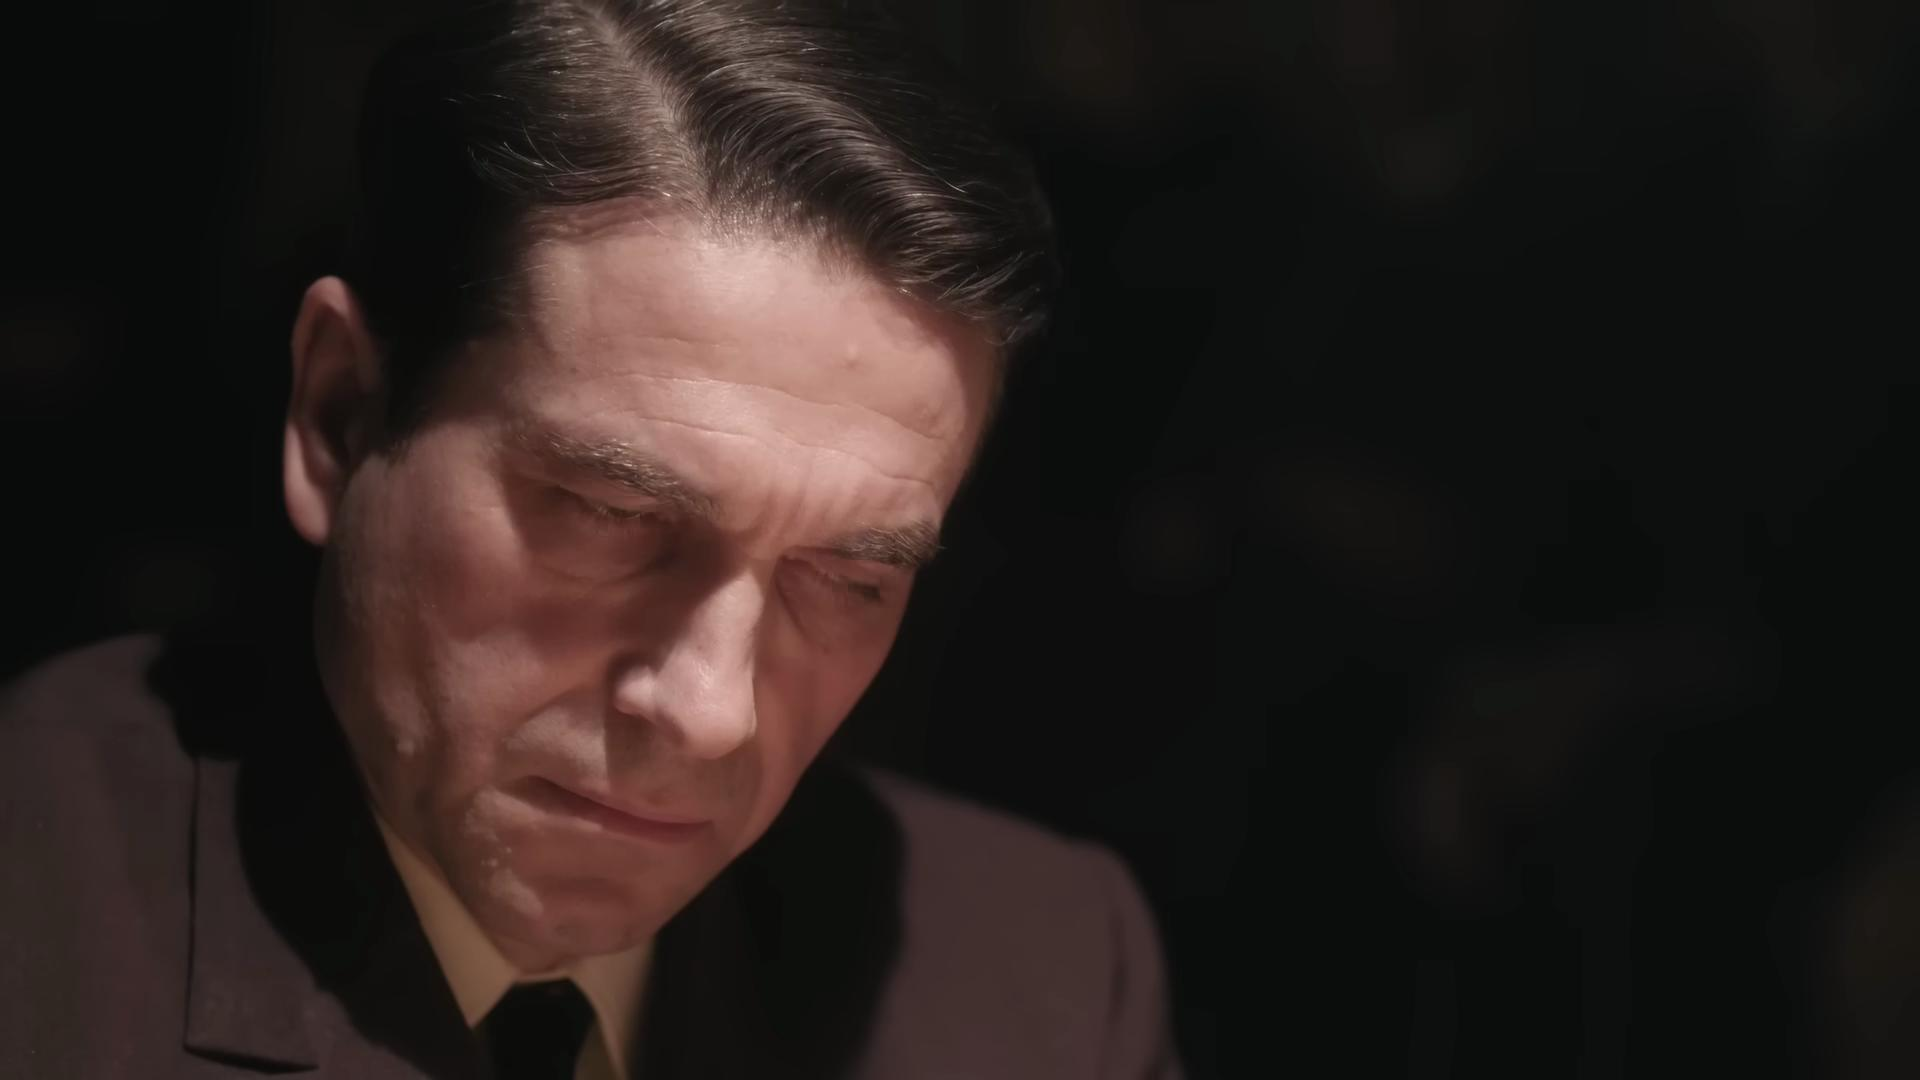

In [7]:
v.collect()

## 02 - Create a View from Scenes

To create a view with video segments, we need to extract the scene start times from the `scenes` column. The [`video_splitter()`](https://docs.pixeltable.com/sdk/latest/video#iterator-video_splitter) iterator needs an array of start times, which we can extract using JSON indexing: `v.scenes[1:].start_time` (skipping the first scene which typically starts at 0). Learn more about [iterators](https://docs.pixeltable.com/platform/iterators) and [JSON operations](https://docs.pixeltable.com/platform/type-system).

In [8]:
from pixeltable.functions.video import video_splitter

scenes = pxt.create_view(
    'scene_view',
    v,
    iterator=video_splitter(
        video=v.video,
        segment_times=v.scenes[1:].start_time,
        mode='fast',
    ),
    if_exists='replace'
)

Inserting rows into `scene_view`: 10 rows [00:00, 2941.31 rows/s]


The view now has one row per scene segment. Let's check the schema and see some sample rows:


In [9]:
scenes

view 'scene_view' (of 'chess_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              video            Video                                                   
           duration            Float                               video.get_duration()
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

The [`video_splitter()`](https://docs.pixeltable.com/sdk/latest/video#iterator-video_splitter) iterator adds the following columns to the view:

- `pos`: Position/index of the segment
- `video_segment`: The actual video segment file
- `segment_start`: Start time of the segment in seconds
- `segment_end`: End time of the segment in seconds
- `segment_start_pts` / `segment_end_pts`: Presentation timestamps (for advanced use)

pos,segment_start,segment_end,video_segment
0,0.,28.779,
1,28.779,45.629,
2,45.629,125.751,
3,125.751,154.488,
4,154.488,180.222,
5,180.222,231.524,
6,231.524,301.843,
7,301.843,308.975,
8,308.975,350.433,
9,350.433,377.043,

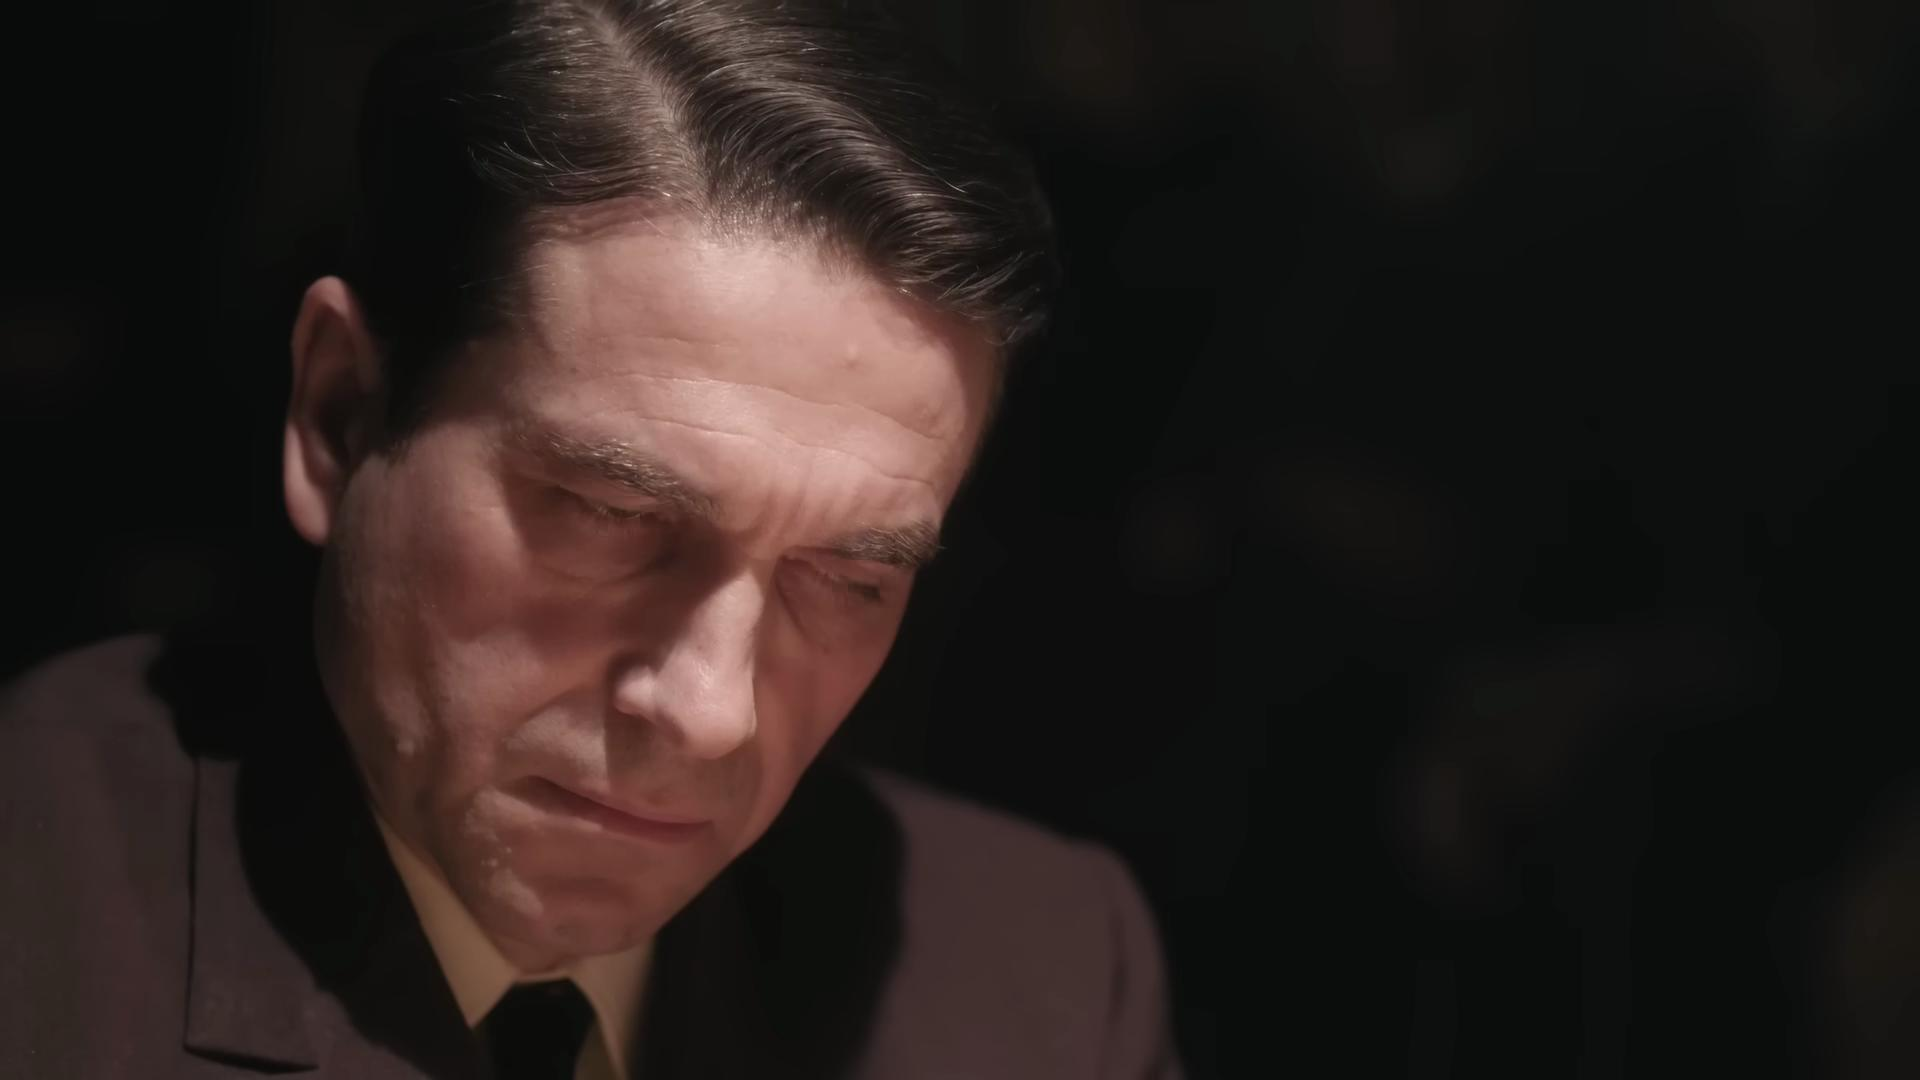
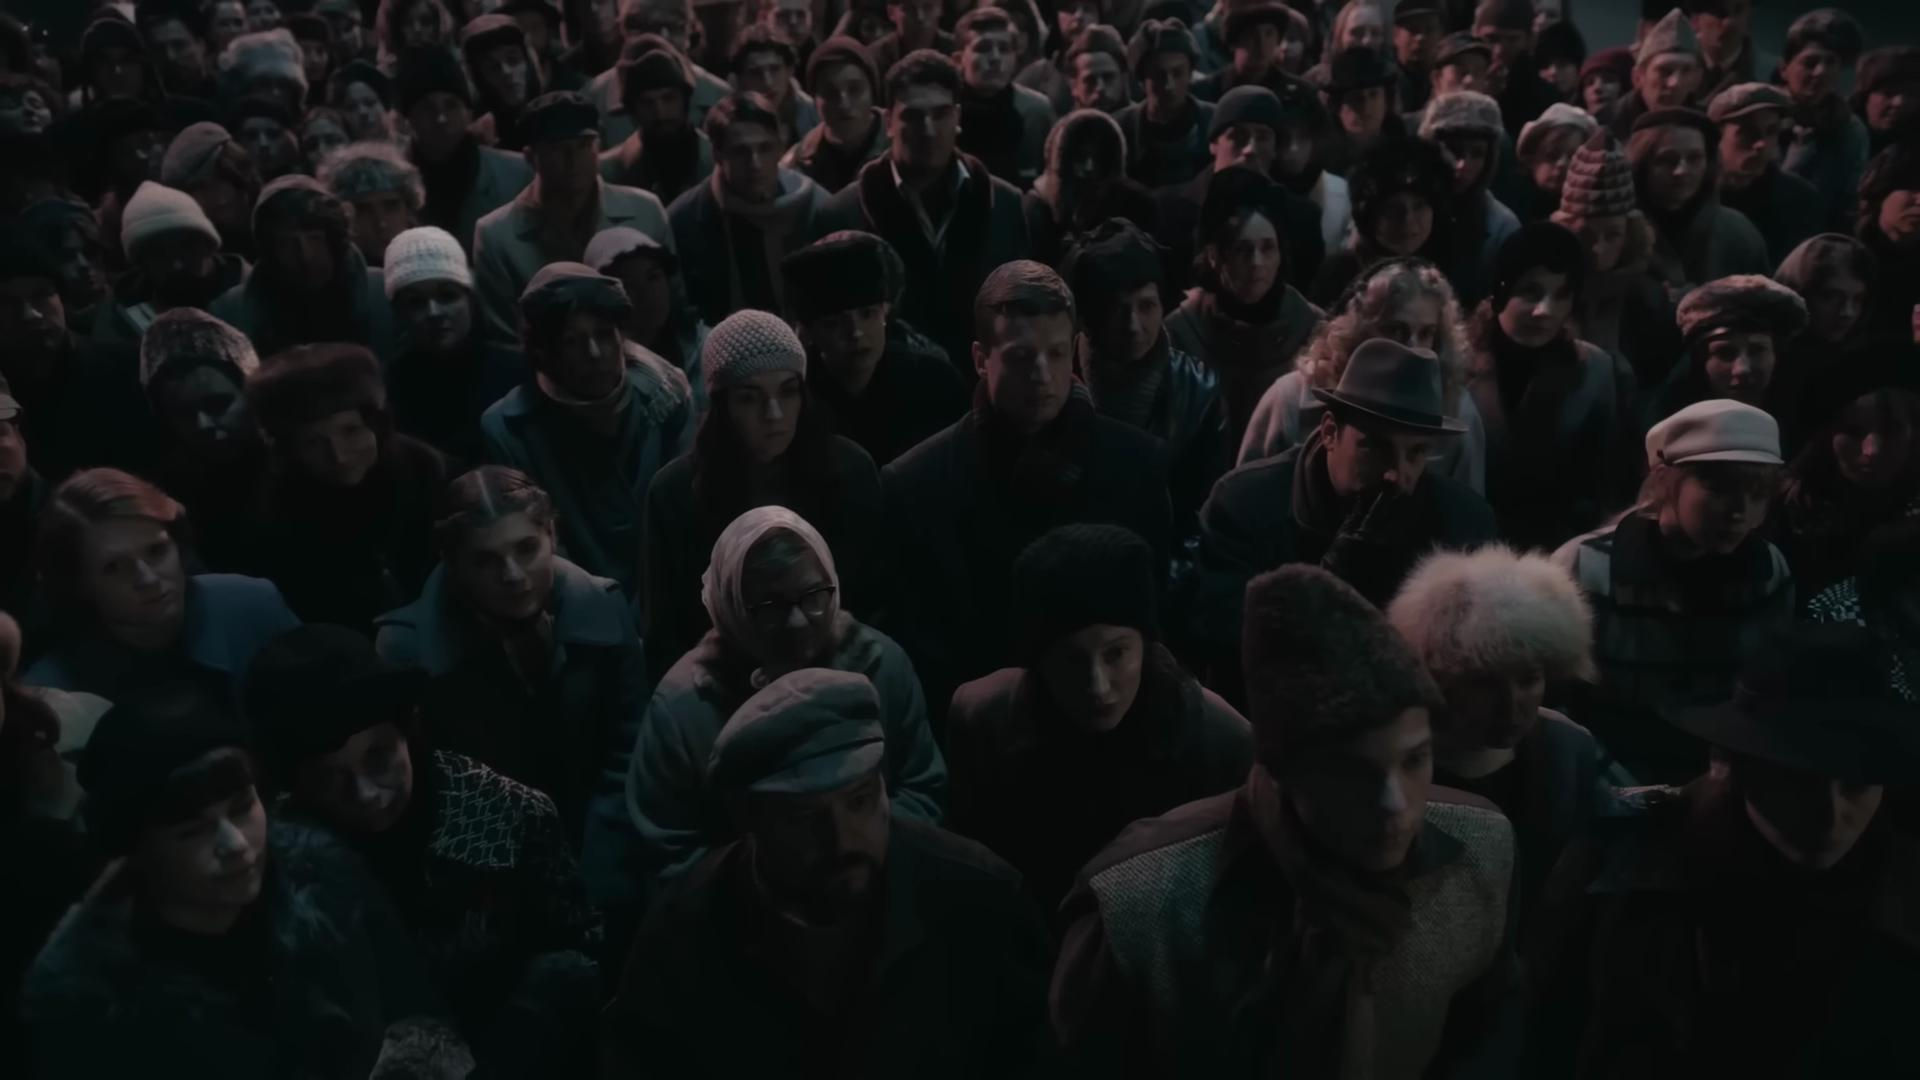
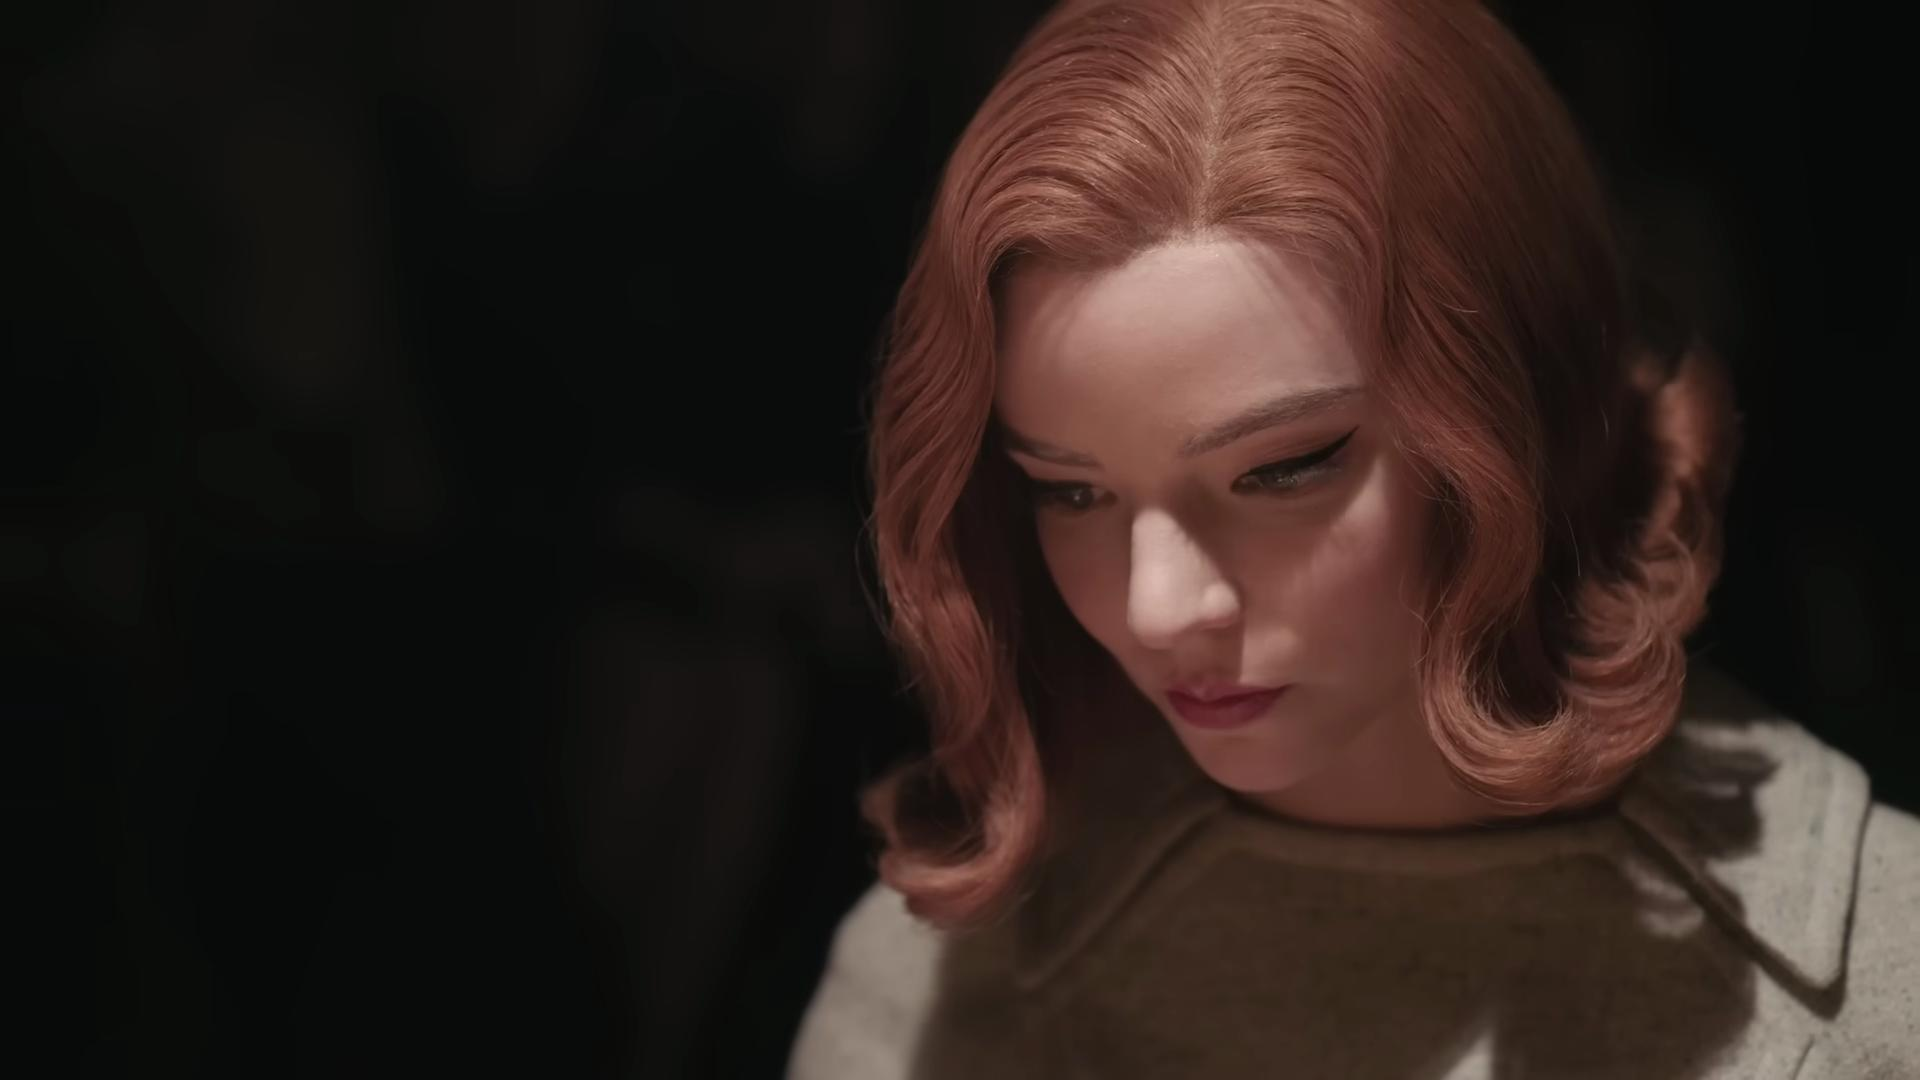
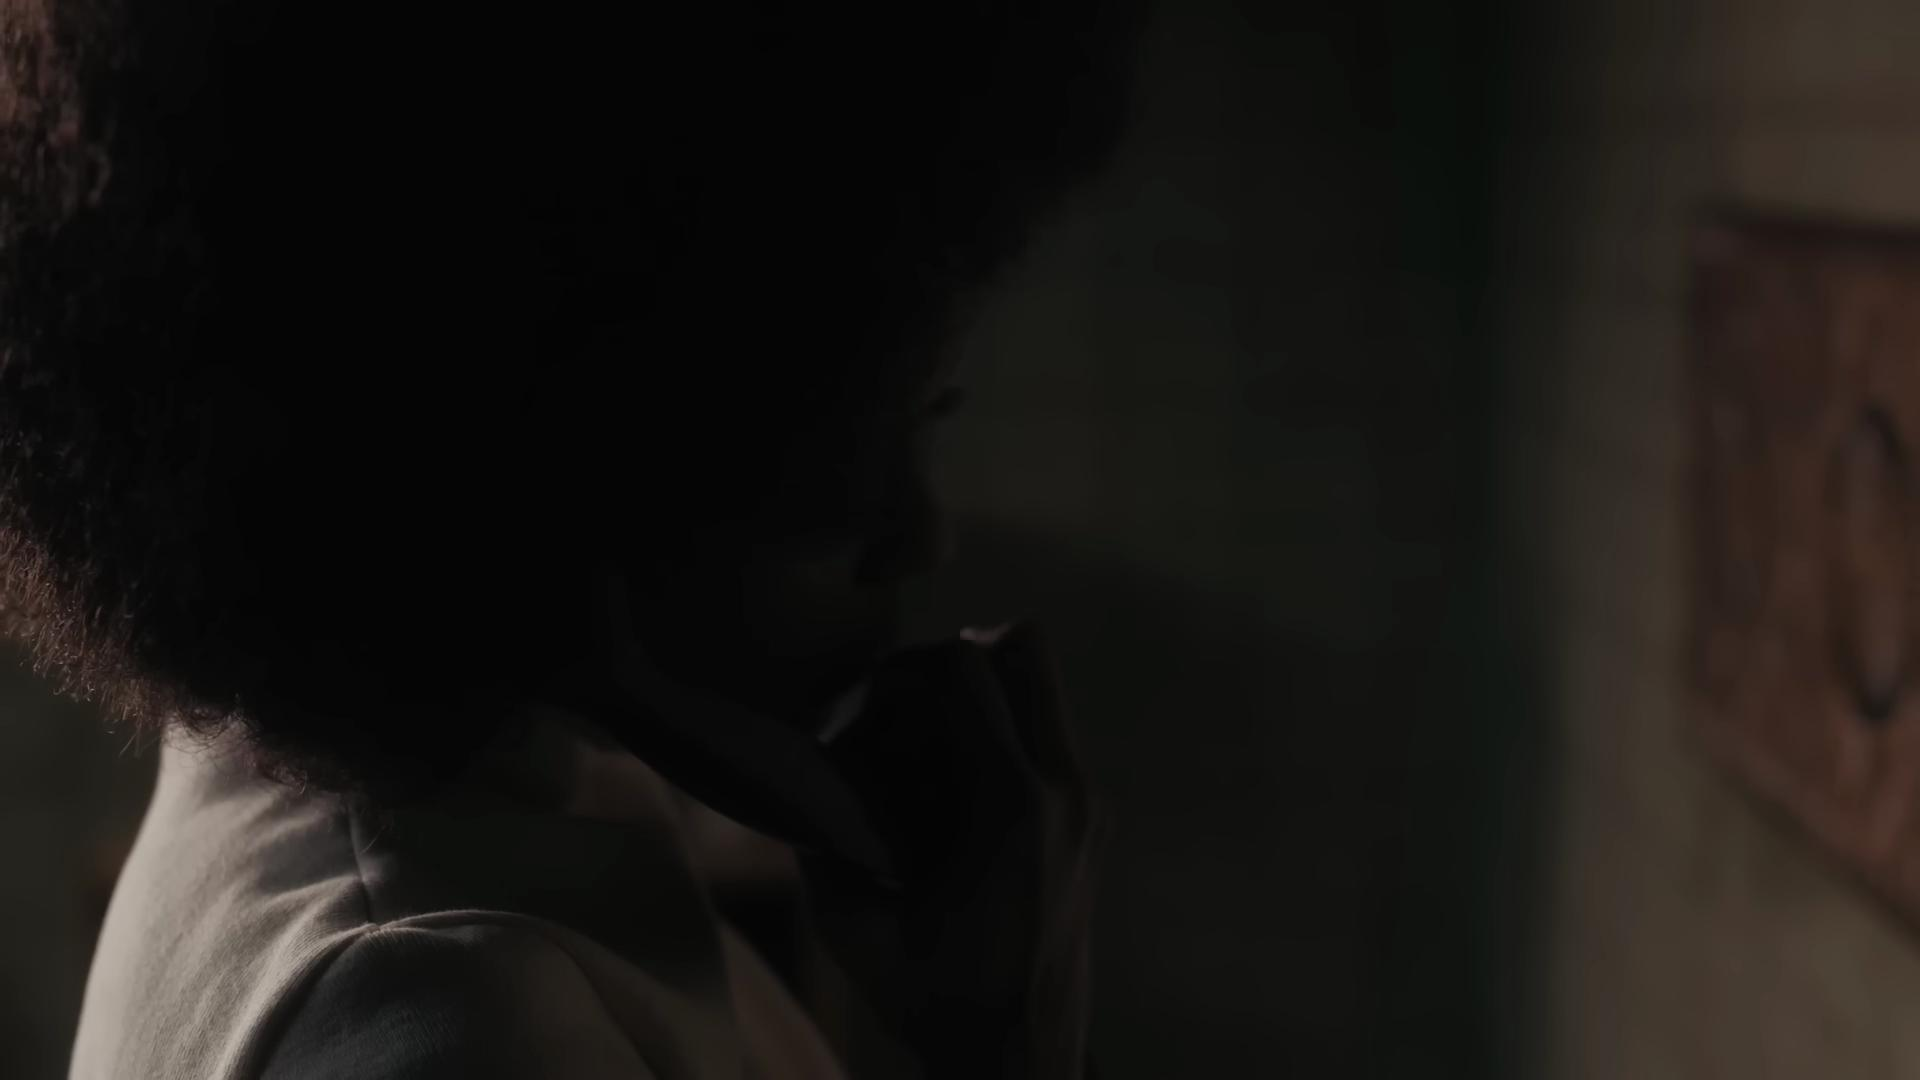
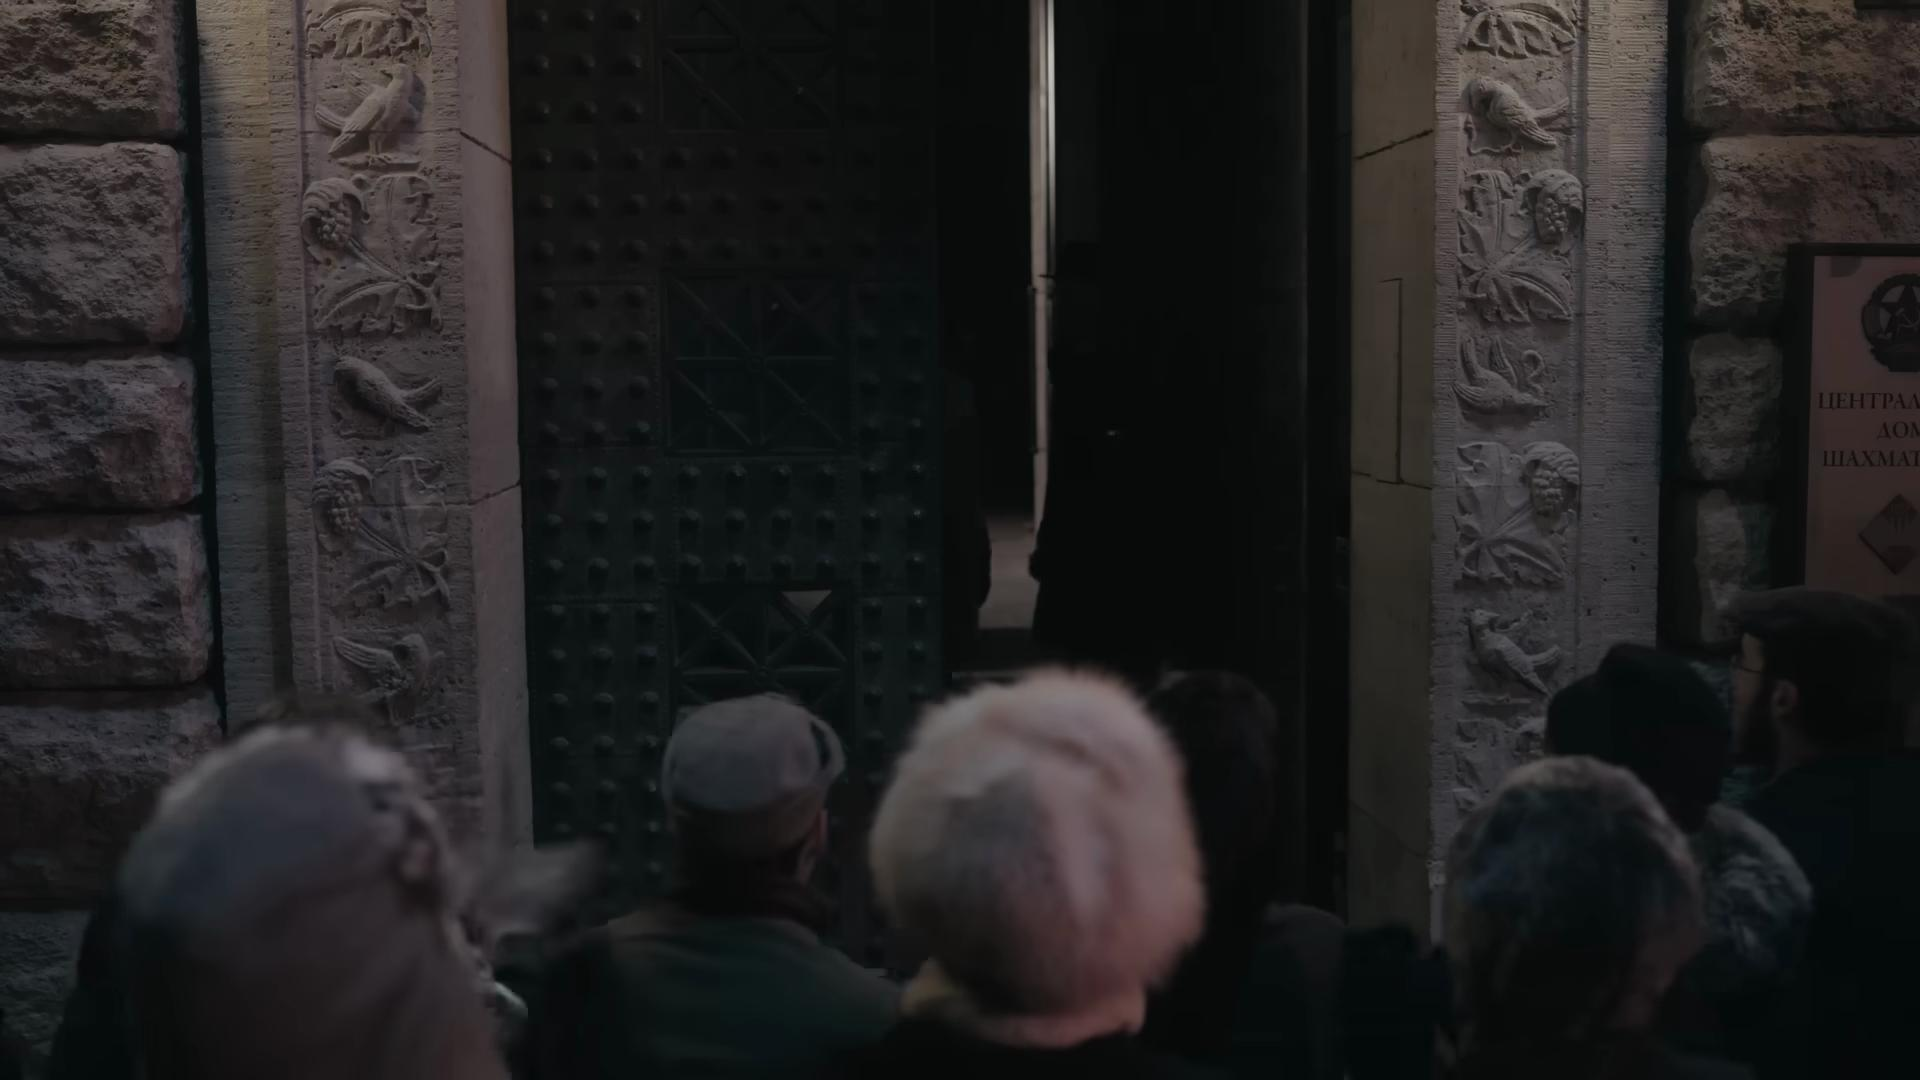
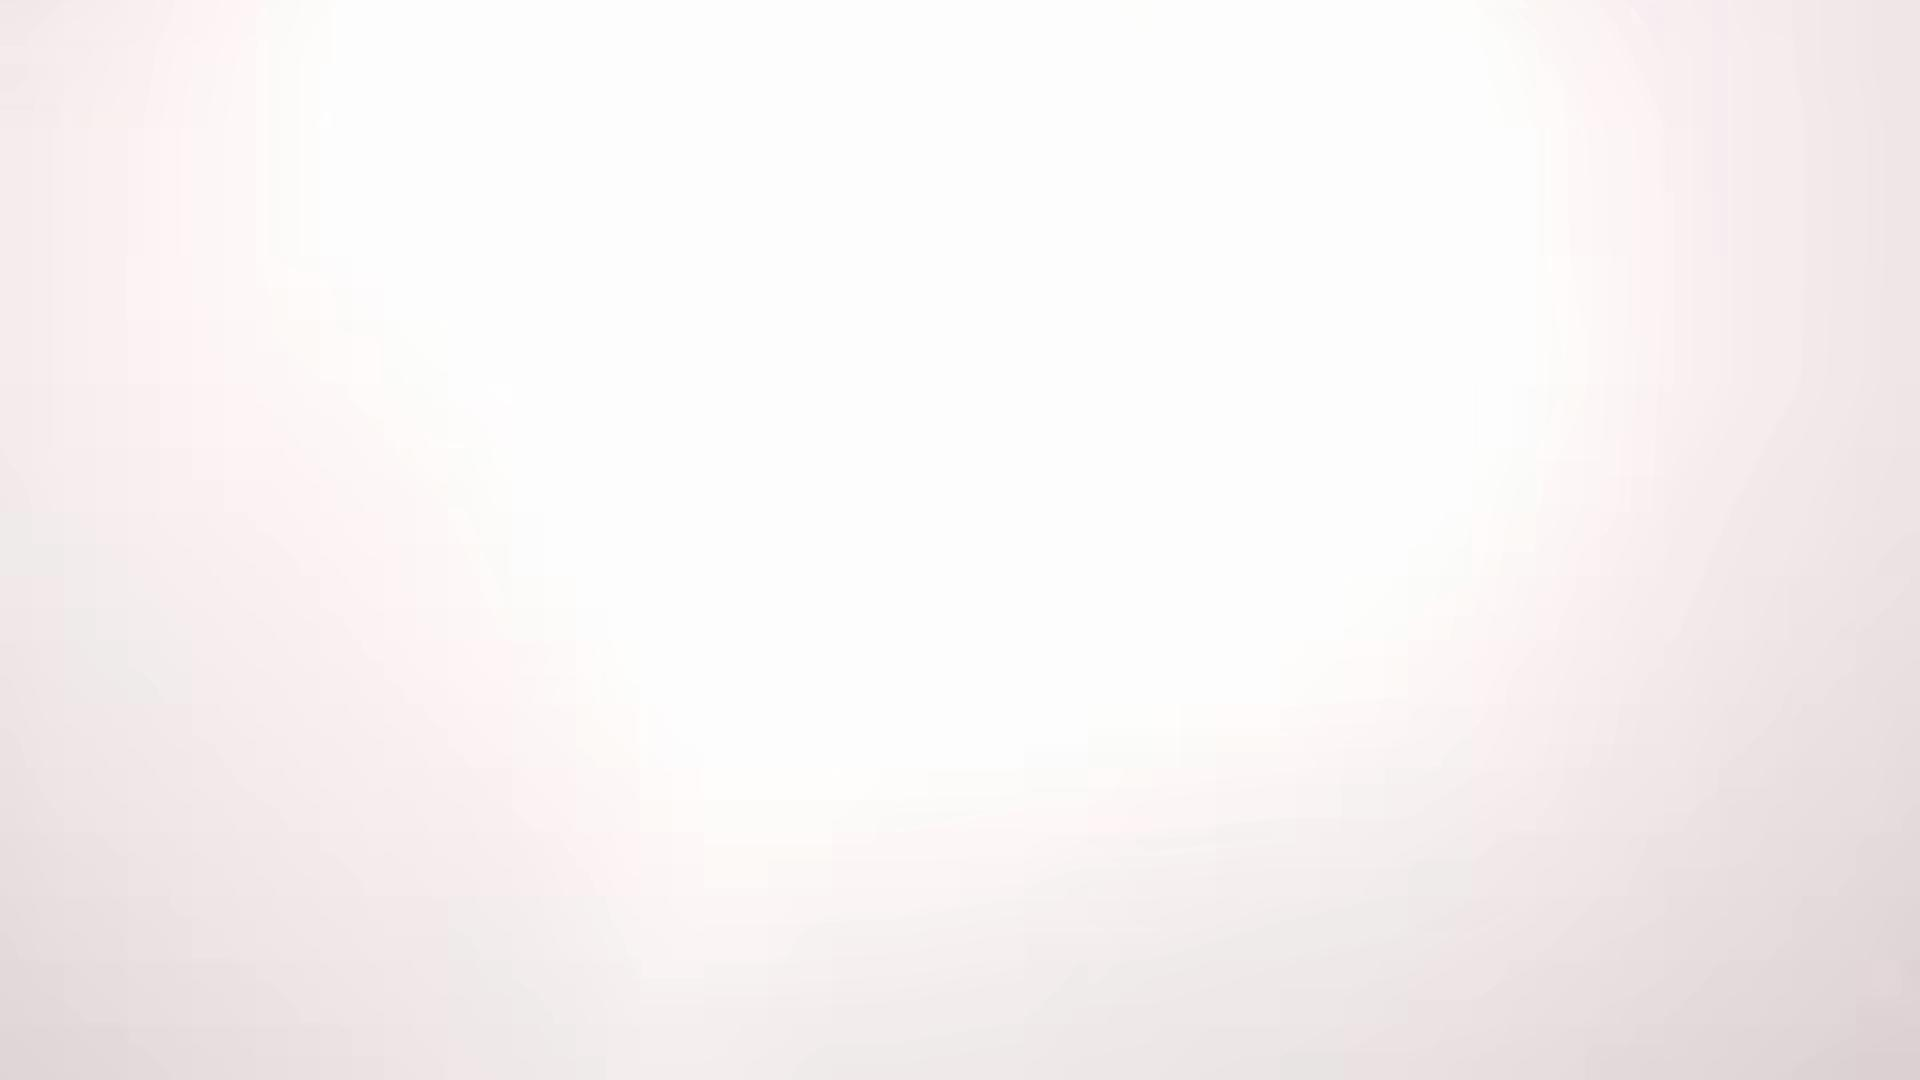
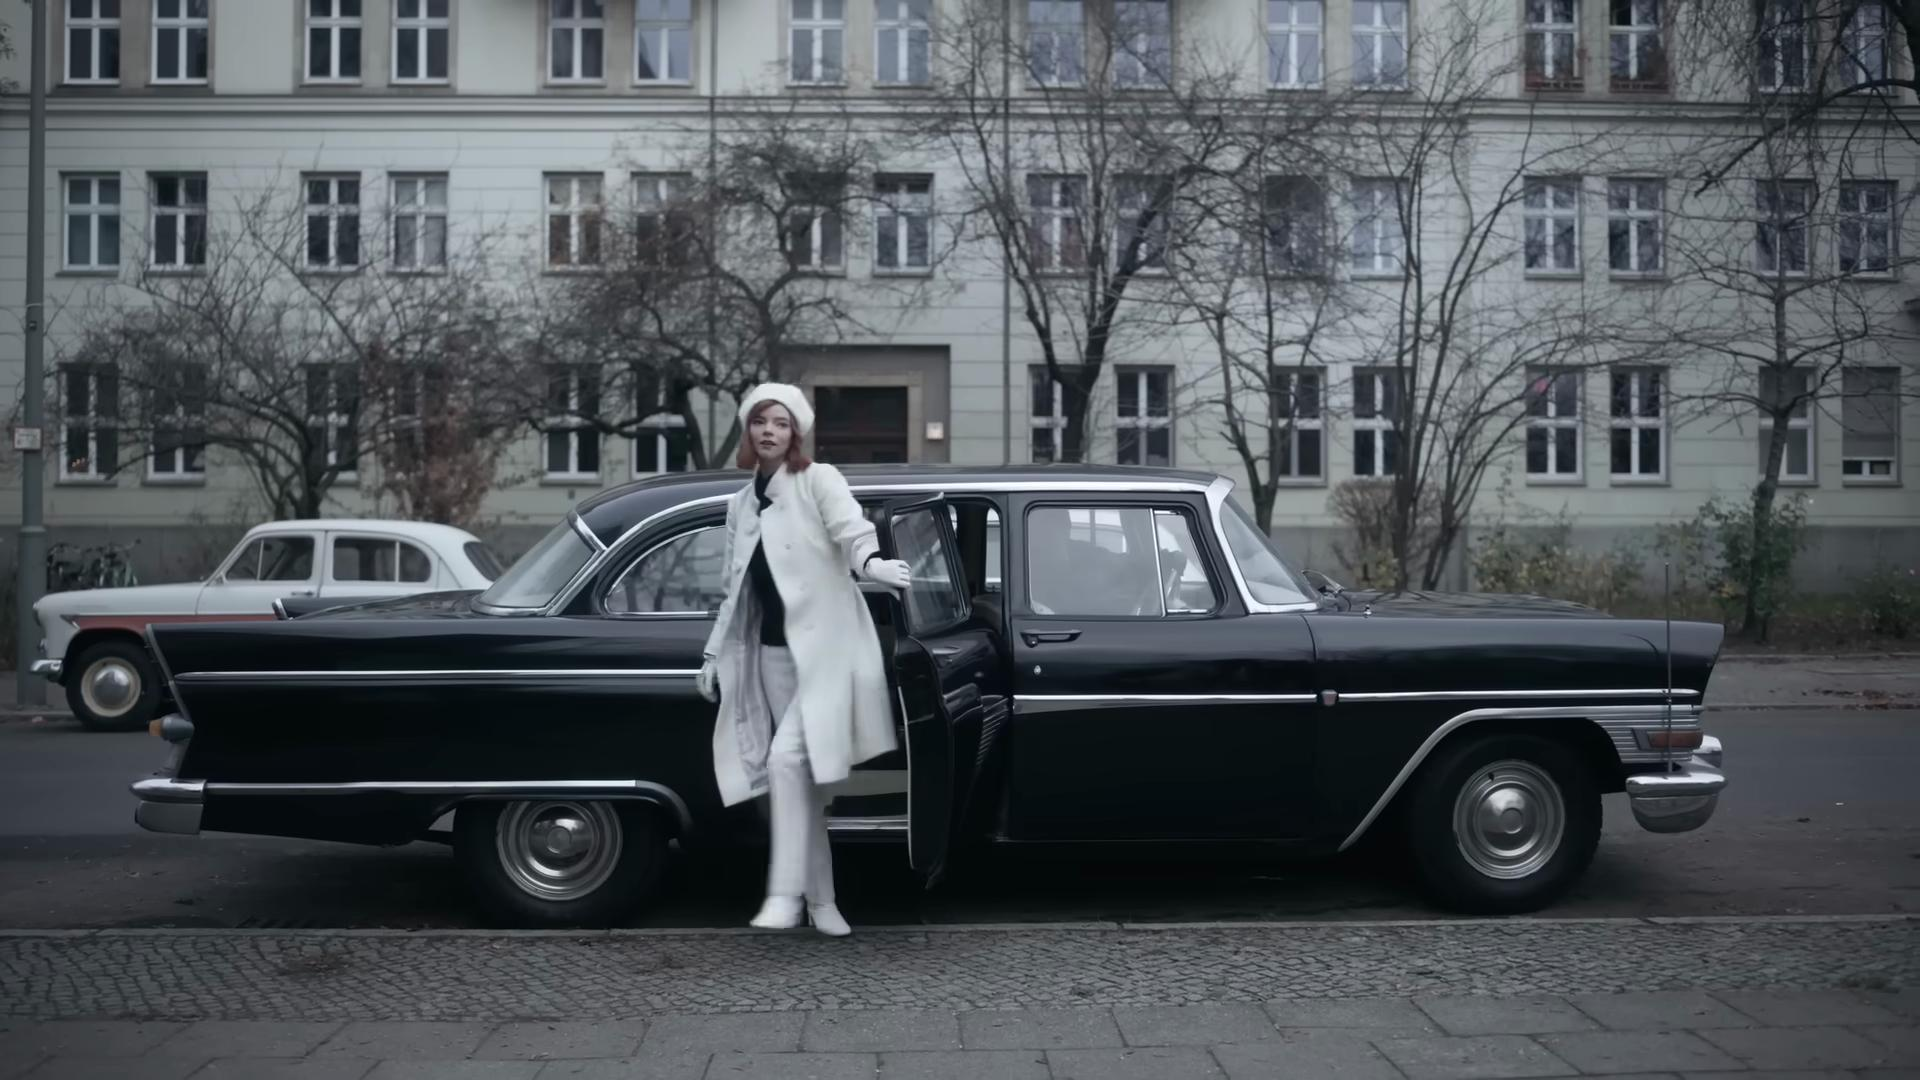
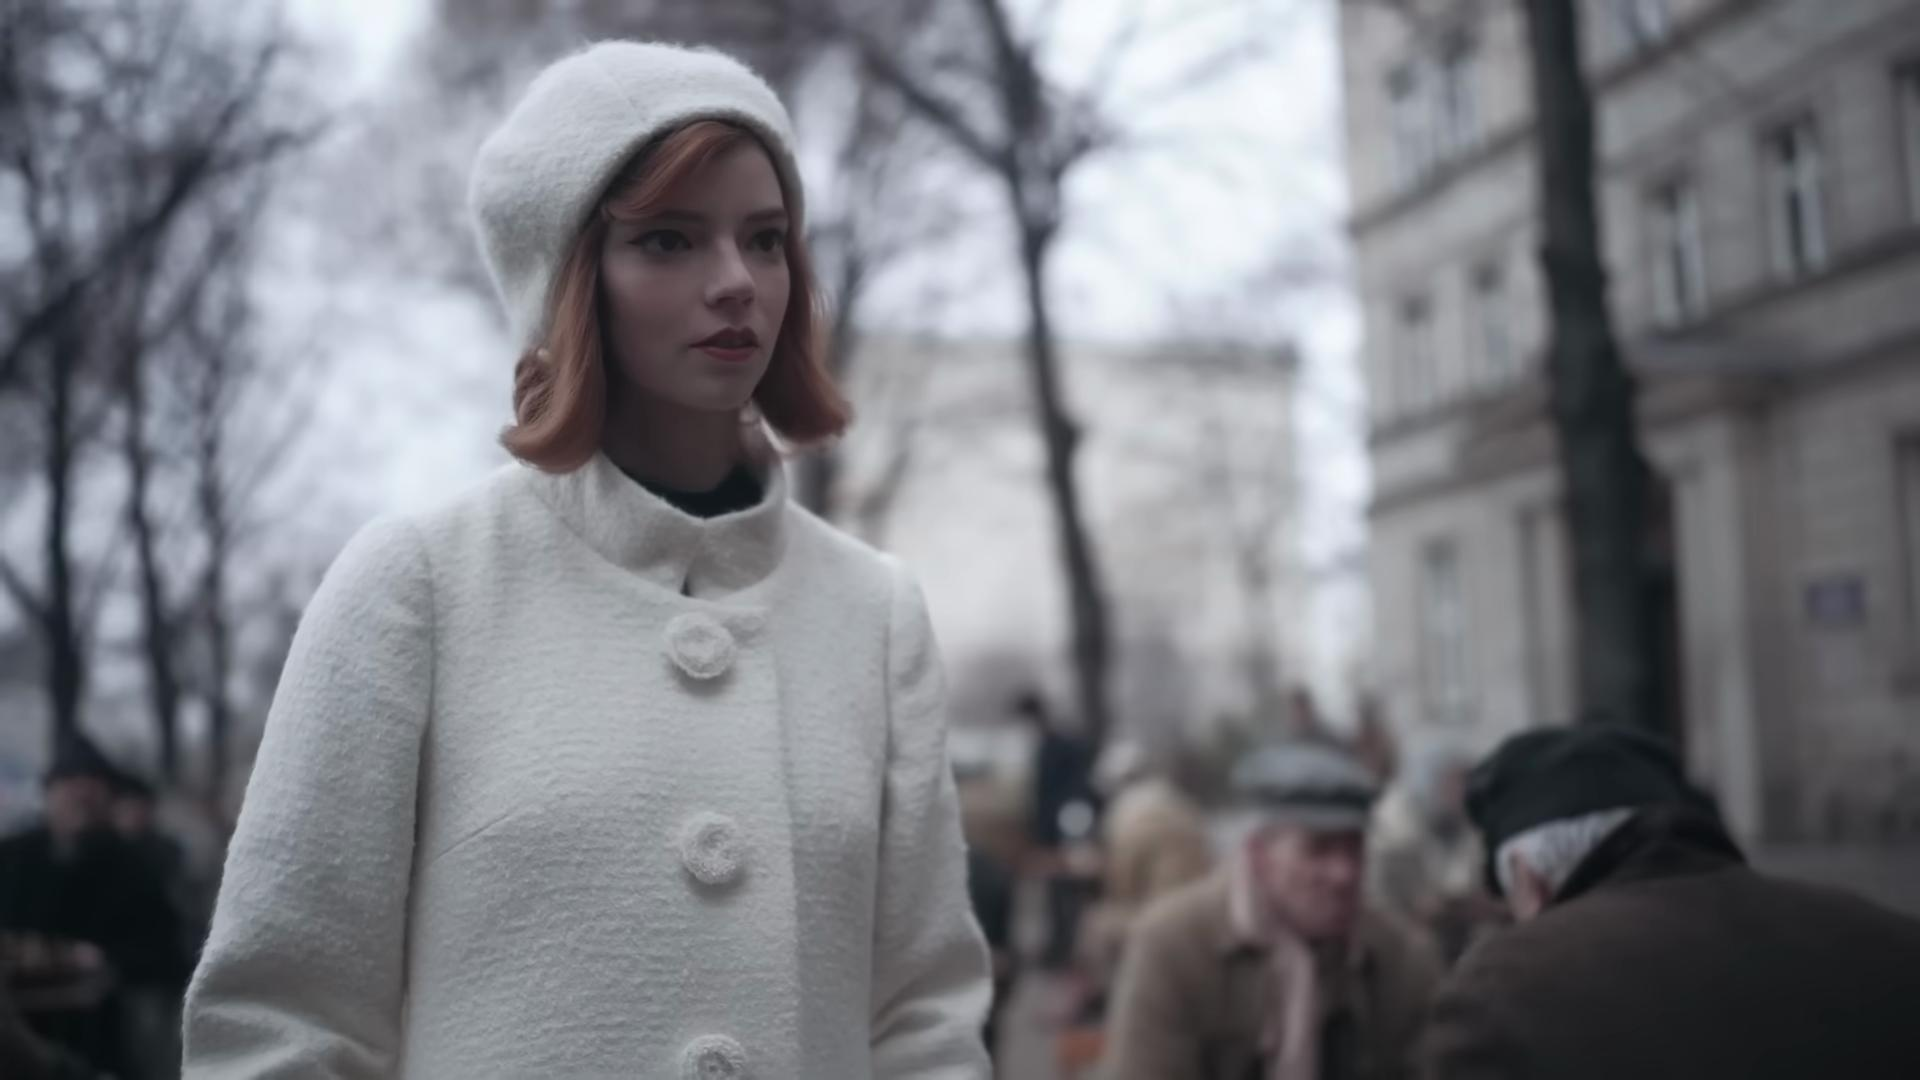
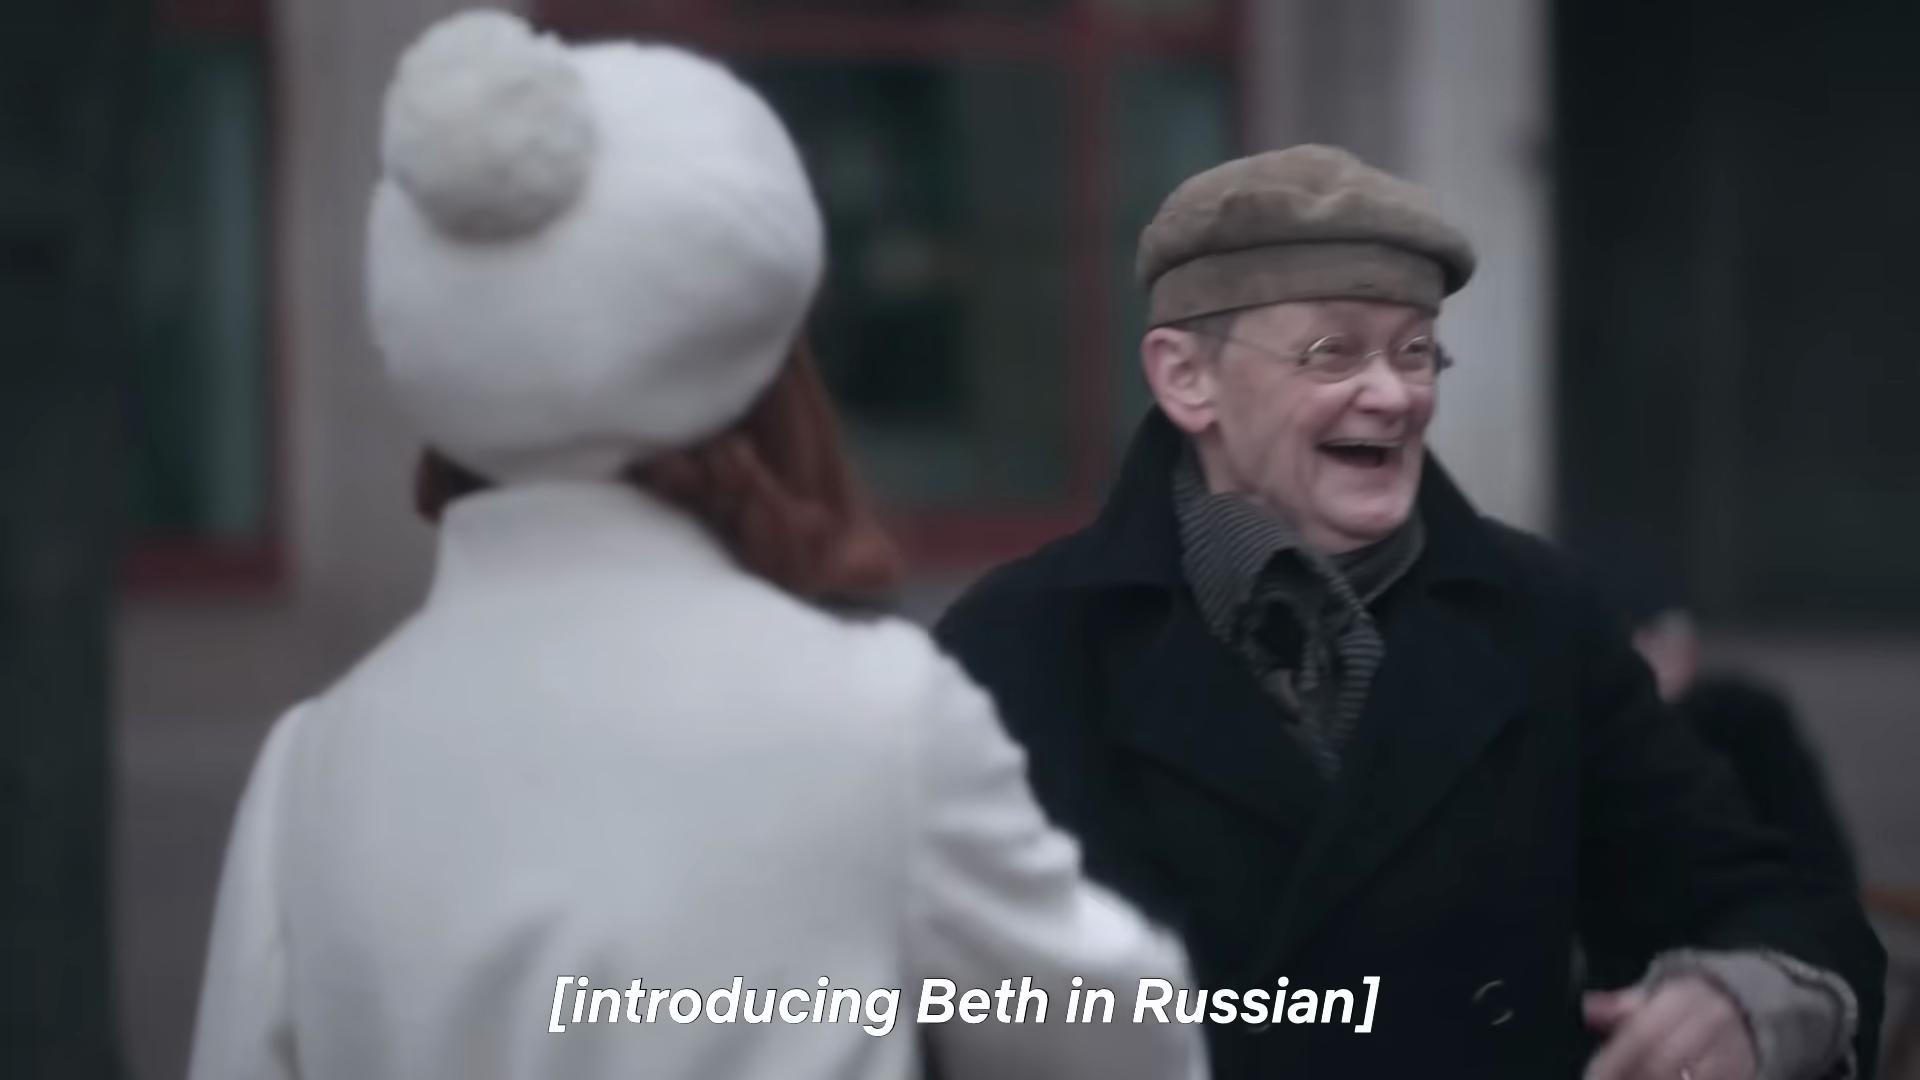
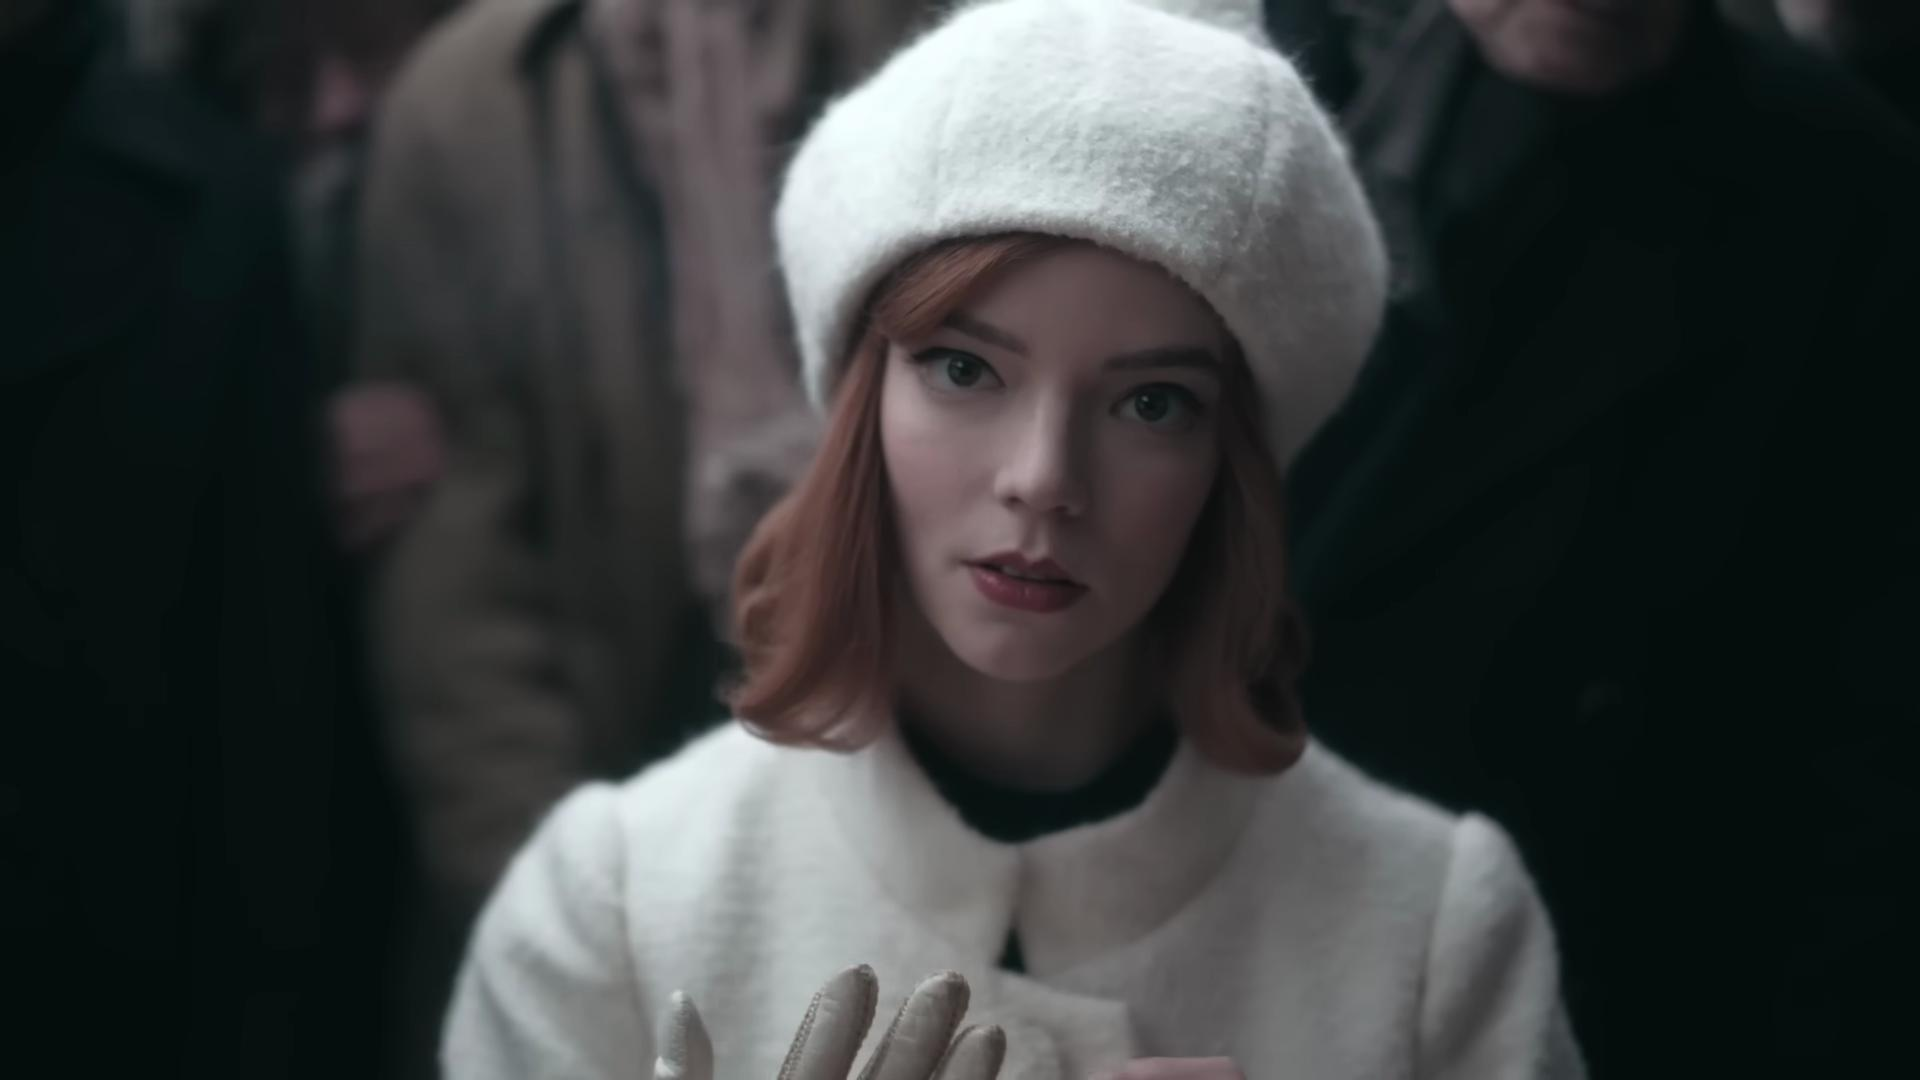

In [10]:
scenes.select(scenes.pos, scenes.segment_start, scenes.segment_end, scenes.video_segment).tail()

## 03 - Add Audio & Transcripts

Let's enrich our scene view with audio and transcripts. Since dialogue is typically sparse, scene-level transcription and embeddings are sufficient for search.


### Extract & Transcribe Audio

Extract audio from each scene's video segment and transcribe it using Whisper.


In [11]:
# Extract audio from video segments
scenes.add_computed_column(
    audio=scenes.video_segment.extract_audio(),
    if_exists='replace'
)

Added 10 column values with 0 errors.


10 rows updated, 10 values computed.

Transcribe audio using OpenAI's Whisper model. There are two options:

- **Local Whisper:** Free, no API key needed, but slower
- **OpenAI API:** Faster, but requires an API key and costs money

We'll use local Whisper for this example:


In [12]:
from pixeltable.functions import whisper

scenes.add_computed_column(
    transcription=whisper.transcribe(scenes.audio, model='base'),
    if_exists='replace'
)

/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/alison-pxt/Documents/Github/p

Added 10 column values with 0 errors.


10 rows updated, 10 values computed.

In [ ]:
# Alternative: Using OpenAI API for transcription (faster, but requires API key)
# Uncomment and use this instead of the built-in whisper function below
# 
# First, install the openai package: pip install openai
# Set your API key: export OPENAI_API_KEY='your-api-key-here'
#
# from pixeltable.functions.openai import transcriptions
# 
# scenes.add_computed_column(
#     api_tx=transcriptions(scenes.audio, model='whisper-1'),
#     if_exists='replace'
# )

pos                                      video_segment  \
0    0  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   
1    1  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   
2    2  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   
3    3  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   
4    4  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   
5    5  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   
6    6  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   
7    7  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   
8    8  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   
9    9  /Users/alison-pxt/.pixeltable/media/01199ea7bc...   

                                       transcription  
0  {'text': ' That check has been the whole point...  
1  {'text': ' А вы мы рев', 'language': 'ru', 'se...  
2  {'text': ' It's your game. Take it. Up ahead. ...  
3  {'text': ' Thank you. Good for you, Crackle. G...  
4     {'text': '', 'language': 'en', 'segments': []}  
5  {'text': ' The President has invited you to th...  
6  {'text': ' You're gonna miss the flood? Come o...  
7  {'text': ' Daddy? Harun mu?', 'language': 'tr'...  
8  {'text': ' l'espace�니다.', 'language': 'fr', 's...  
9  {'text': ' Обц tungр ТРЕВОЖНАЯ МУЗЫКА', 'langu...
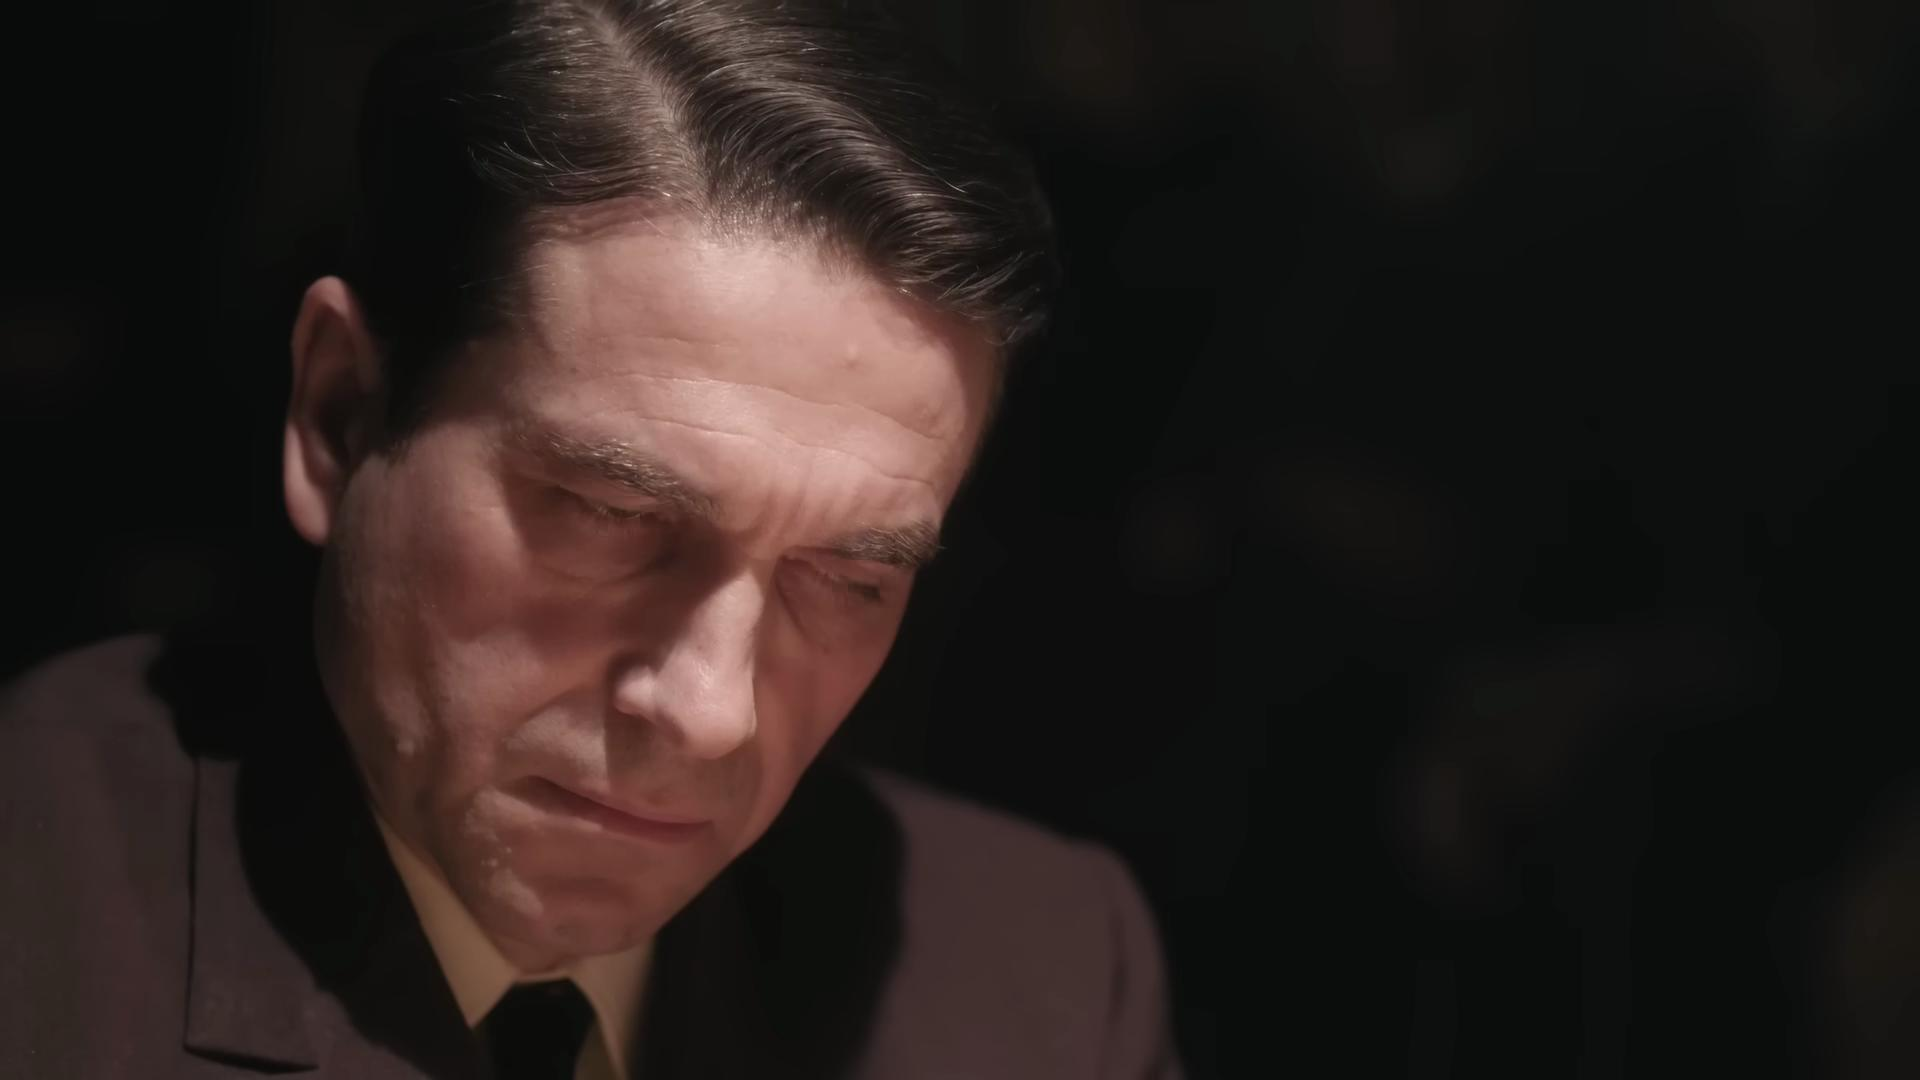
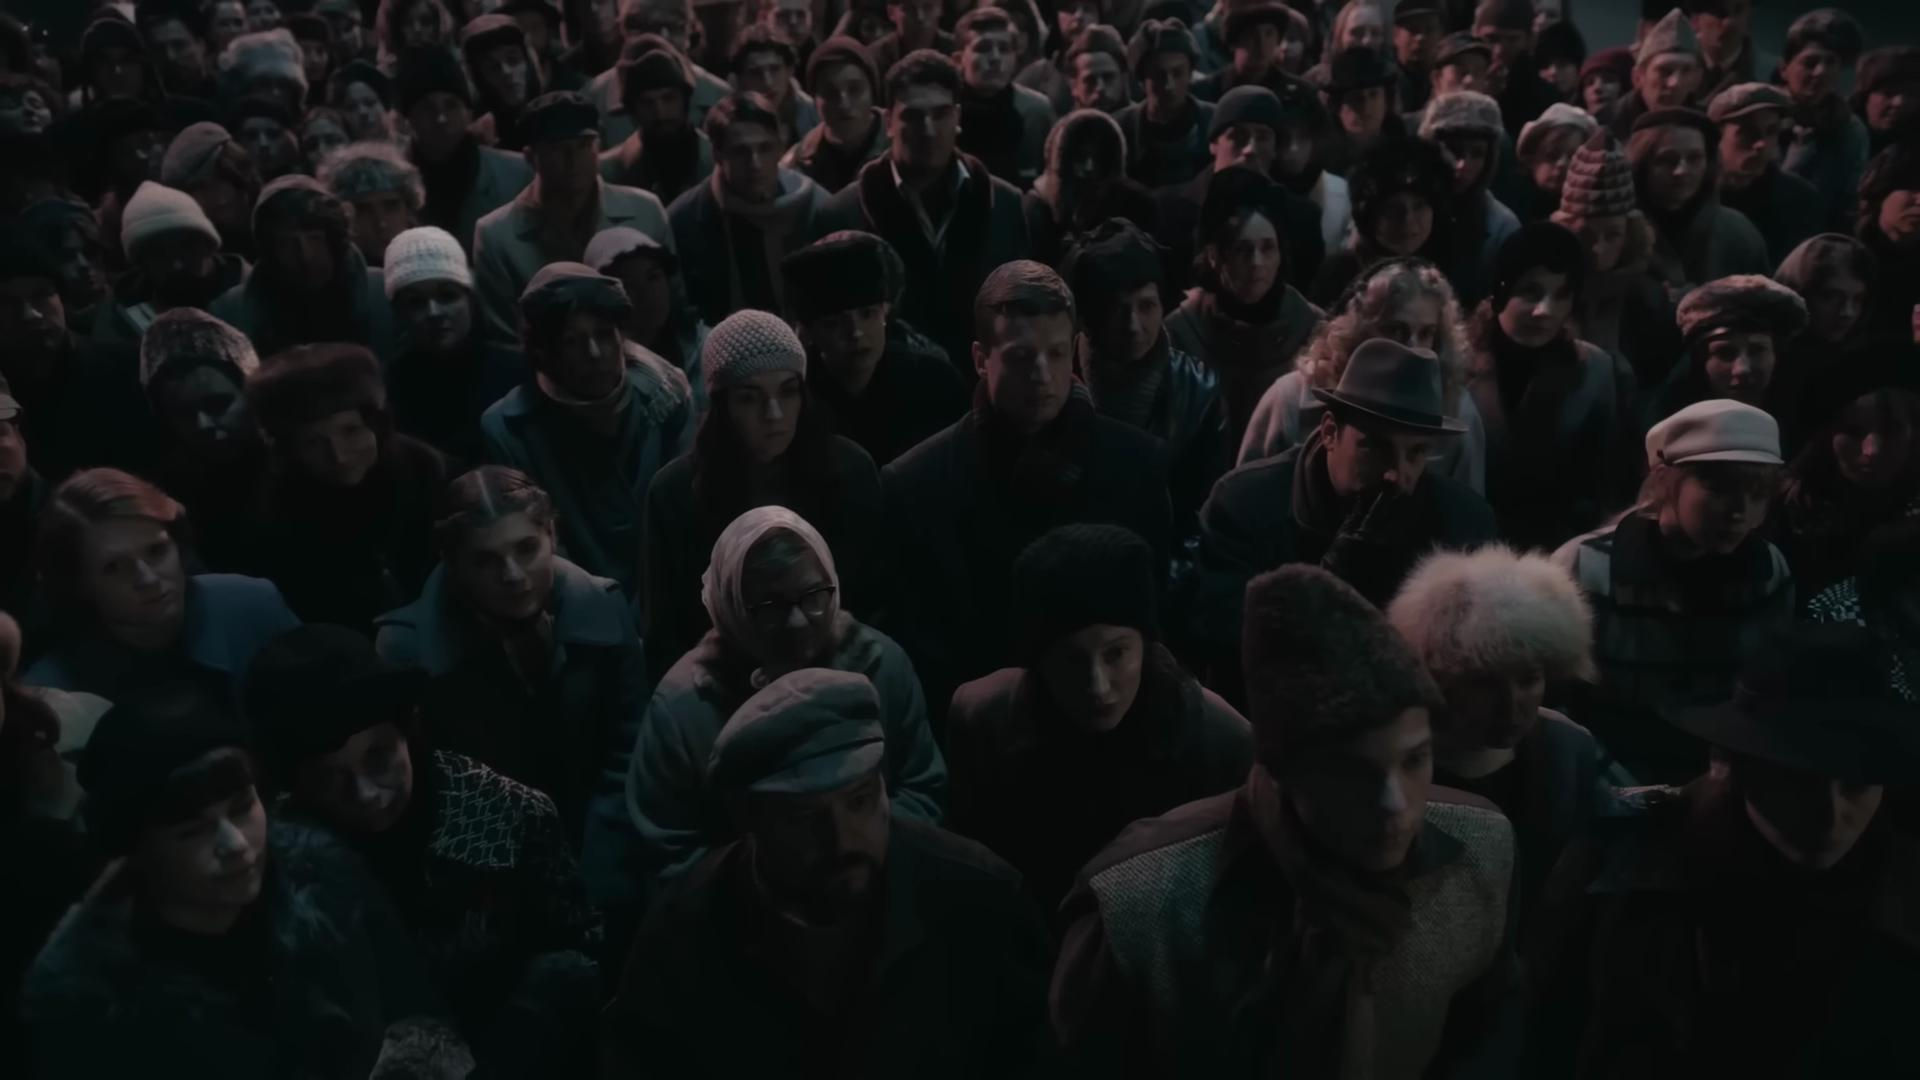
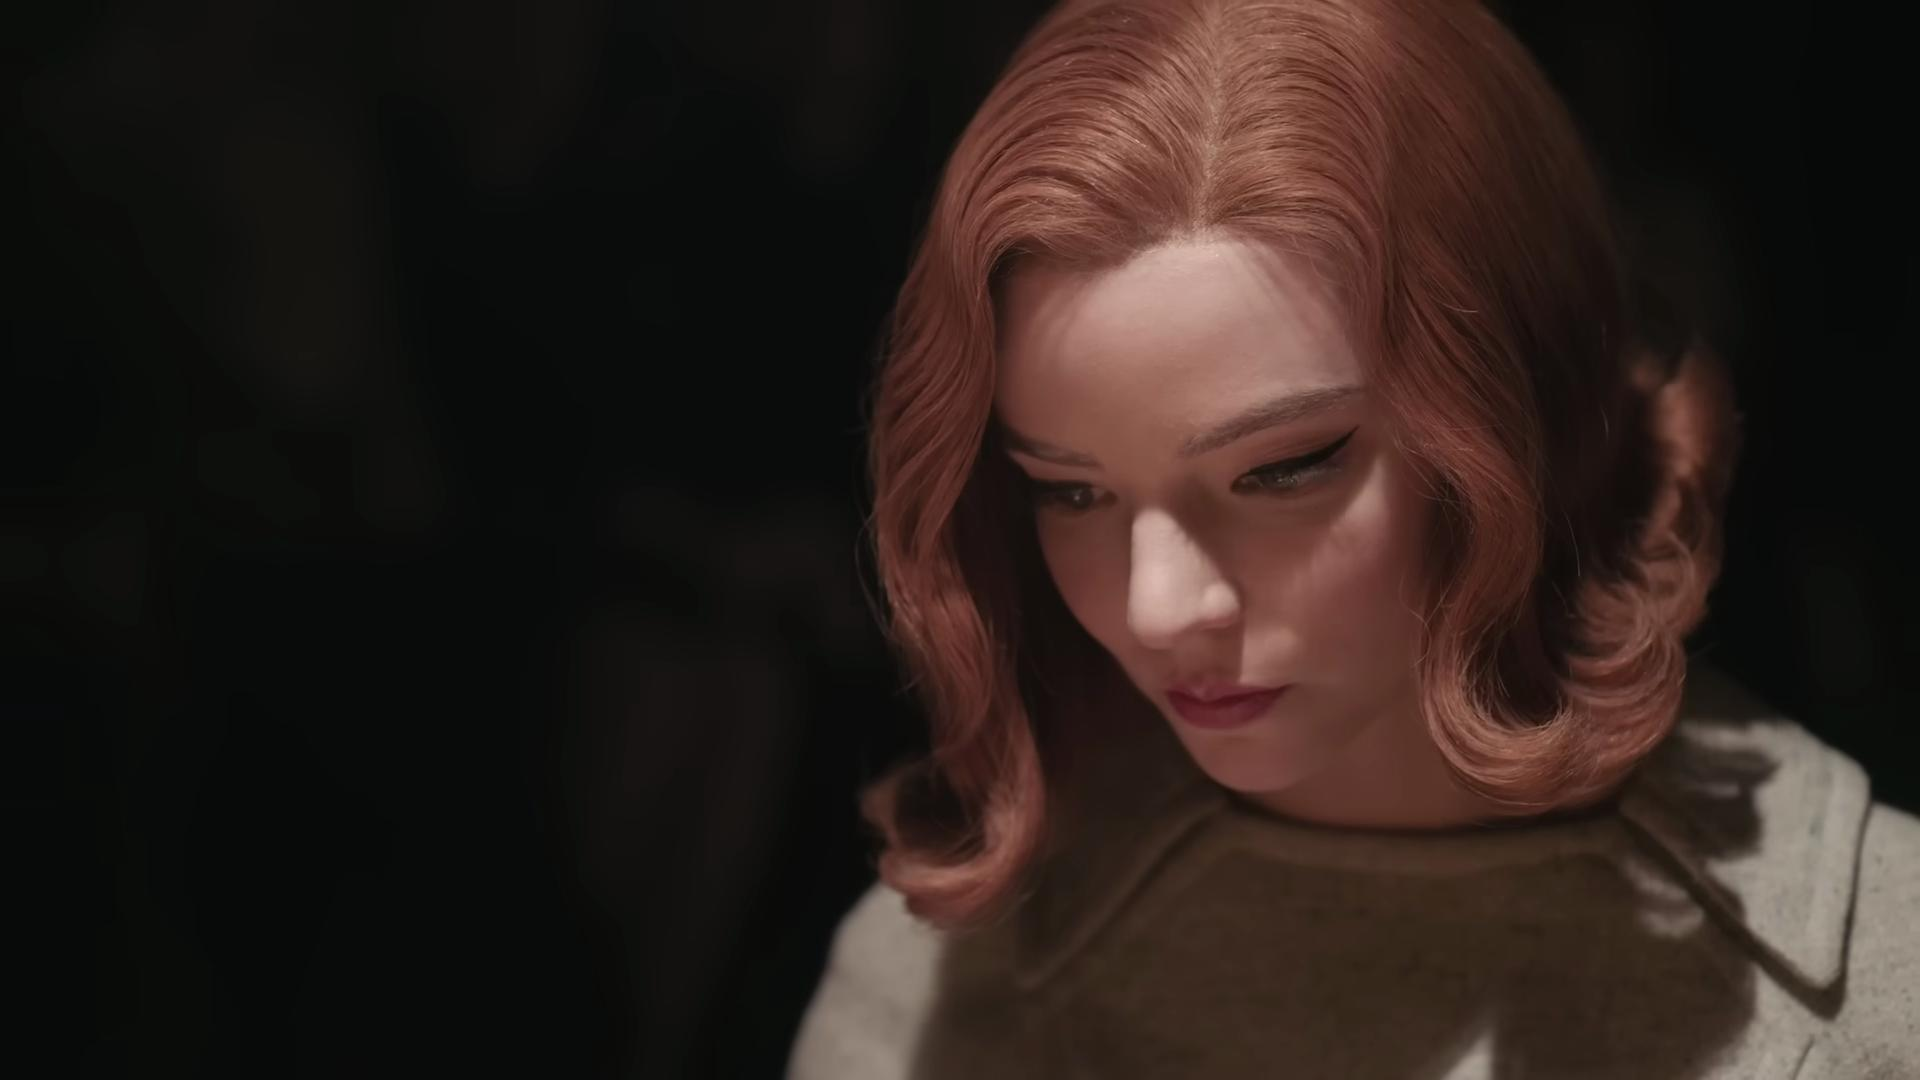
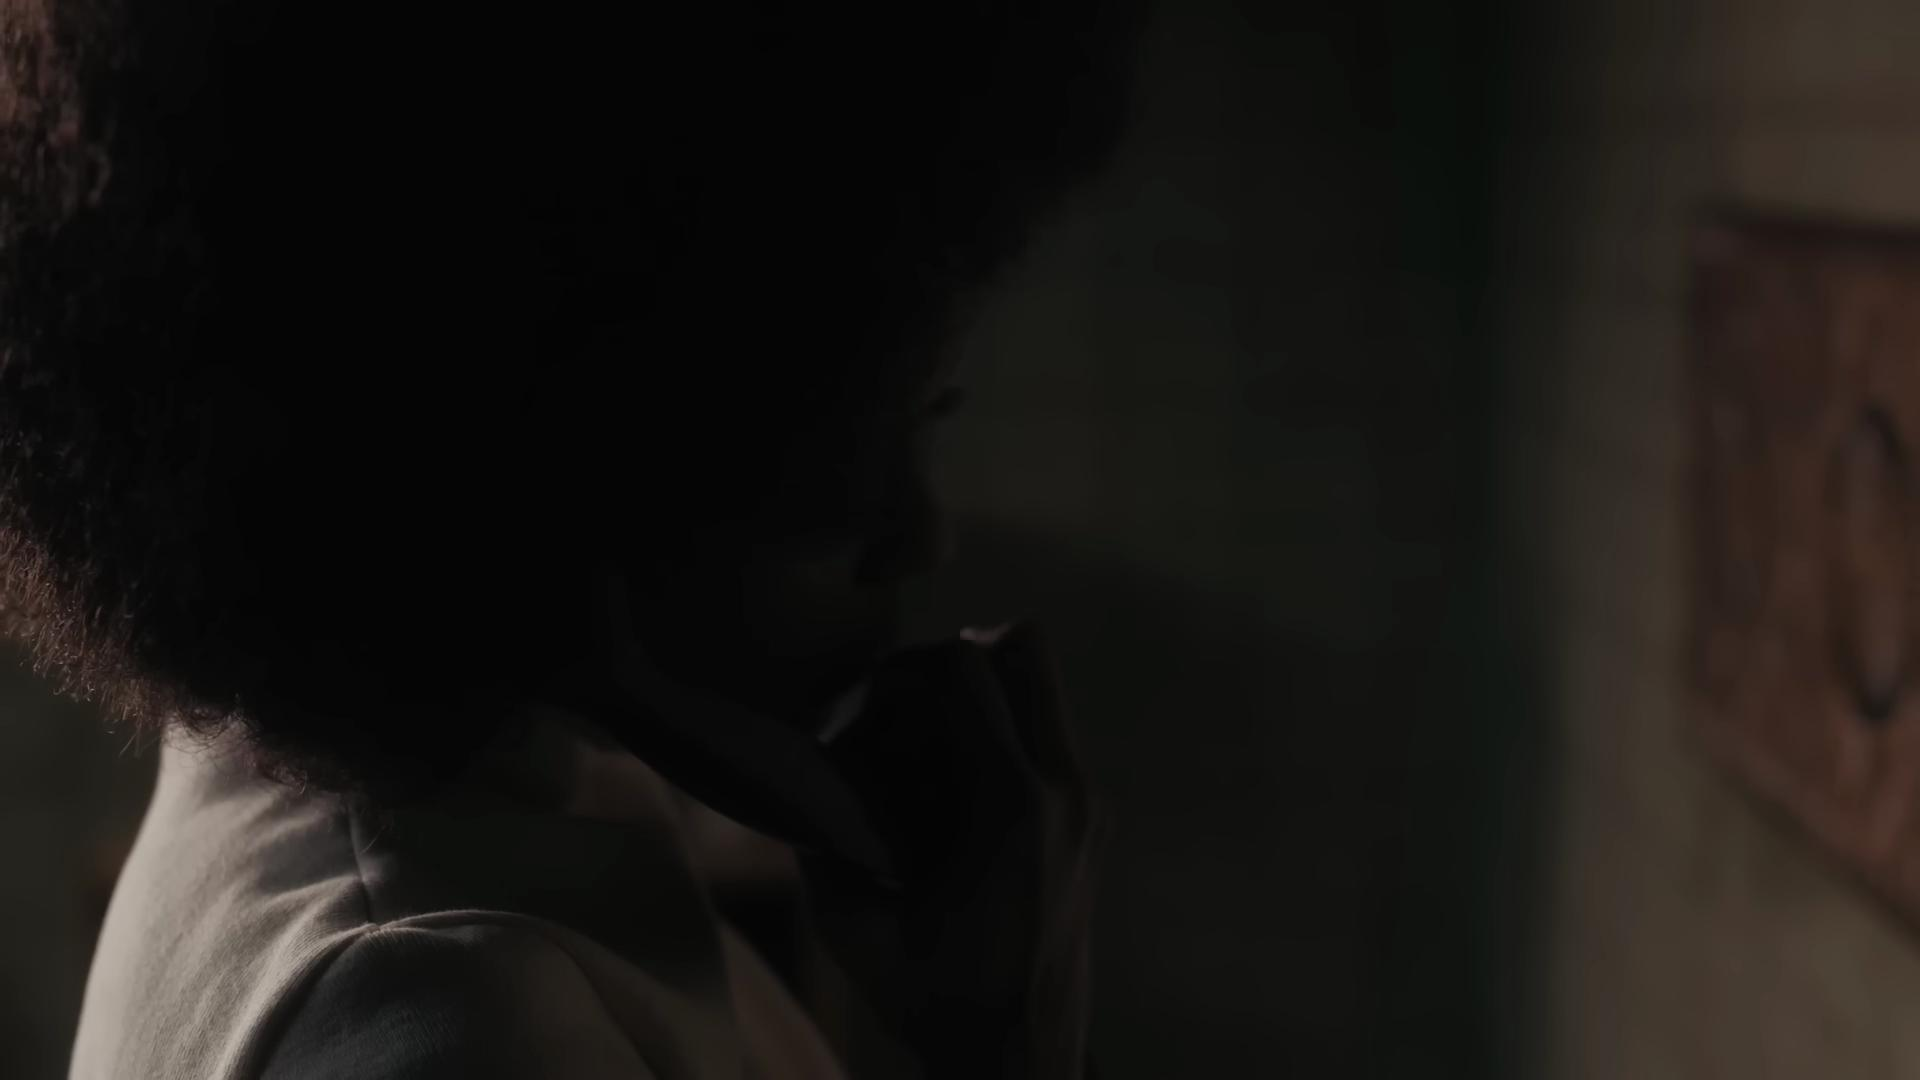
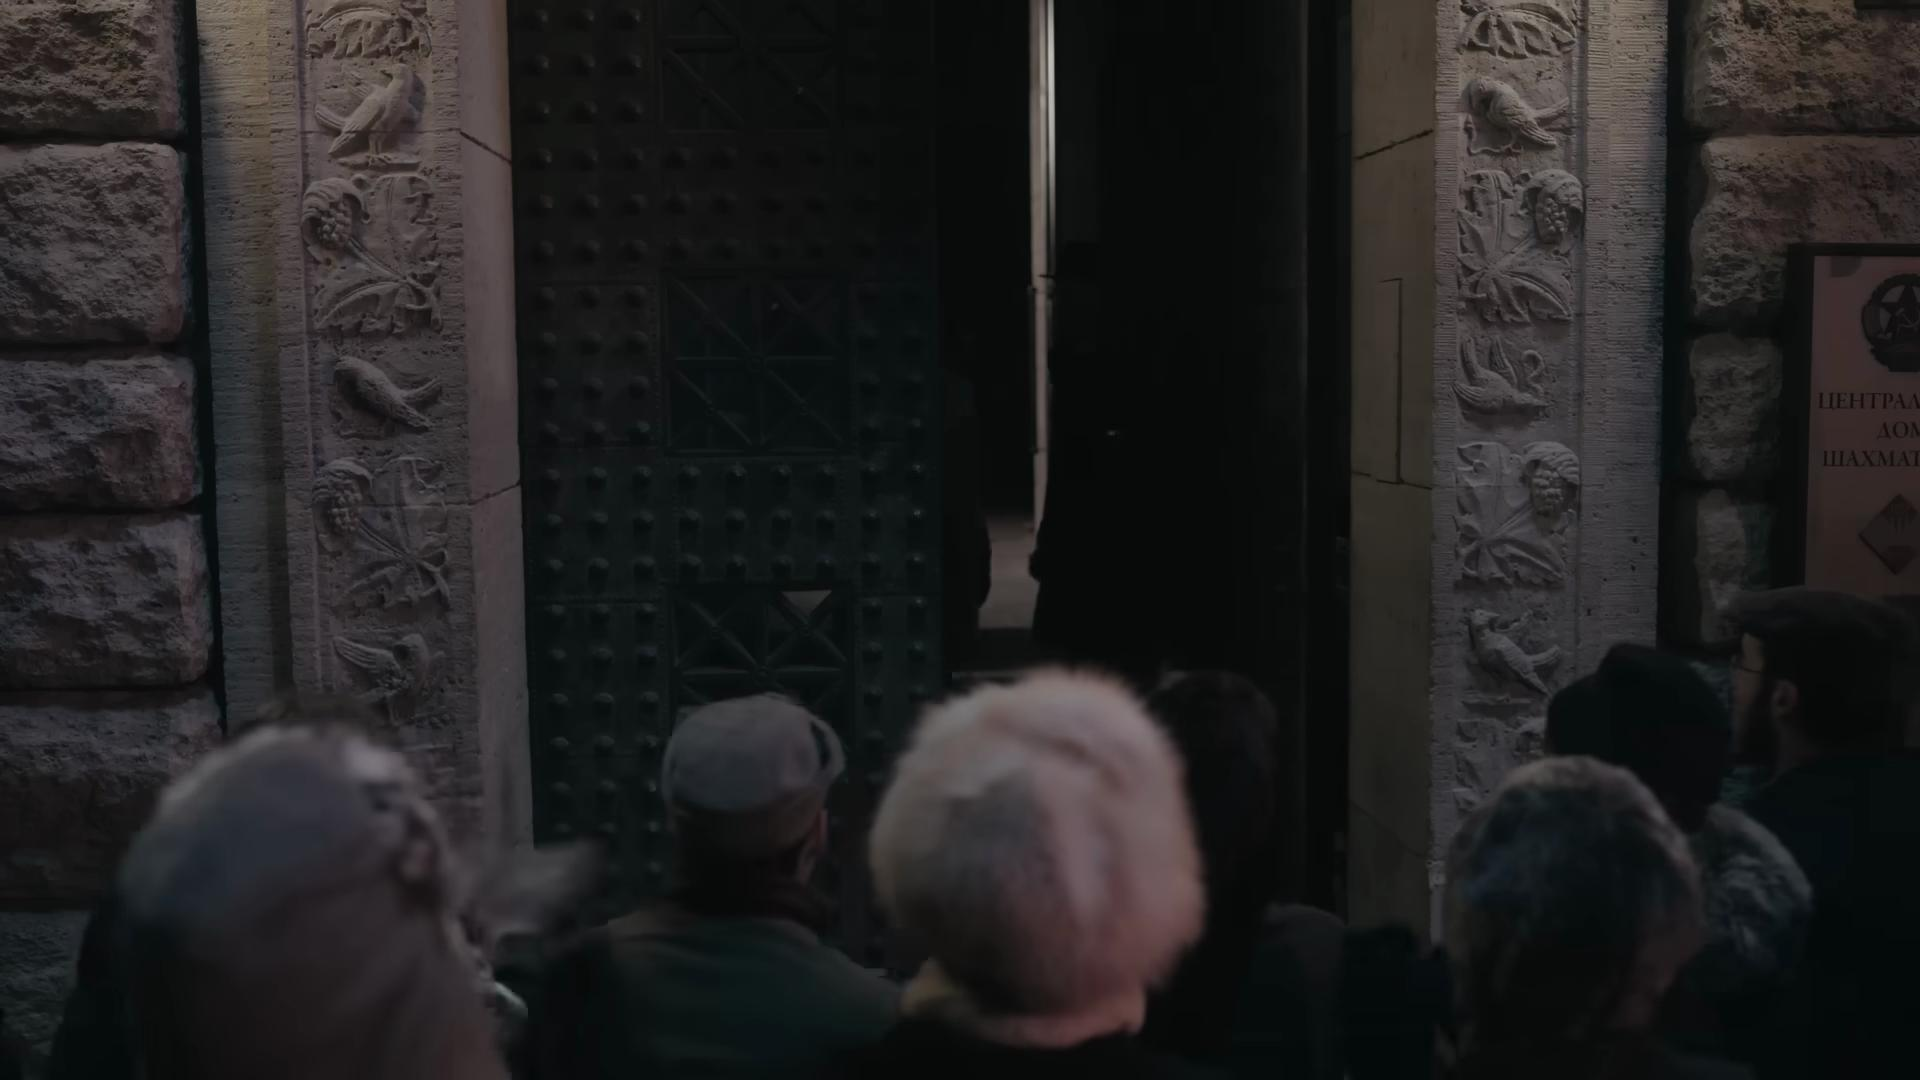
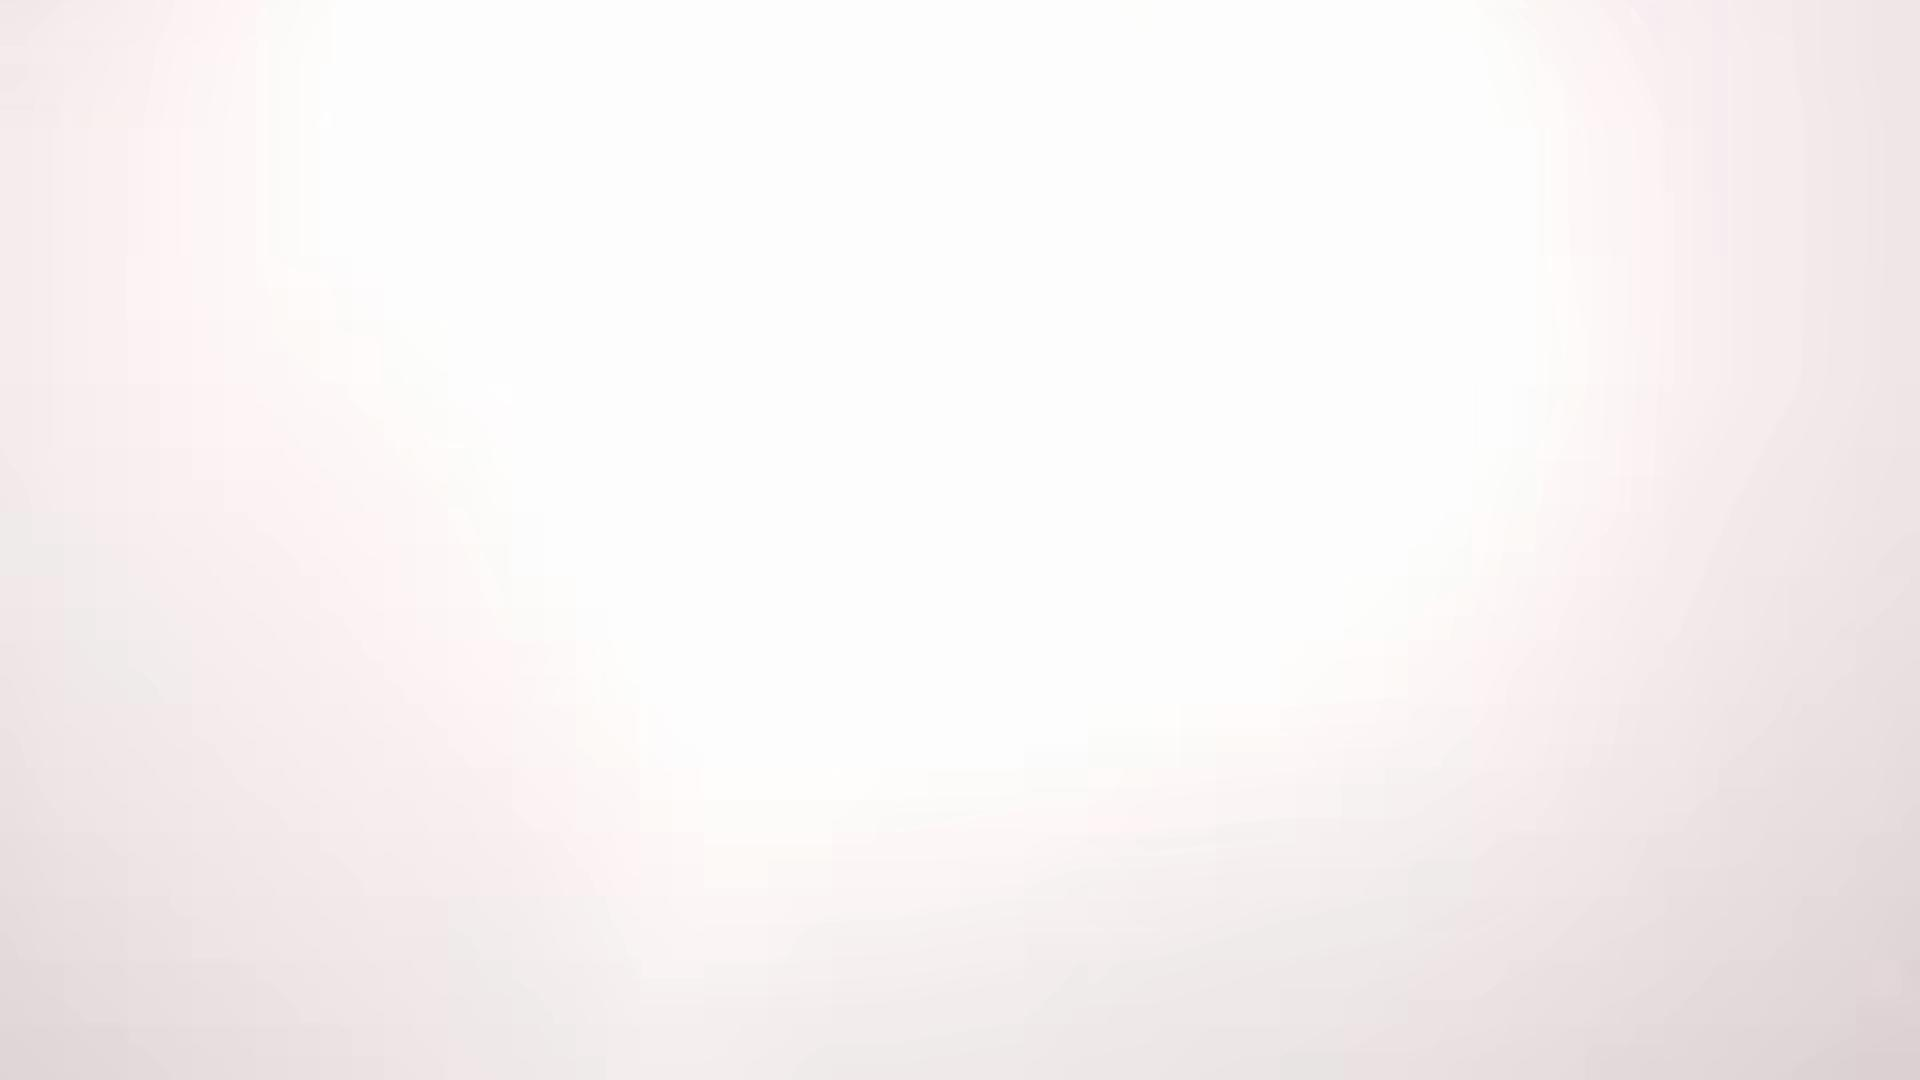
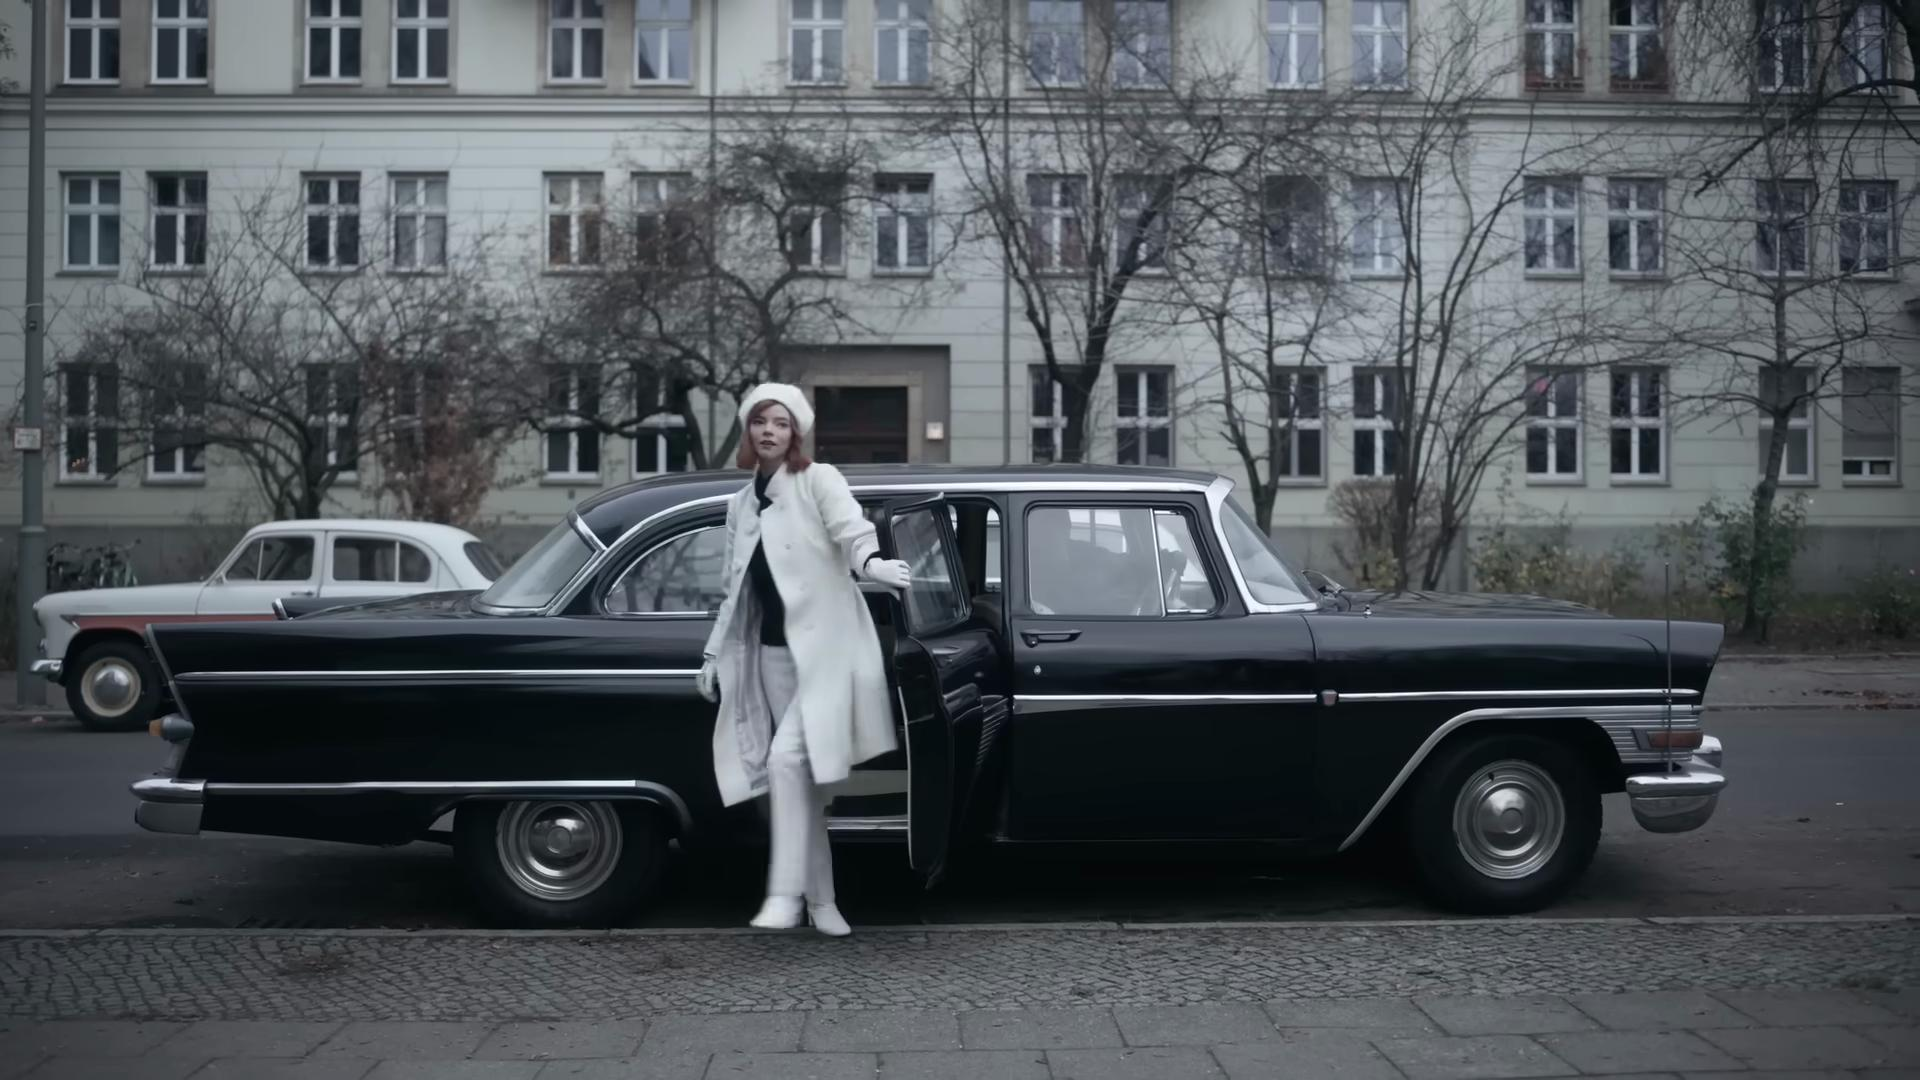
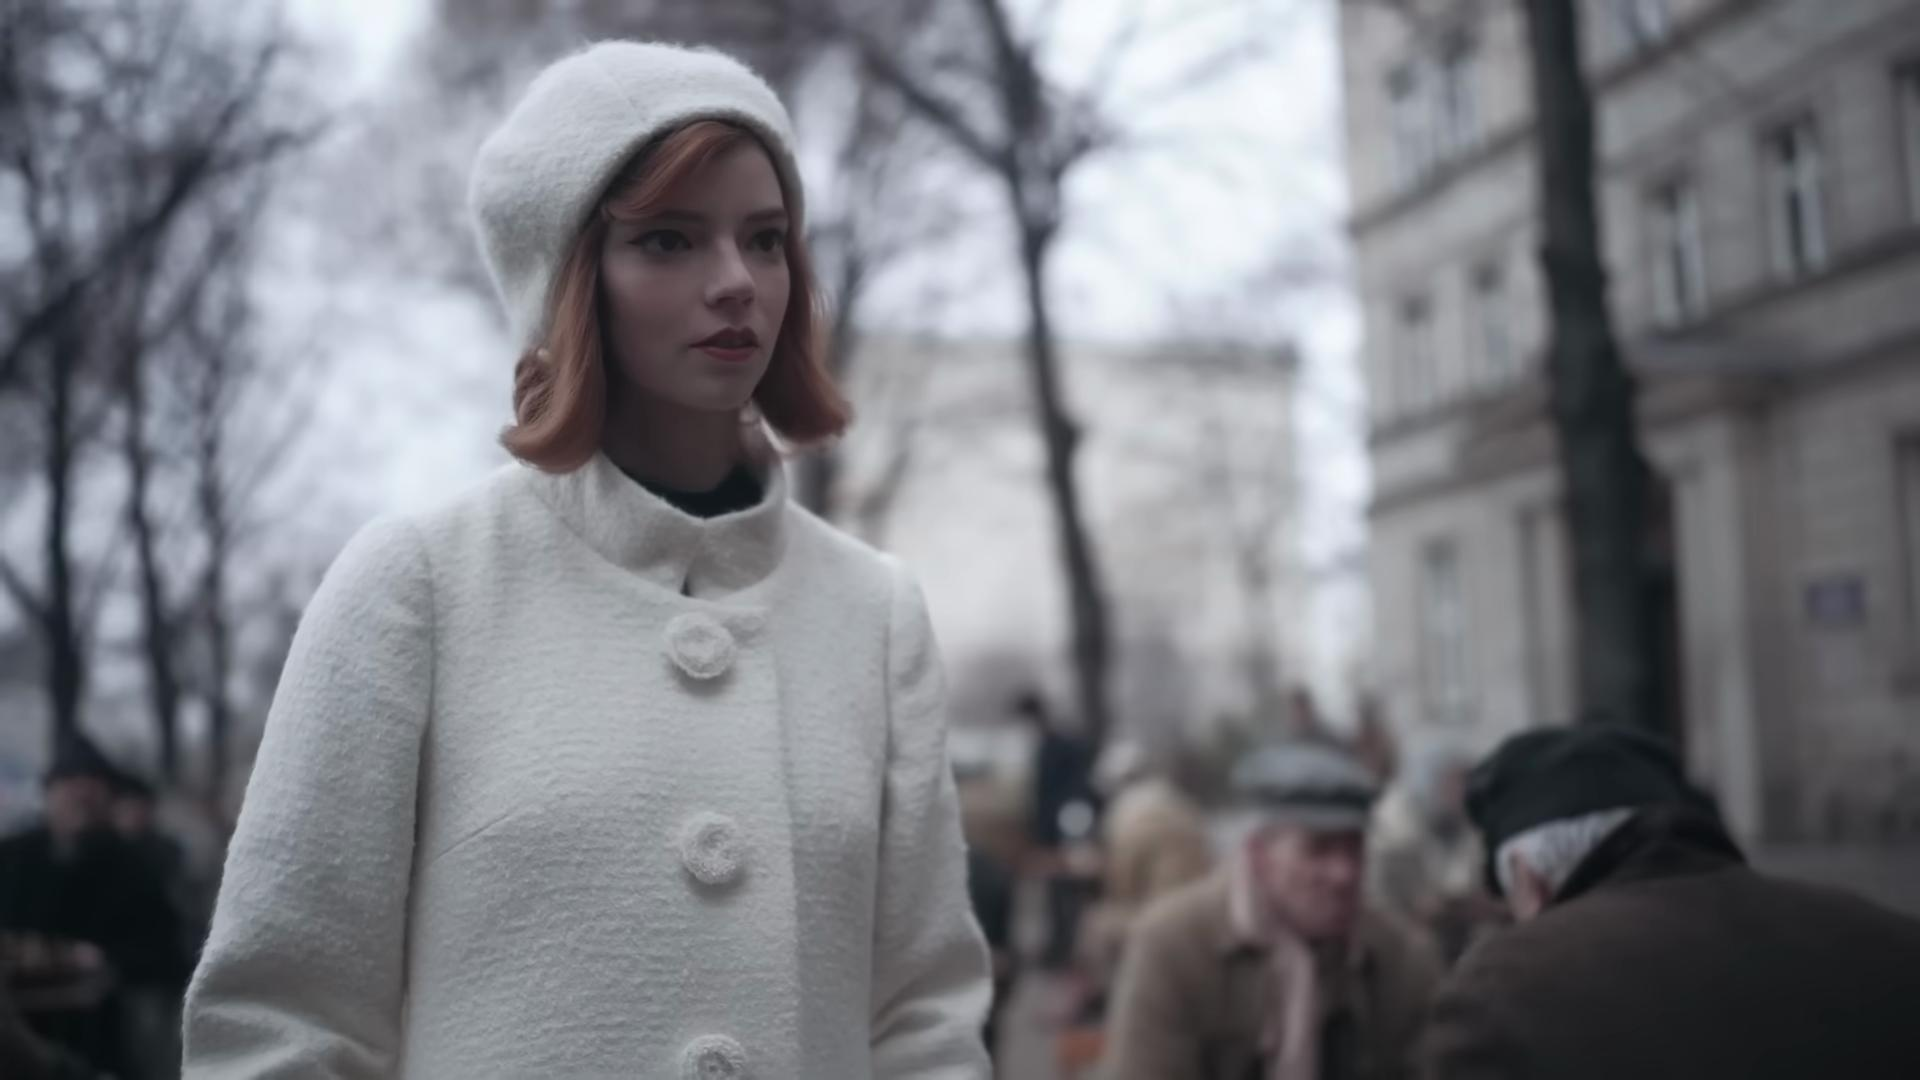
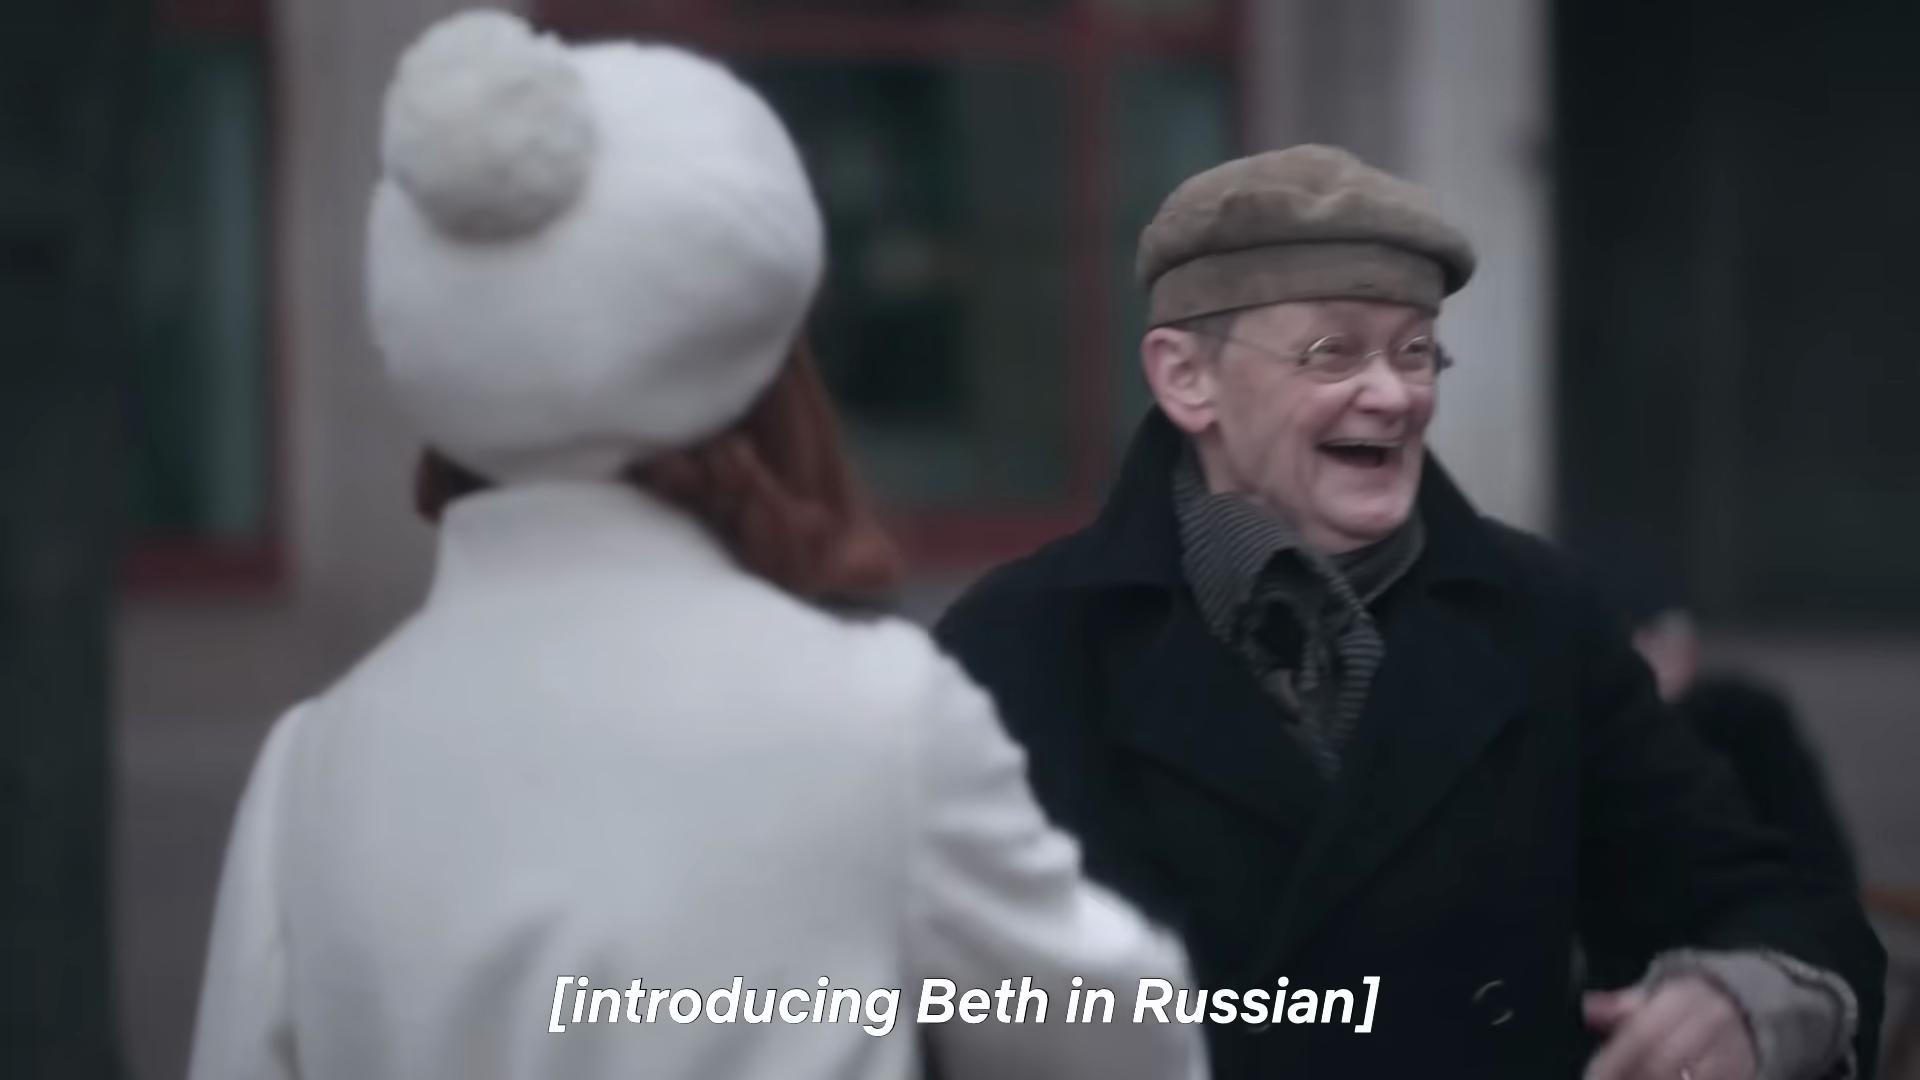
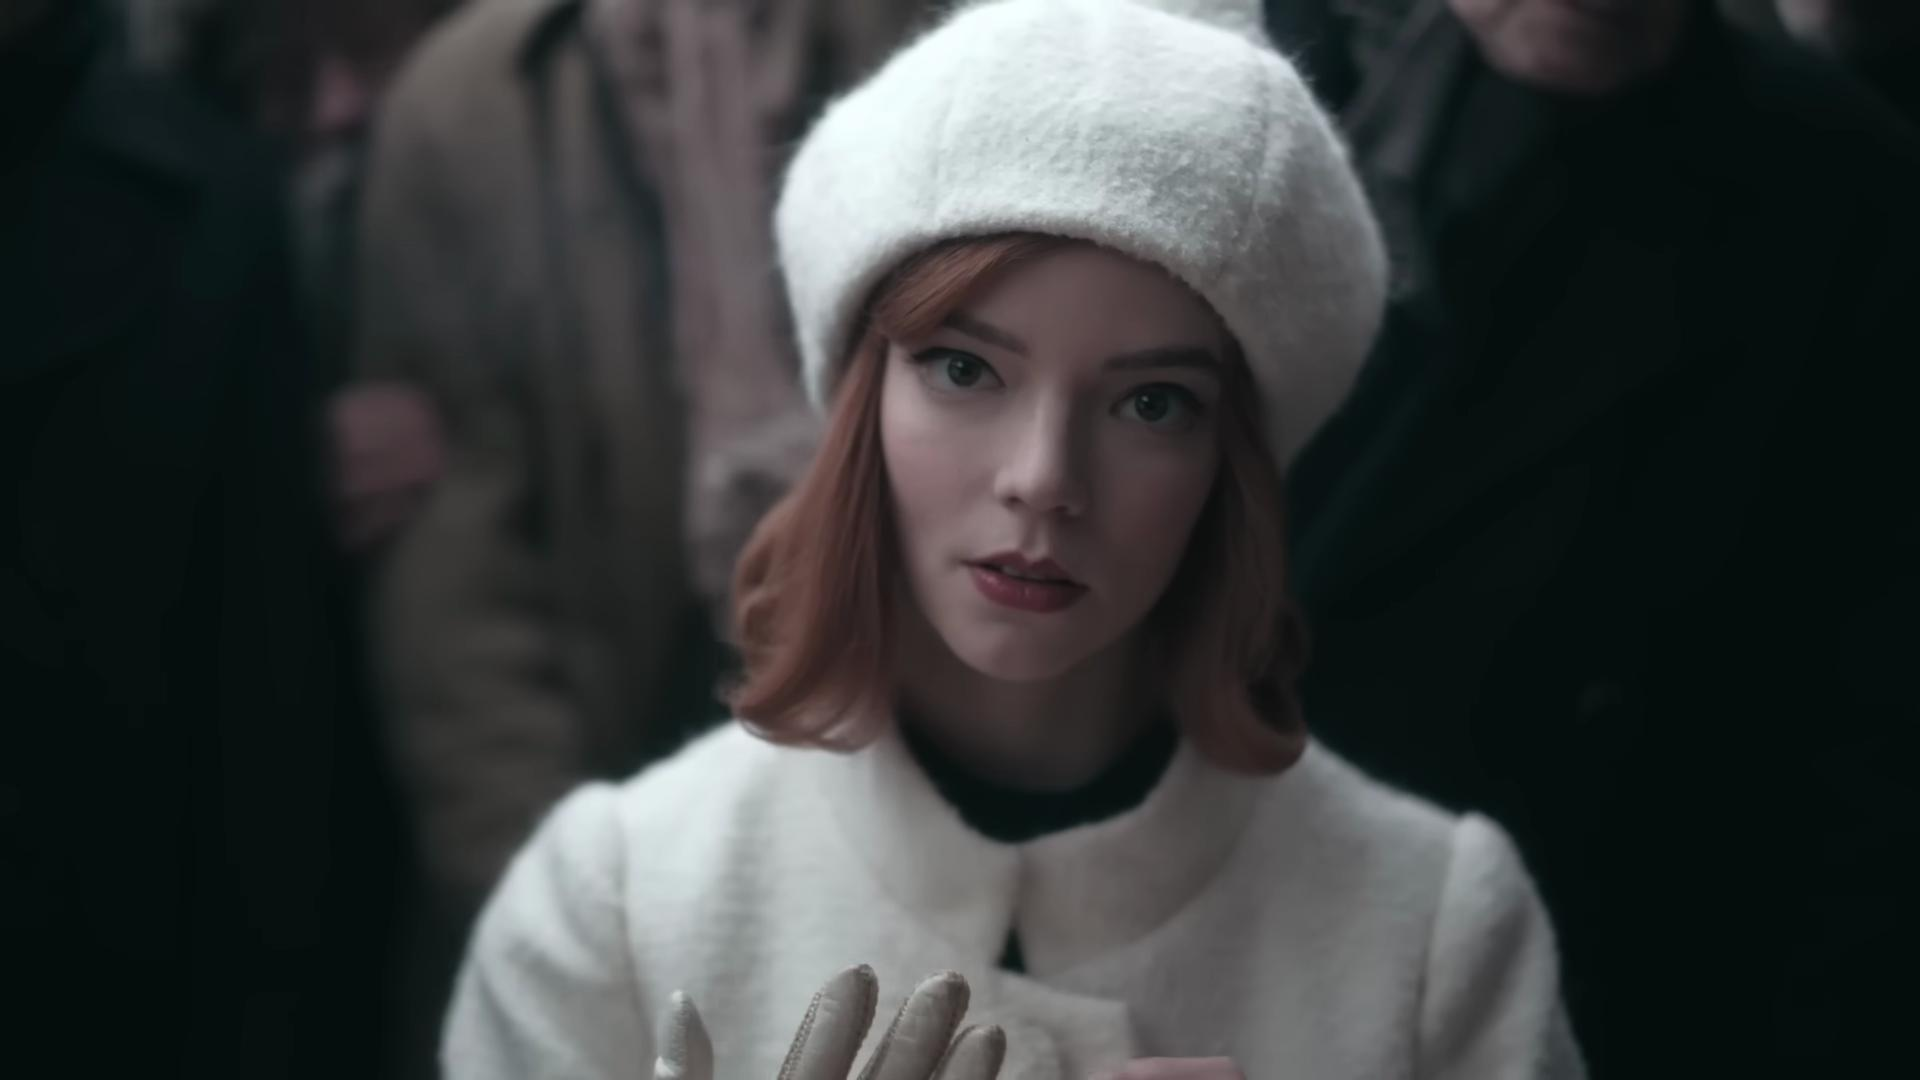

In [13]:
scenes.select(scenes.pos, scenes.video_segment, scenes.transcription).tail()

We can extract the text and language from the transcription JSON:

In [14]:
# Extract the text and language from the transcription JSON
scenes.add_computed_column(
    transcript_text=scenes.transcription.text.astype(pxt.String),
    if_exists='replace'
)

scenes.add_computed_column(
    transcript_lang=scenes.transcription.language,
    if_exists='replace'
)

Added 10 column values with 0 errors.
Added 10 column values with 0 errors.


10 rows updated, 10 values computed.

pos,video_segment,transcript_text,transcript_lang
0,,That check has been the whole point of the sequence beginning with the bishop cutting down the slope of the book by forcing it to a last threatening left. Question is... What will she do now?,en
1,,А вы мы рев,ru
2,,It's your game. Take it. Up ahead. Song Lagoon Did you see that?σت tanta assists HIretchdio Ho Right It is your game. You have to take one. Return his spine.,en
3,,"Thank you. Good for you, Crackle. Good for you.",en
4,,,en
5,,"The President has invited you to the White House. There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass. Texas being more of a checker state. There's a dinner tonight after the reception at the Russian chess club in Georgetown. A lot of prominent visitors belong, so I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. Just for the important visitors belong. So we prepared a list of talking poets. It's a big deal, beating the Soviets at the wrong game. Could you stop the car, please? I'd like to walk. To the airport.",en
6,,"You're gonna miss the flood? Come on. Come on. Lisa, come on.",en
7,,Daddy? Harun mu?,tr
8,,l'espace�니다.,fr
9,,Обц tungр ТРЕВОЖНАЯ МУЗЫКА,ru

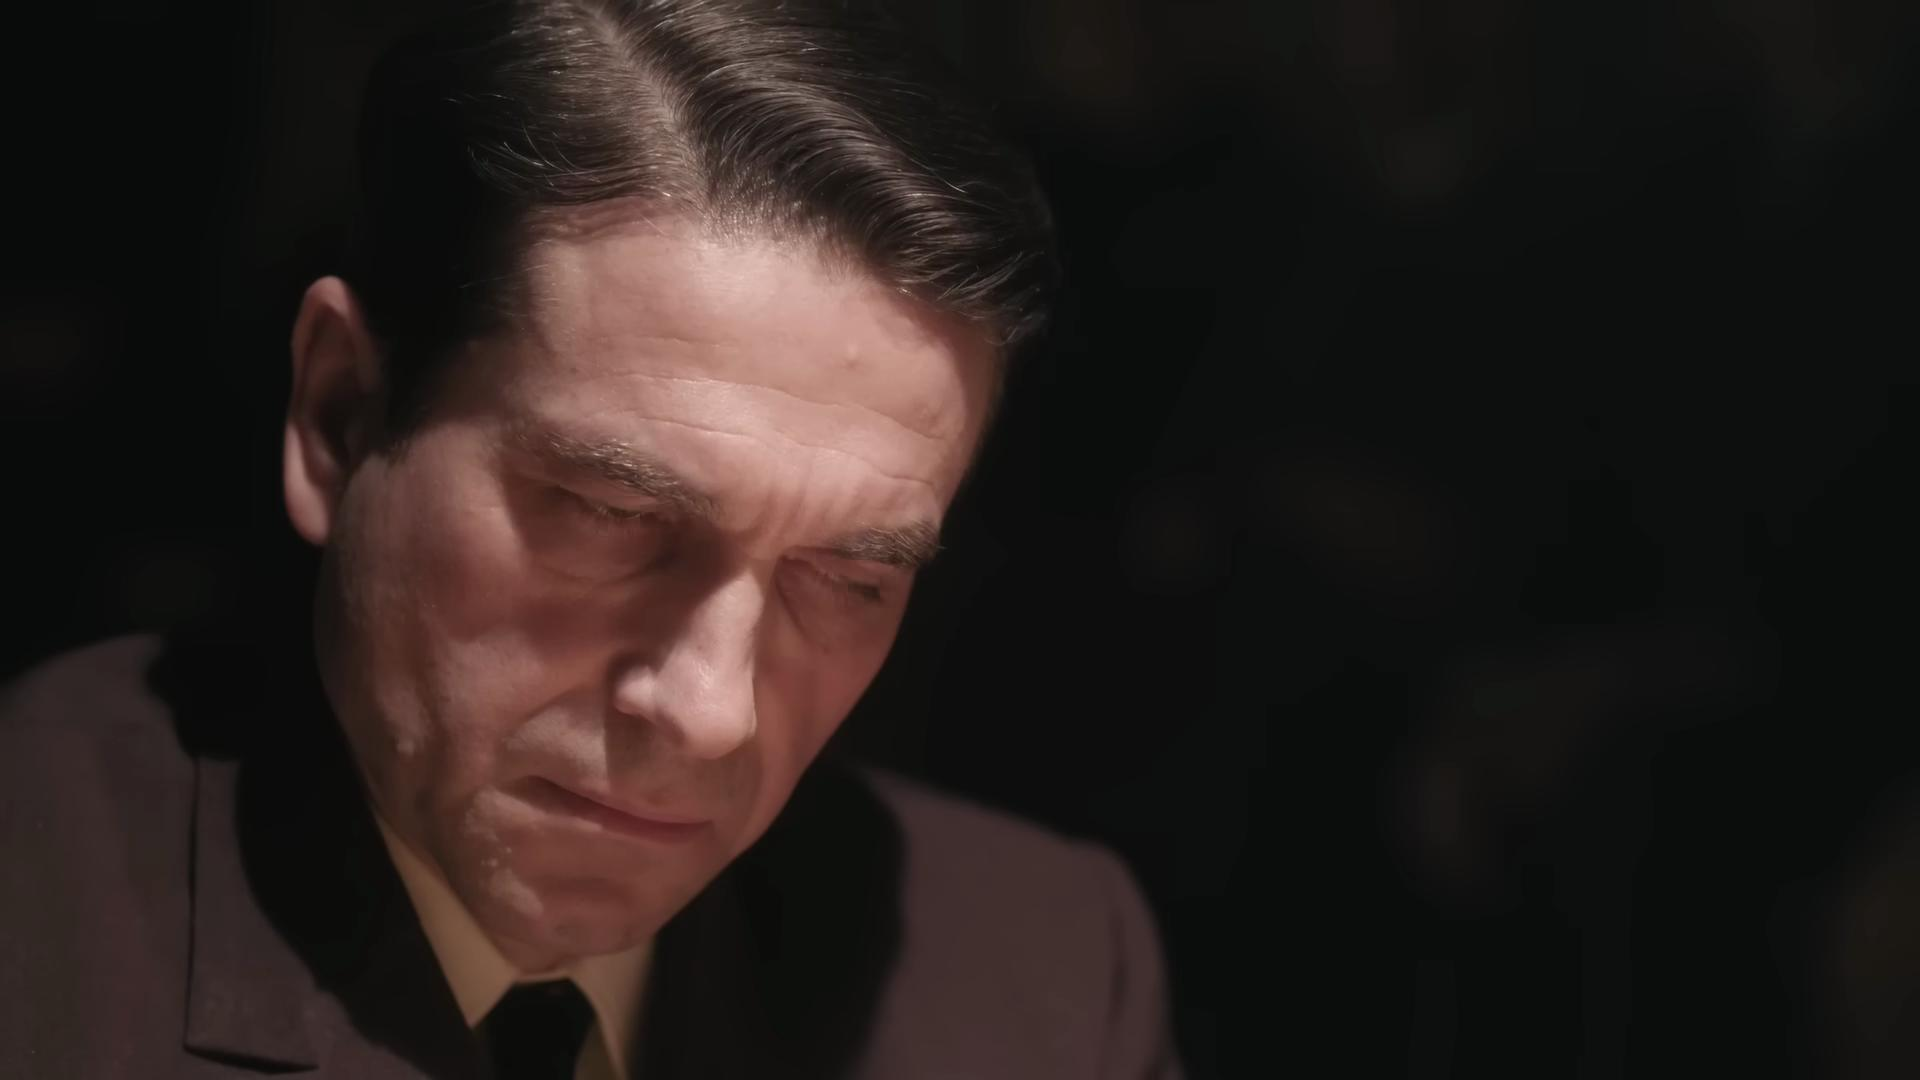
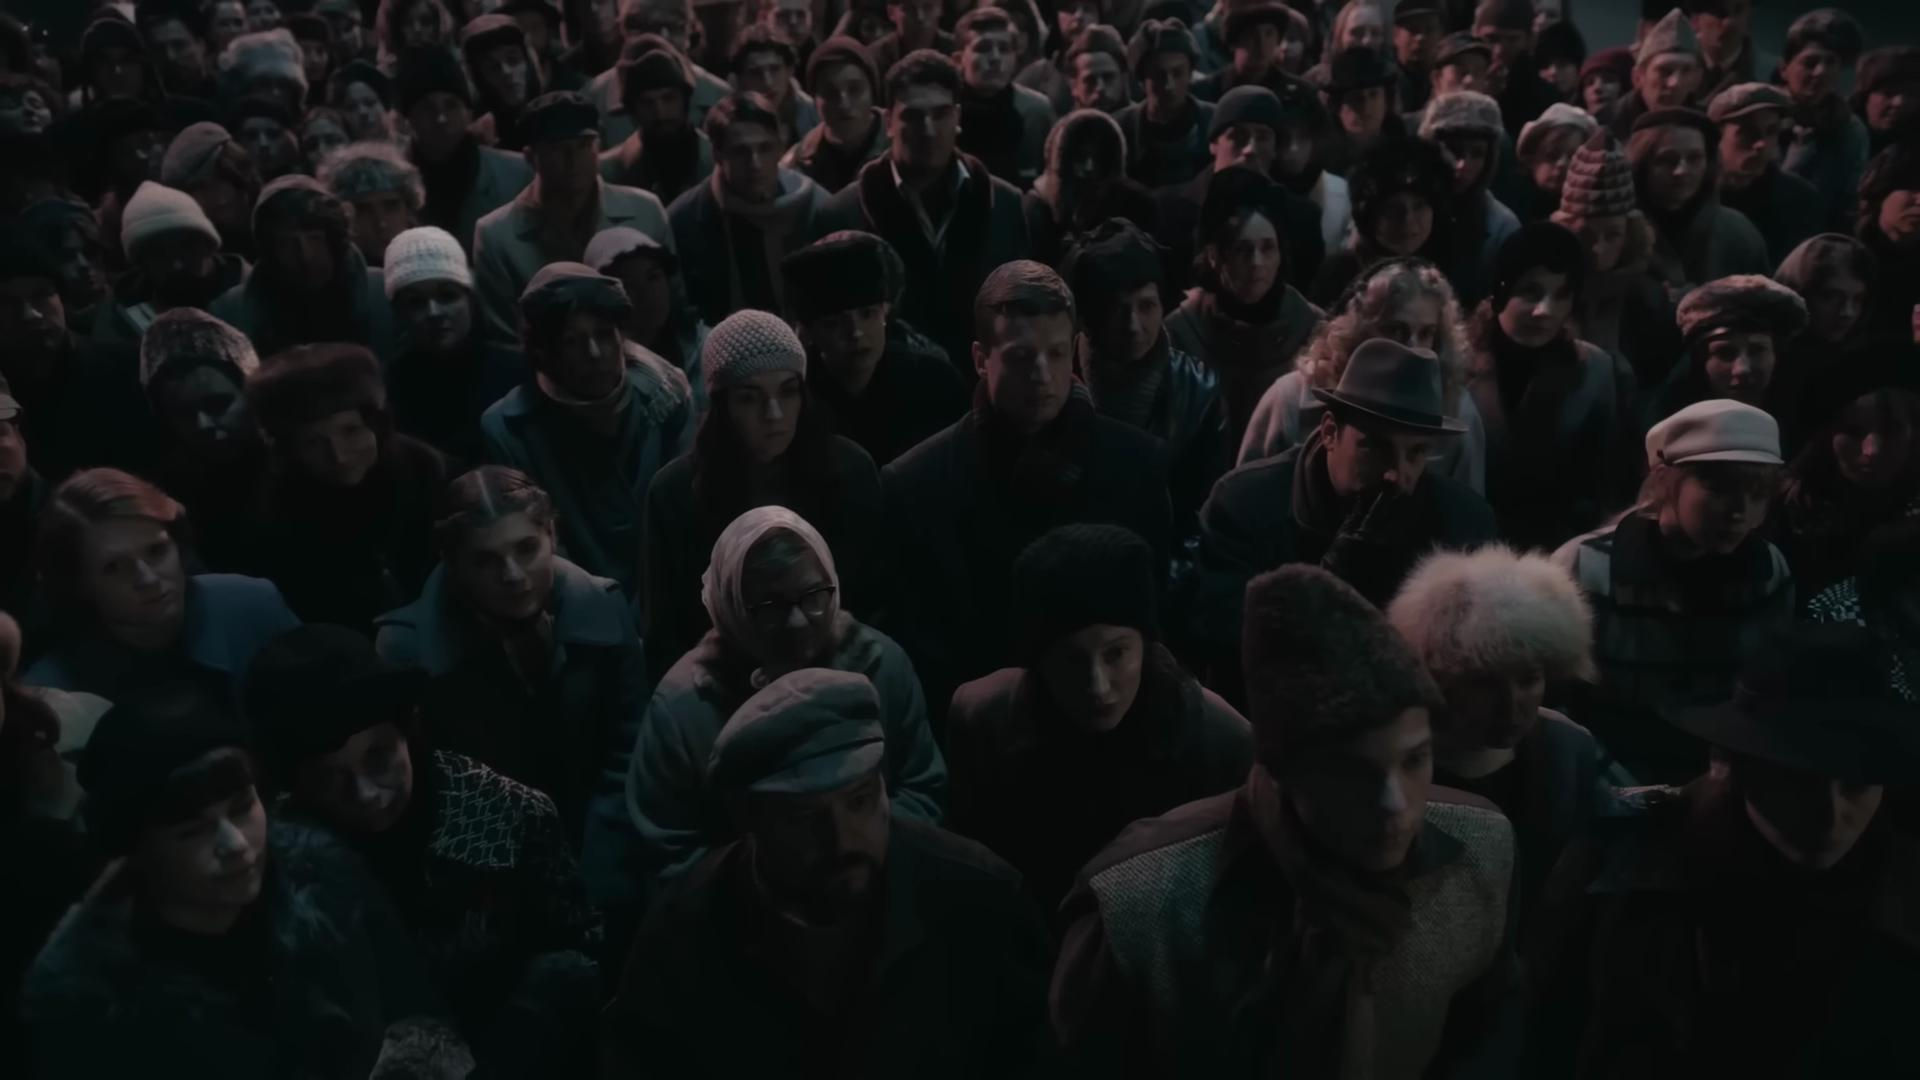
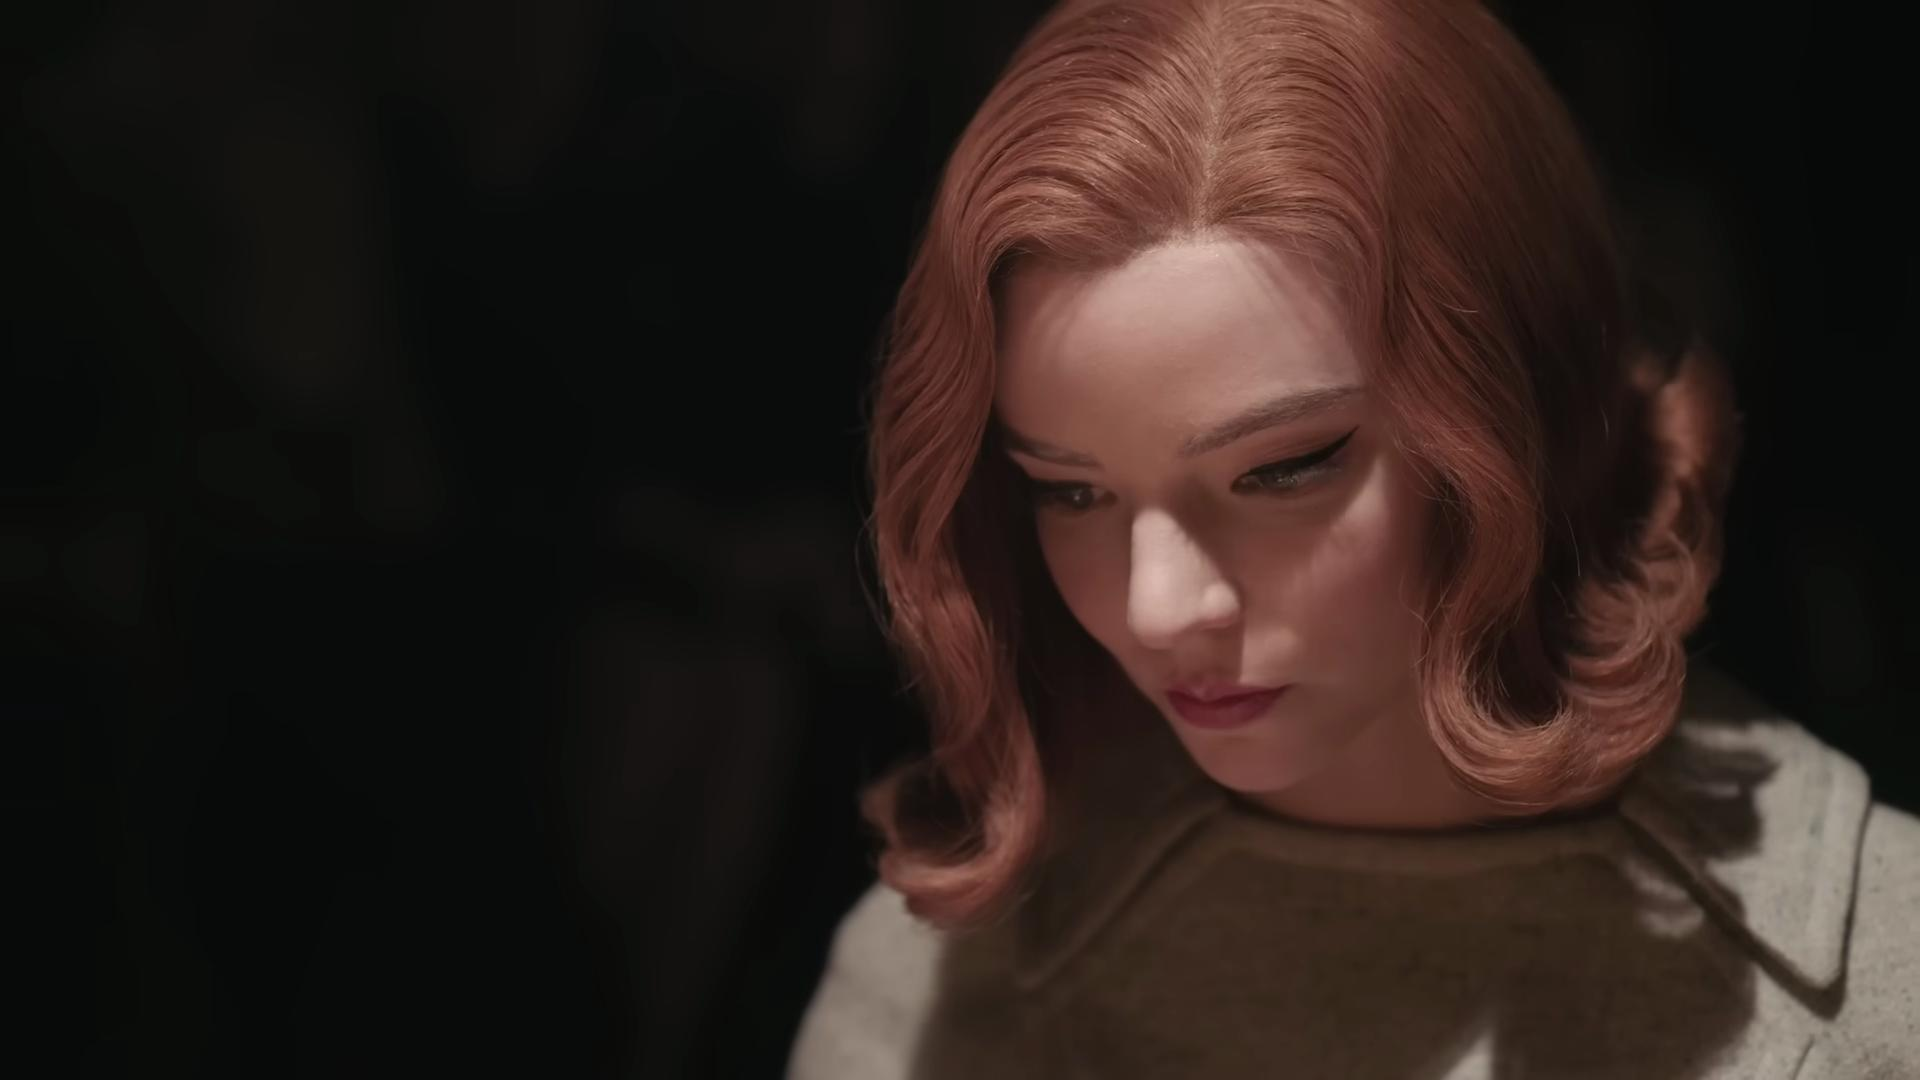
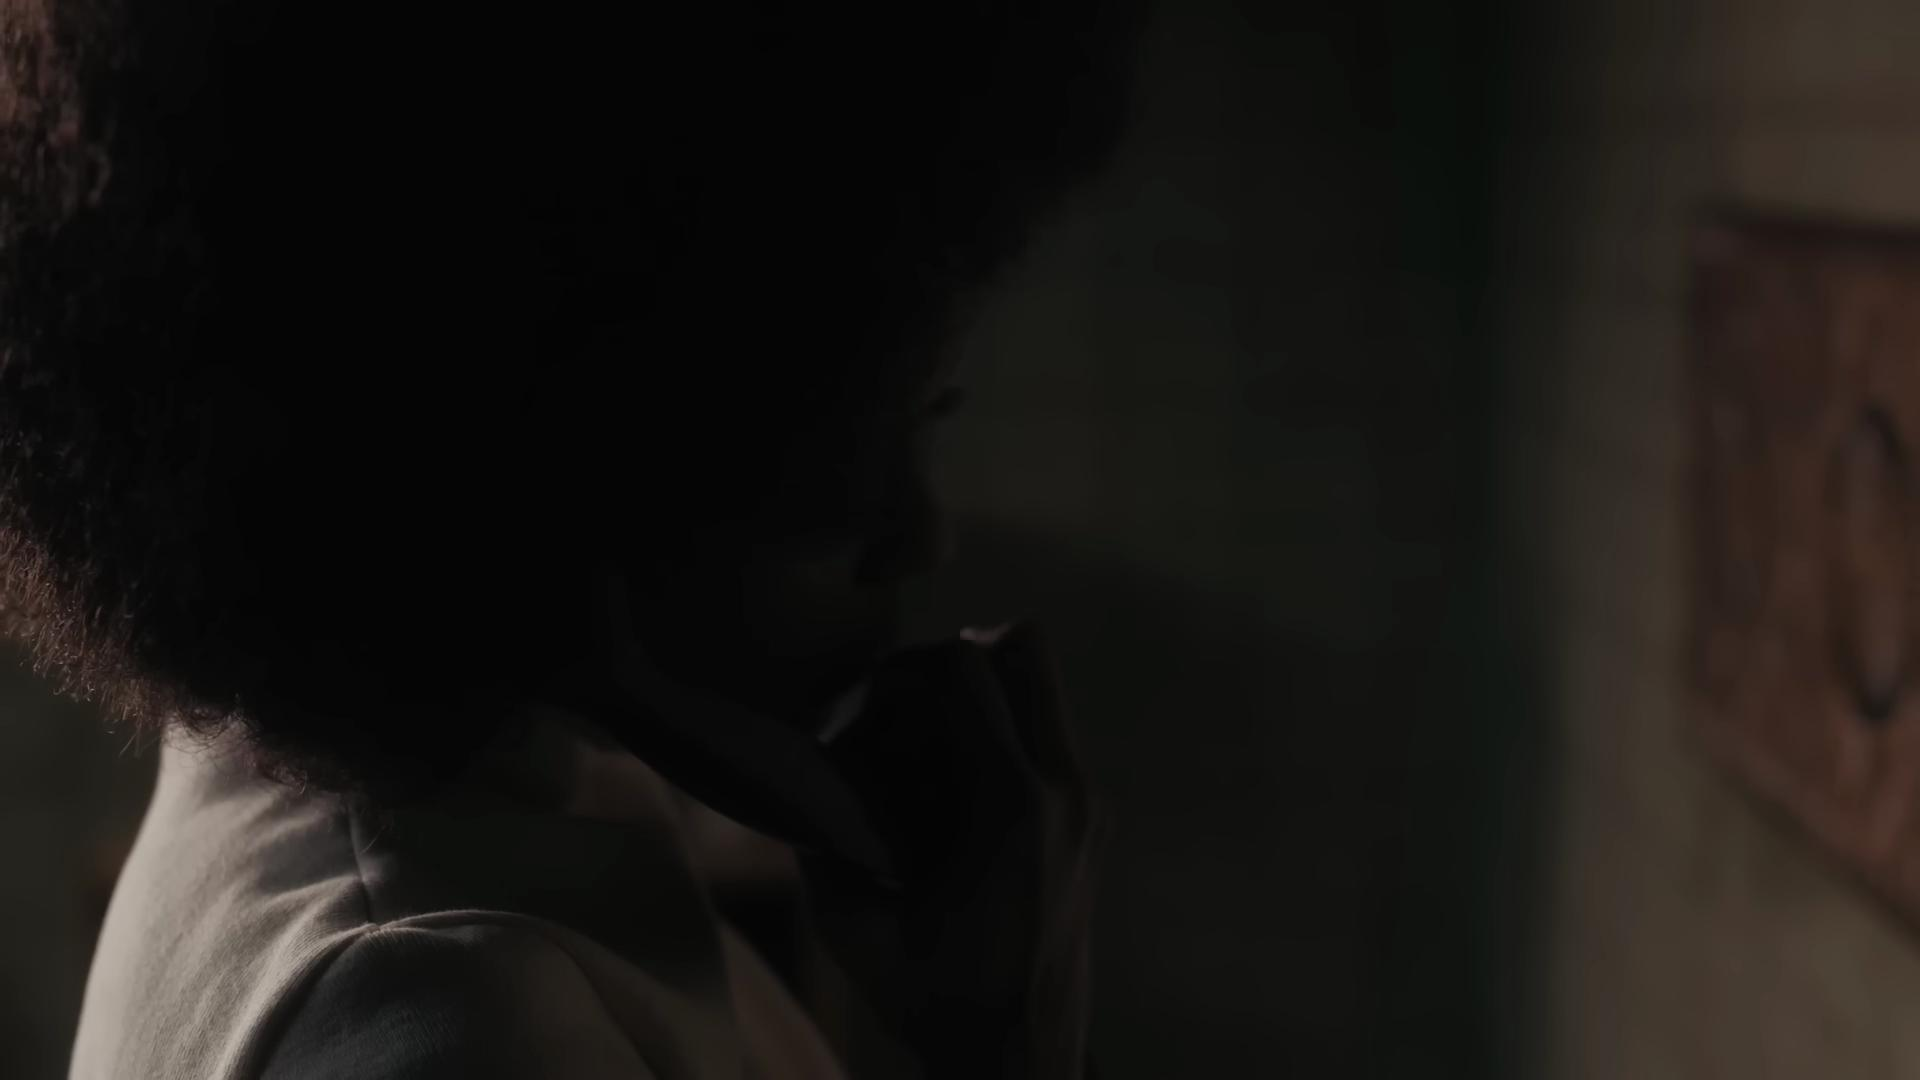
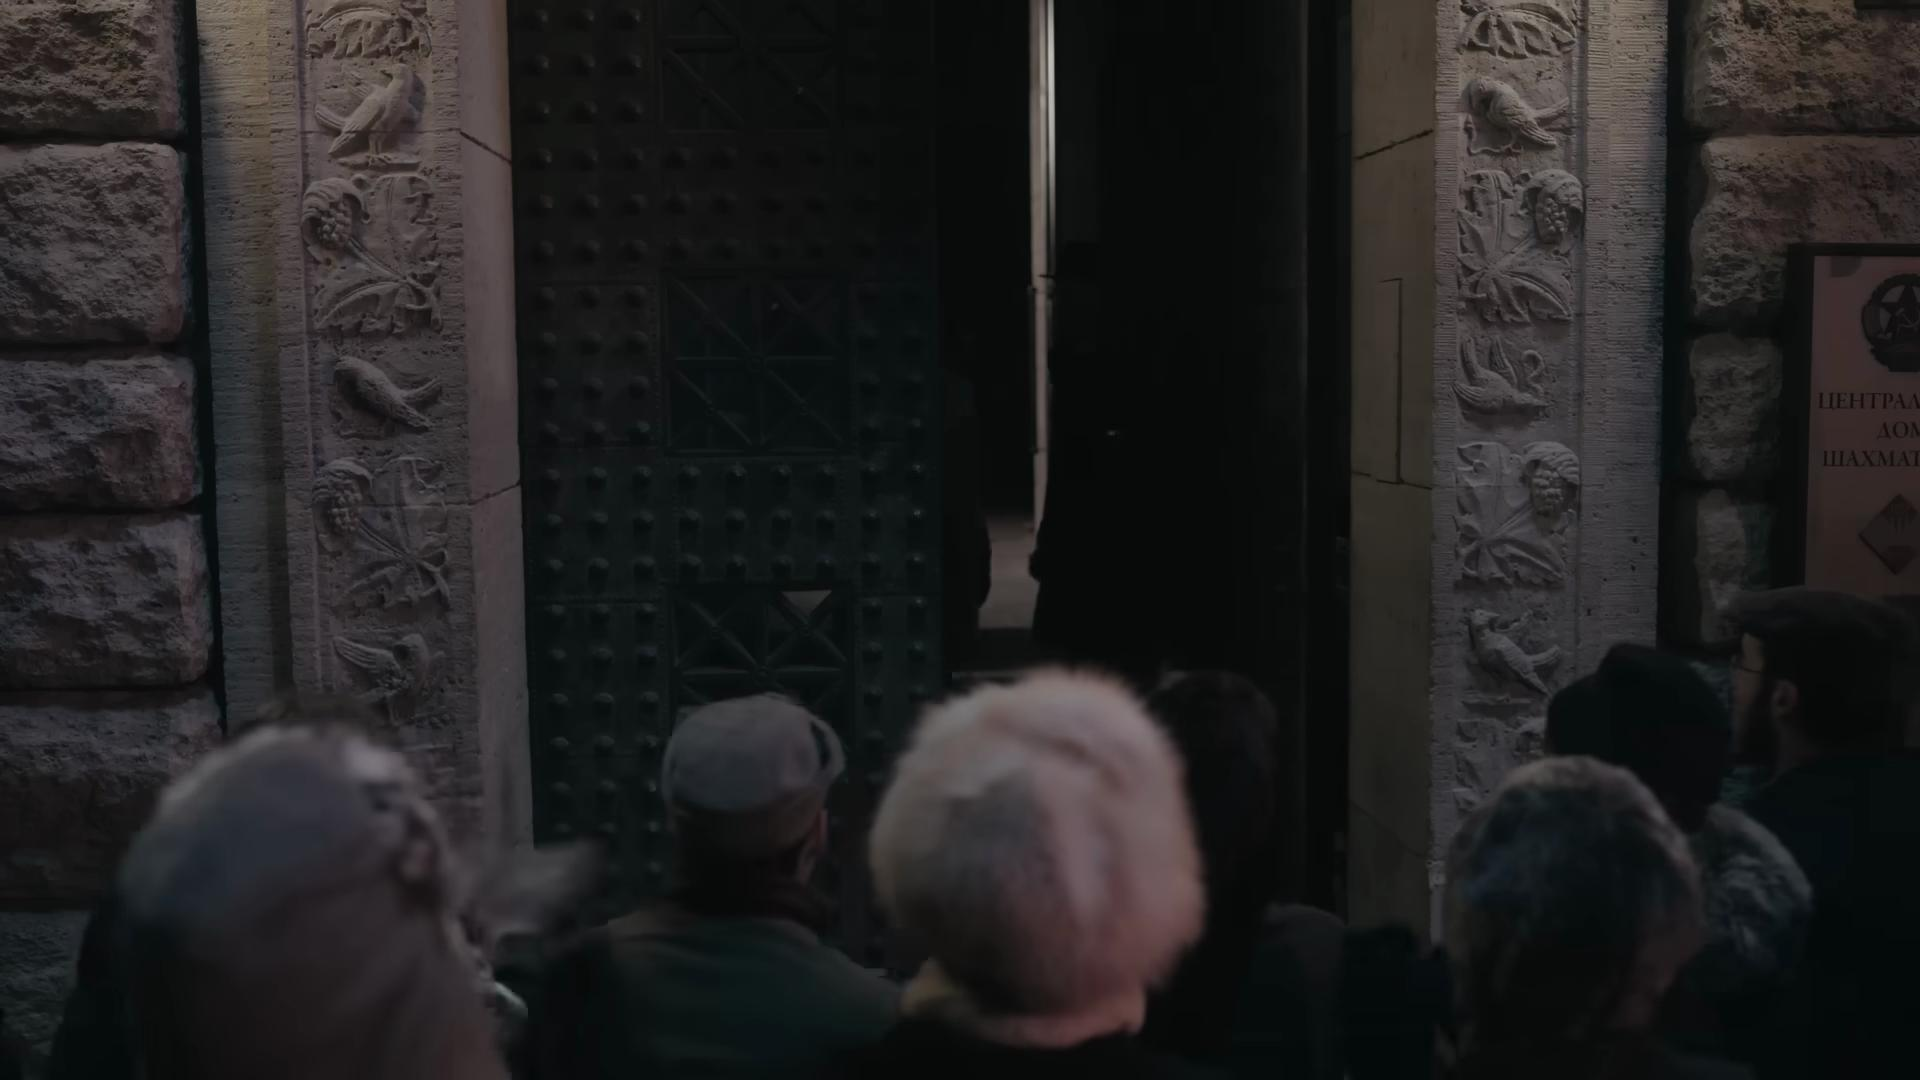
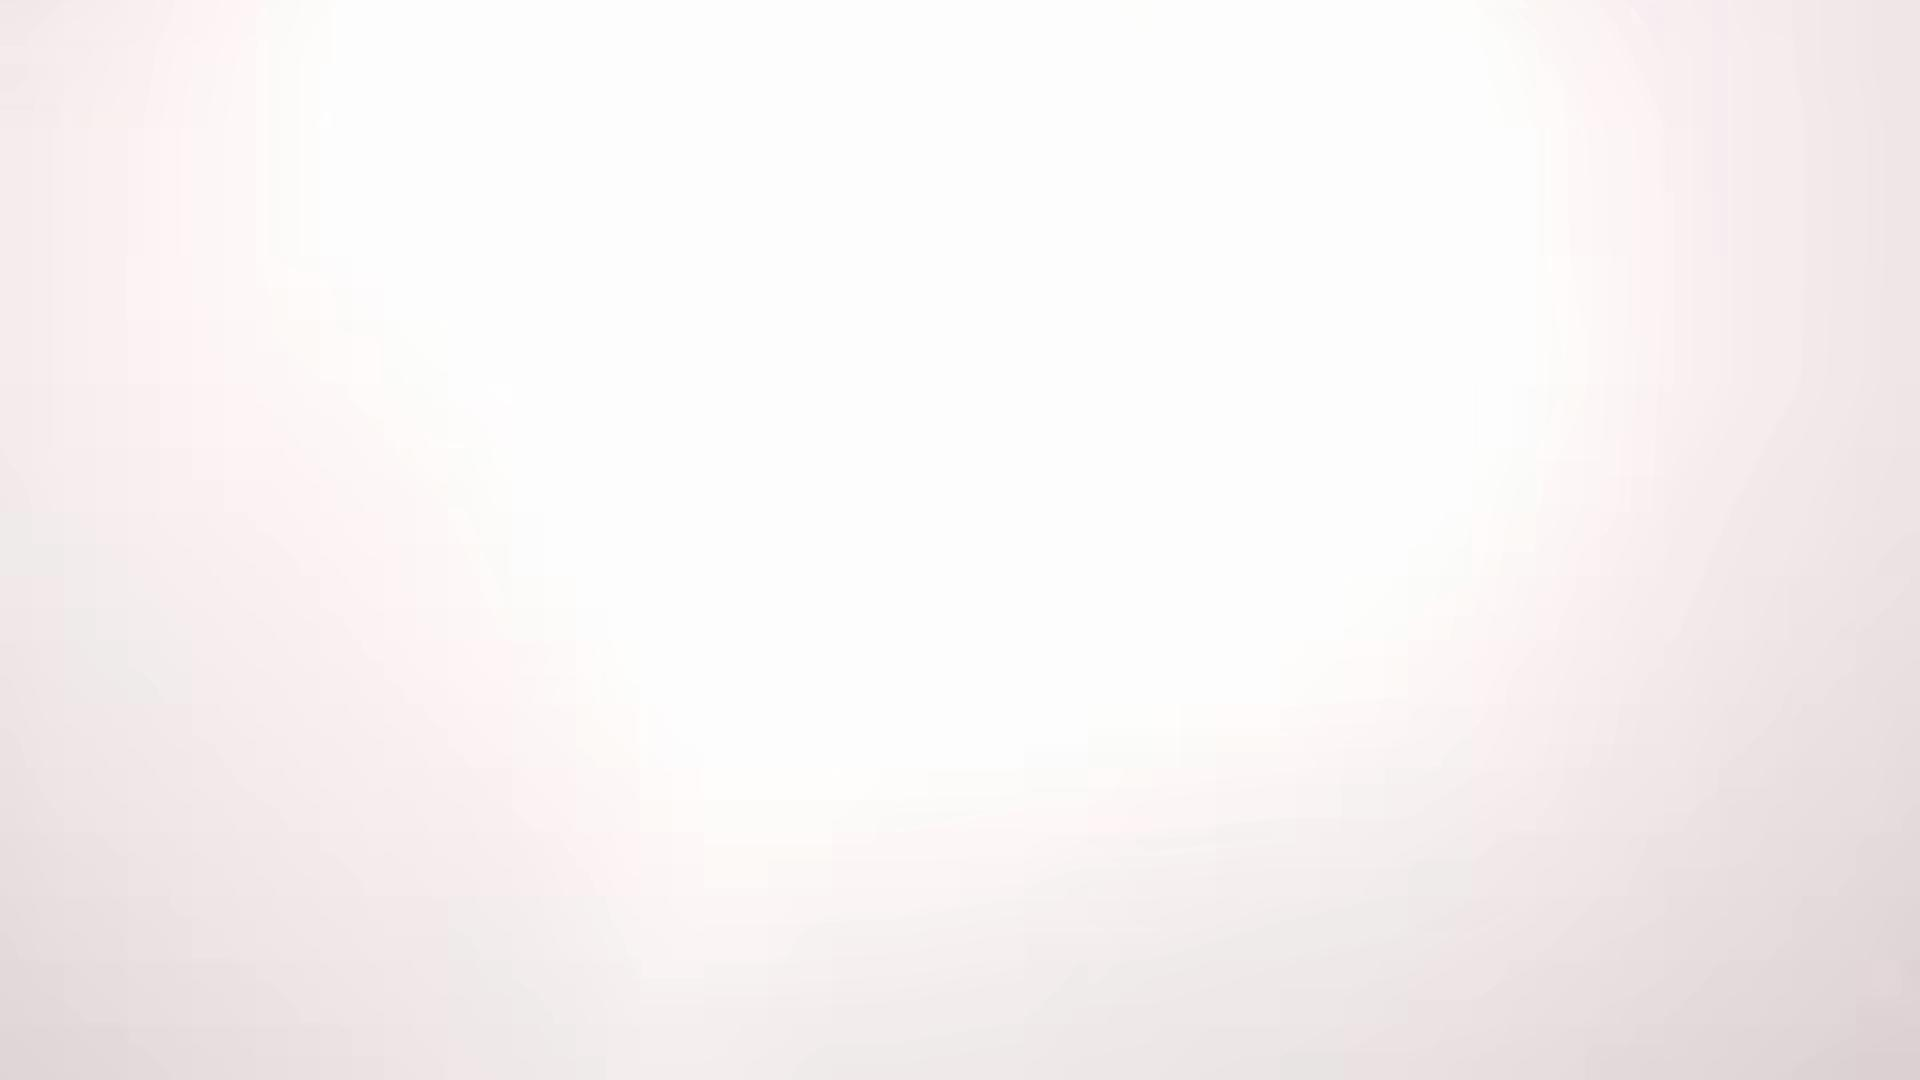
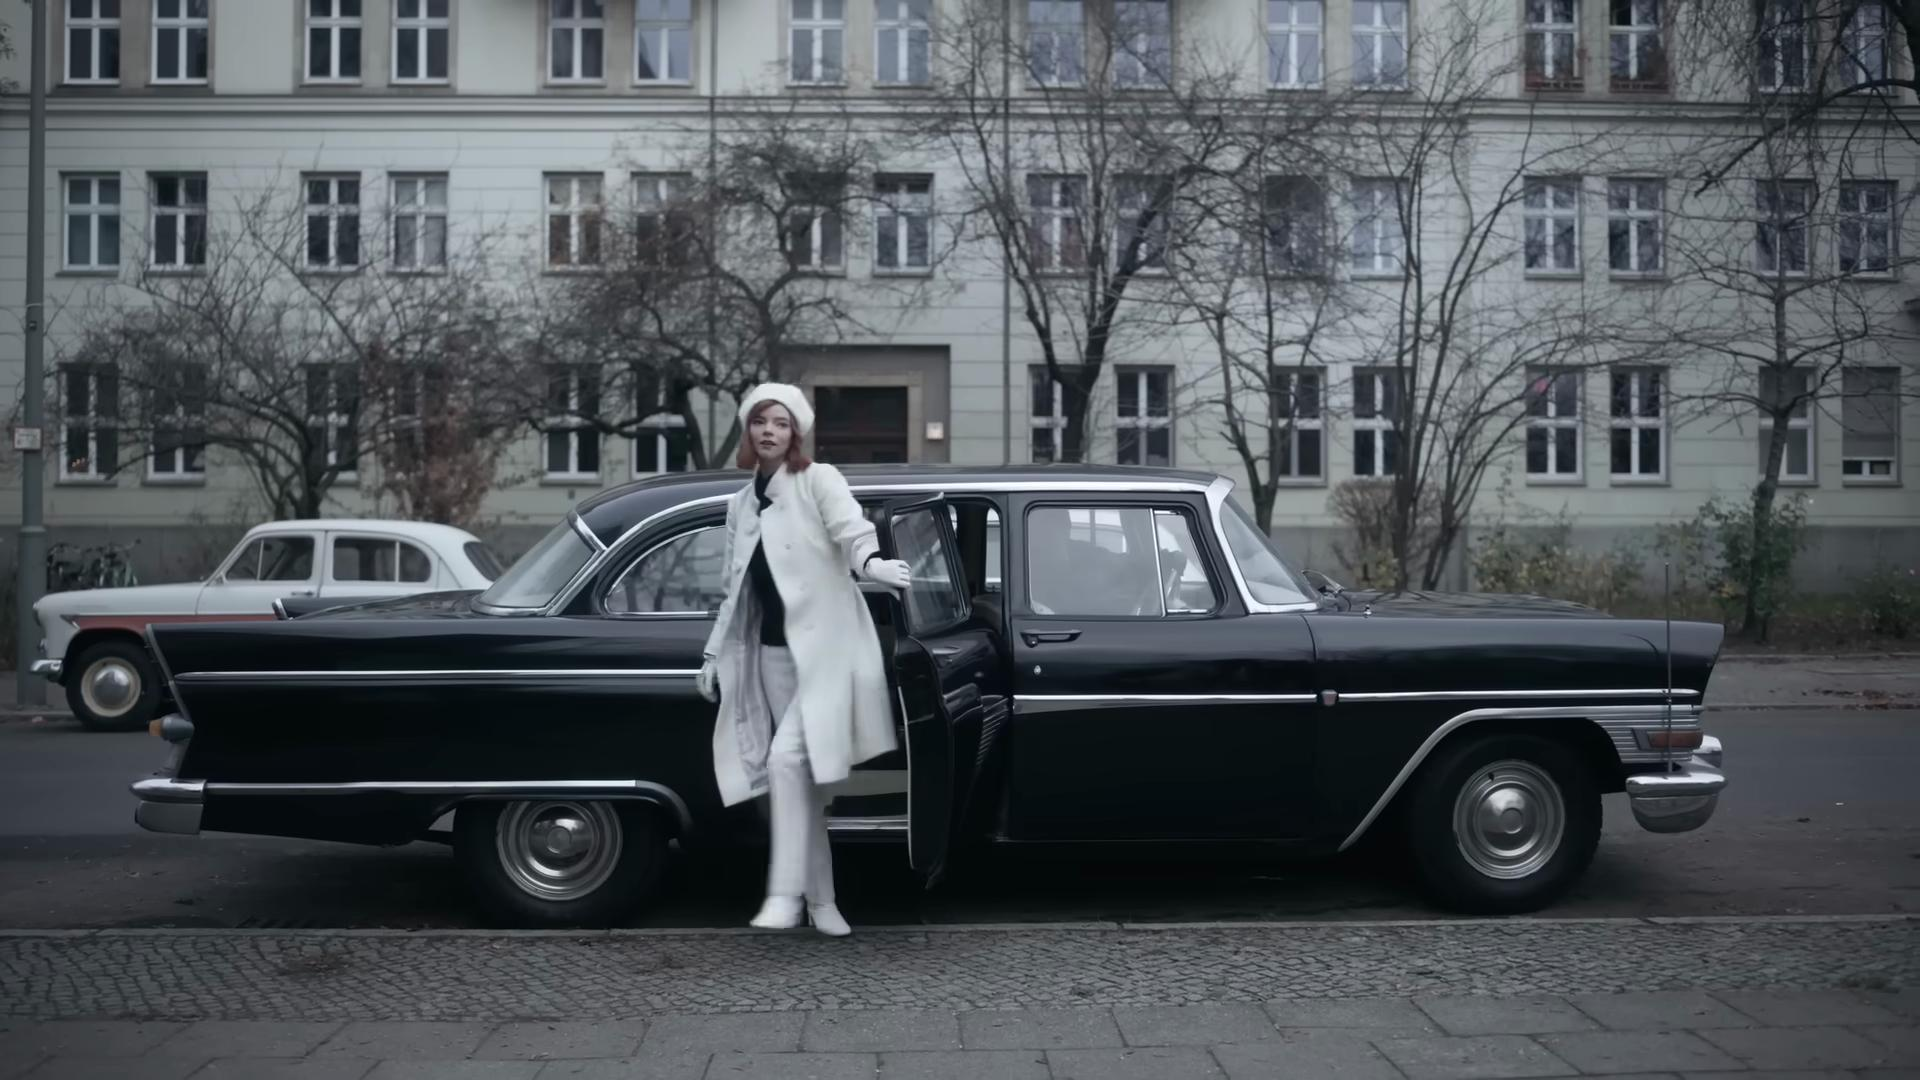
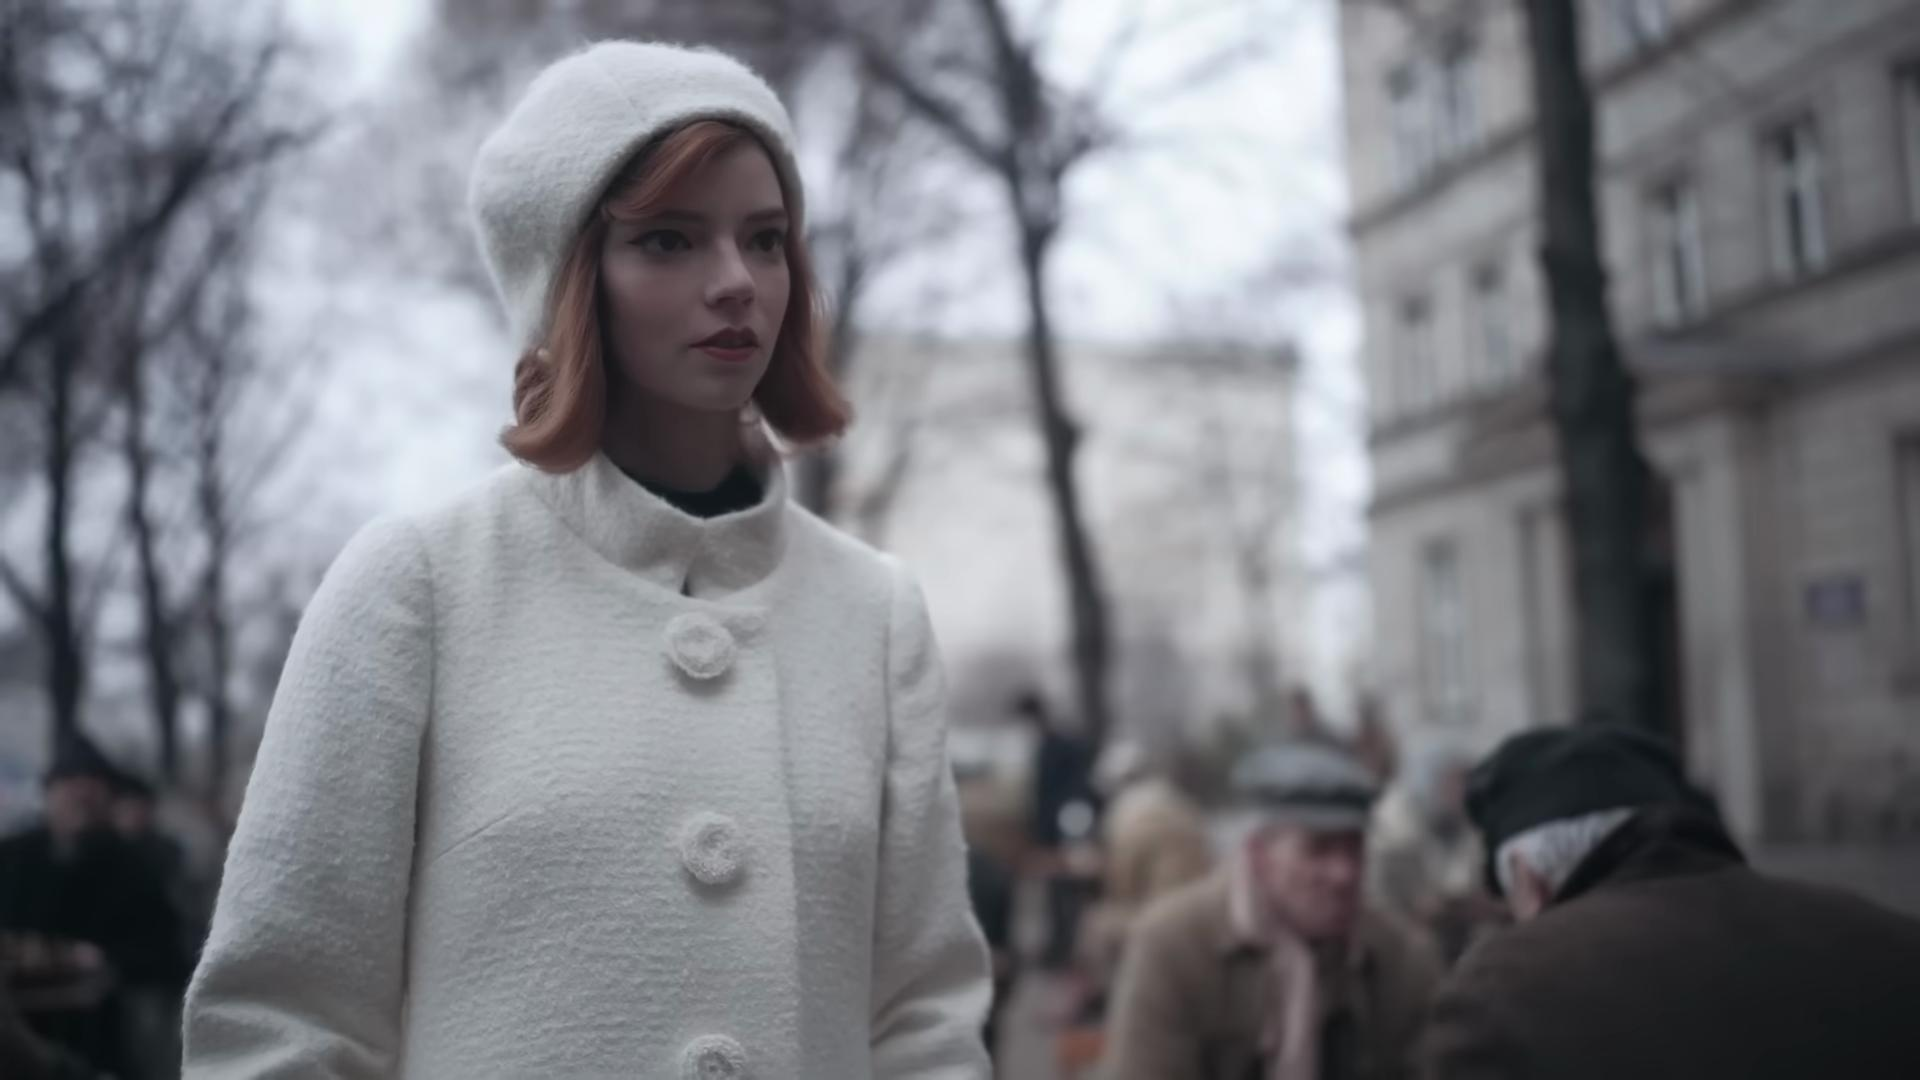
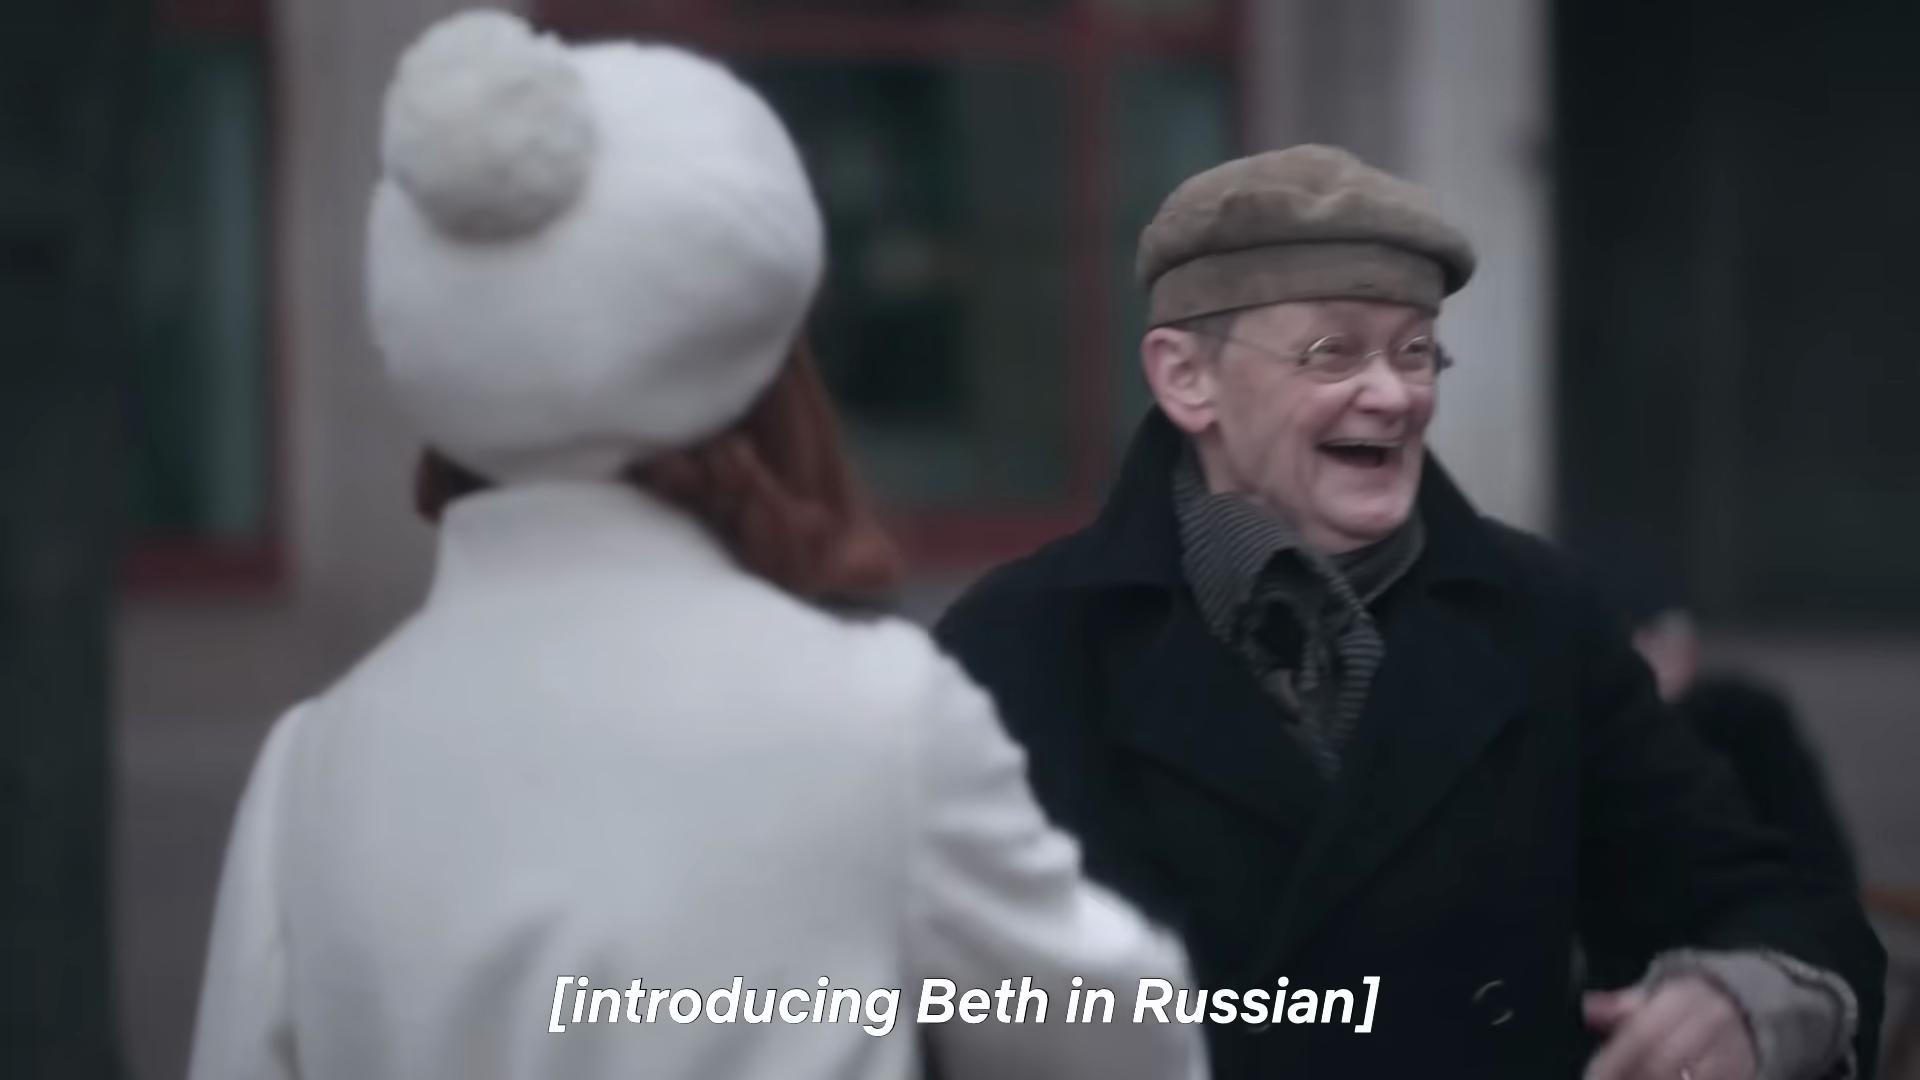
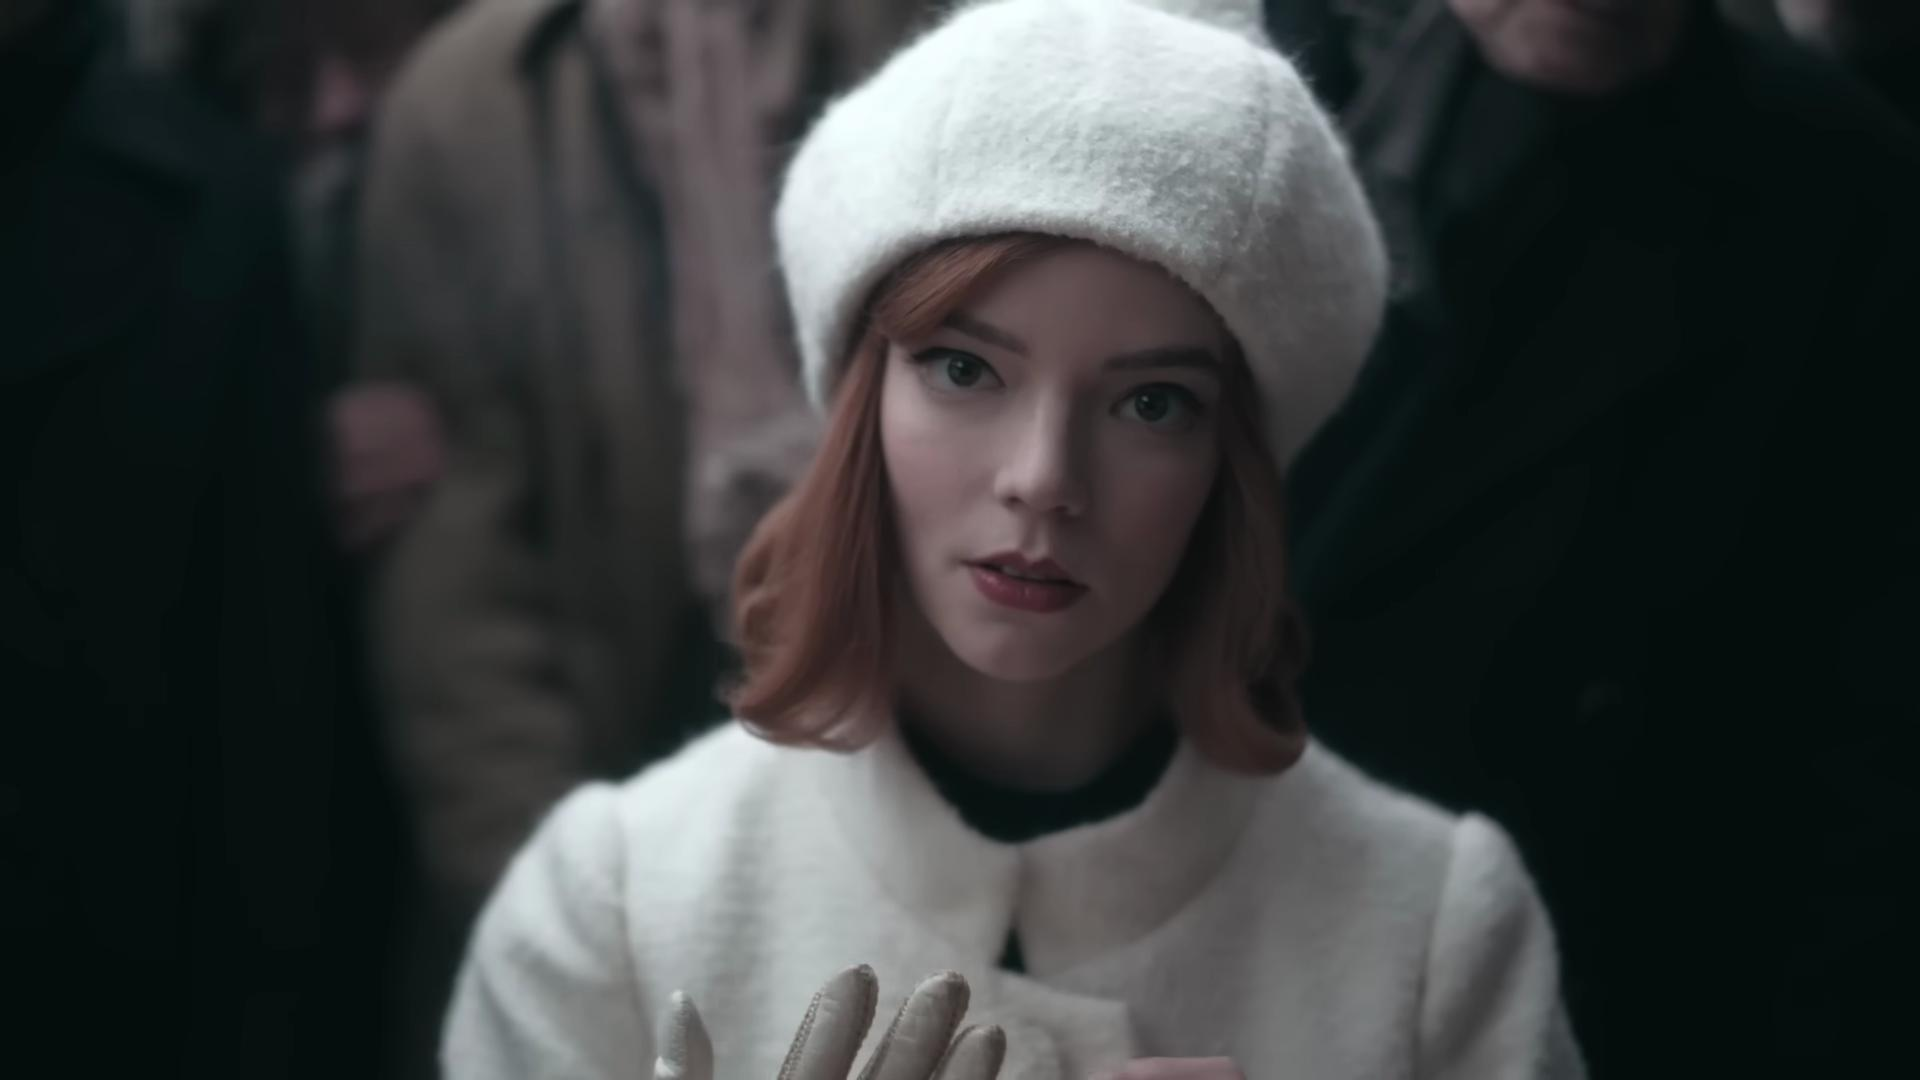

In [15]:
scenes.select(scenes.pos, scenes.video_segment, scenes.transcript_text, scenes.transcript_lang).tail()

### Create Embedding Index & Search

Now let's create an embedding index on the transcript text to enable semantic search.

We'll use a sentence transformer model from Hugging Face. Sentence transformers are models trained to convert text into dense vector representations (embeddings) that capture semantic meaning. Pixeltable integrates these models from Hugging Face's model hub - in this case, we're using `sentence-transformers/all-mpnet-base-v2`, which is optimized for semantic similarity tasks and works well for search.

See the [Sentence Transformers documentation](https://www.sbert.net/) for more details.

In [16]:
from pixeltable.functions.huggingface import sentence_transformer

scenes.add_embedding_index(
    scenes.transcript_text,
    embedding=sentence_transformer.using(model_id='sentence-transformers/all-mpnet-base-v2')
)

Now we can perform text-based semantic search on the transcripts:

transcript_text,pos,video_segment,similarity
"The President has invited you to the White House. There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass. Texas being more of a checker state. There's a dinner tonight after the reception at the Russian chess club in Georgetown. A lot of prominent visitors belong, so I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. Just for the important visitors belong. So we prepared a list of talking poets. It's a big deal, beating the Soviets at the wrong game. Could you stop the car, please? I'd like to walk. To the airport.",5,,0.356

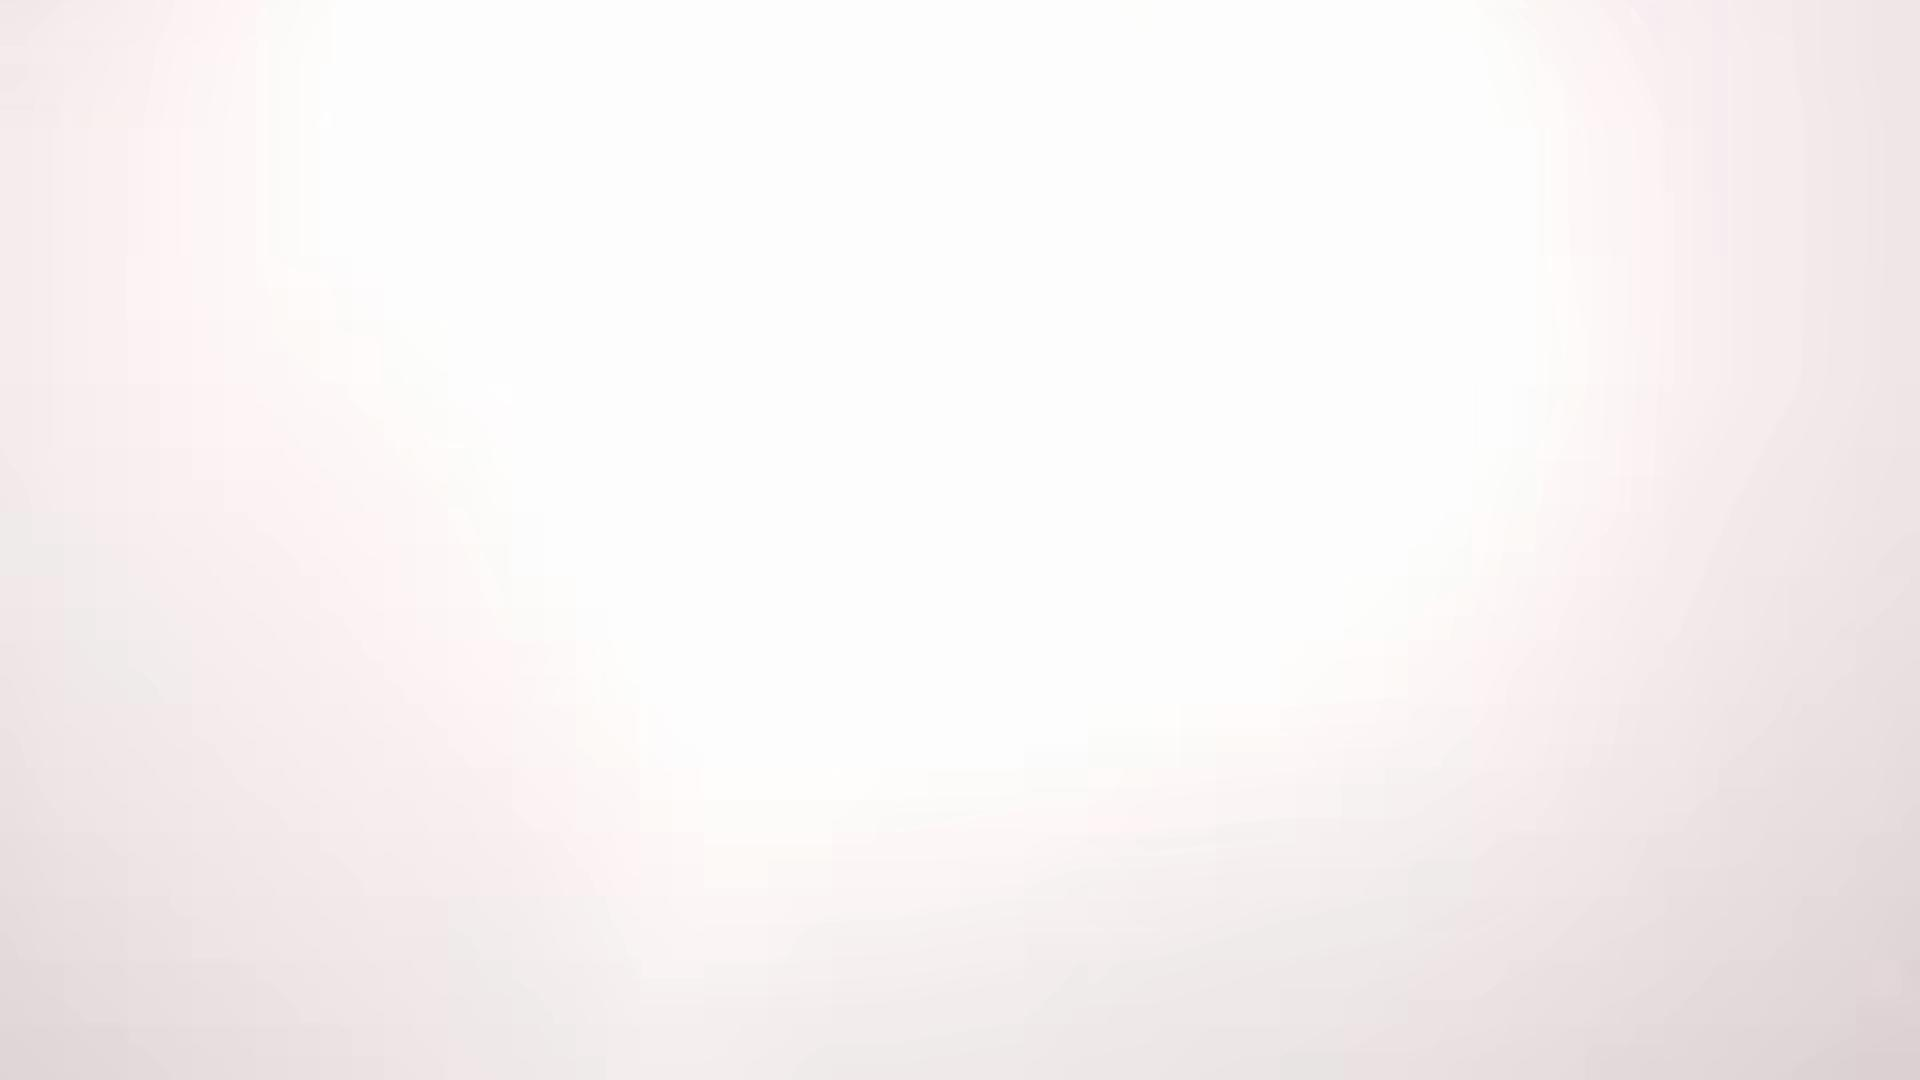

In [17]:
# Search for scenes similar to a query string
query_text = "playing a chess game"
sim = scenes.transcript_text.similarity(query_text)

results = (
    scenes.where(sim >= 0.3)  # Minimum similarity threshold
    .order_by(sim, asc=False)  # Order by similarity (highest first)
    .select(scenes.transcript_text, scenes.pos, scenes.video_segment, similarity=sim)
    .limit(5)
    .collect()
)
results

🎉 **You just built semantic search for your video transcripts!**

With just a few lines of code, you:
- Detected meaningful scene boundaries using content-aware scene detection
- Created a view with one row per scene segment
- Extracted audio and transcribed each scene
- Built a searchable embedding index on transcripts
- Found relevant scenes by text similarity

This demonstrates the power of iterating with data in Pixeltable - scenes, views, and semantic search all working together to make your video content searchable.


## 04 - Persistence Demo

All your work persists - tables, views, computed columns, and embedding indexes survive kernel restarts. After restarting, you can retrieve your view and query it immediately:


In [18]:
%reset -f

In [19]:
# After restarting your kernel, retrieve the view:
import pixeltable as pxt
scenes = pxt.get_table('scene_view')

In [20]:
# All computed columns and data are still there - no recomputation needed
scenes

view 'scene_view' (of 'chess_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                      video_segment.extract_audio()
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang             Json                             transcription.language
              video            Video                                                   
           duration            Float                               video.get_duration()
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

 Index Name           Column  Metric                                          Embedding
       idx1  transcript_text  cosine  sentence_transformer(transcript_text, model_id...

In [22]:
scenes.select(scenes.pos, scenes.transcript_text).head()

pos,transcript_text
0,That check has been the whole point of the sequence beginning with the bishop cutting down the slope of the book by forcing it to a last threatening left. Question is... What will she do now?
1,А вы мы рев
2,It's your game. Take it. Up ahead. Song Lagoon Did you see that?σت tanta assists HIretchdio Ho Right It is your game. You have to take one. Return his spine.
3,"Thank you. Good for you, Crackle. Good for you."
4,
5,"The President has invited you to the White House. There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass. Texas being more of a checker state. There's a dinner tonight after the reception at the Russian chess club in Georgetown. A lot of prominent visitors belong, so I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. Just for the important visitors belong. So we prepared a list of talking poets. It's a big deal, beating the Soviets at the wrong game. Could you stop the car, please? I'd like to walk. To the airport."
6,"You're gonna miss the flood? Come on. Come on. Lisa, come on."
7,Daddy? Harun mu?
8,l'espace�니다.
9,Обц tungр ТРЕВОЖНАЯ МУЗЫКА


## Appendix - JSON Parsing Examples


This section covers JSON parsing in more detail, including step-by-step exploration of the JSON structure and different ways to access query results.


### Exploring JSON Structure

To create a view with video segments, we need to extract the scene start times from our `scenes` column. Let's build up to this step by step, exploring the JSON structure along the way. Learn more about [JSON operations](https://docs.pixeltable.com/platform/type-system).

**Step 1:** First, let's see what the `scenes` column contains:


In [24]:
import pixeltable as pxt
v = pxt.get_table('chess_vids')

In [25]:
# Step 1: Look at the scenes column structure
v.select(v.scenes).collect()

scenes
"[{""duration"": 28.779, ""start_pts"": 0, ""start_time"": 0.}, {""duration"": 16.85, ""start_pts"": 690690, ""start_time"": 28.779}, {""duration"": 80.122, ""start_pts"": 1095094, ""start_time"": 45.629}, {""duration"": 28.737, ""start_pts"": 3018015, ""start_time"": 125.751}, {""duration"": 25.734, ""start_pts"": 3707704, ""start_time"": 154.488}, {""duration"": 51.301, ""start_pts"": 4325321, ""start_time"": 180.222}, {""duration"": 70.32, ""start_pts"": 5556551, ""start_time"": 231.523}, {""duration"": 7.132, ""start_pts"": 7244237, ""start_time"": 301.843}, {""duration"": 41.458, ""start_pts"": 7415408, ""start_time"": 308.975}, {""duration"": 11.261, ""start_pts"": 8410402, ""start_time"": 350.433}]"


**Step 2:** The `scenes` column contains a JSON array. Let's access the first scene to see its structure:

In [26]:
# Step 2: Access the first scene element
v.select(v.scenes[0]).collect()

scenes_0
"{""duration"": 28.779, ""start_pts"": 0, ""start_time"": 0.}"


**Step 3:** Each scene has properties like `start_time` and `end_time`. Let's access the `start_time` of the first scene:


In [27]:
# Step 3: Access the start_time property of the first scene
v.select(v.scenes[0].start_time).collect()


scenes_0_starttime
0.


**Step 4:** Now let's slice the array to get all scenes from index 1 onwards (skipping the first scene, which typically starts at 0):


In [ ]:
# Step 4: Slice to get scenes from index 1 onwards
v.select(v.scenes[1:]).collect()

scenes_1
"[{""duration"": 16.85, ""start_pts"": 690690, ""start_time"": 28.779}, {""duration"": 80.122, ""start_pts"": 1095094, ""start_time"": 45.629}, {""duration"": 28.737, ""start_pts"": 3018015, ""start_time"": 125.751}, {""duration"": 25.734, ""start_pts"": 3707704, ""start_time"": 154.488}, {""duration"": 51.301, ""start_pts"": 4325321, ""start_time"": 180.222}, {""duration"": 70.32, ""start_pts"": 5556551, ""start_time"": 231.523}, {""duration"": 7.132, ""start_pts"": 7244237, ""start_time"": 301.843}, {""duration"": 41.458, ""start_pts"": 7415408, ""start_time"": 308.975}, {""duration"": 11.261, ""start_pts"": 8410402, ""start_time"": 350.433}]"


**Step 5:** Now access the `start_time` property for all scenes in the slice. Here, we'll also name the column `times`:


In [29]:
# Step 5: Access start_time for all scenes from index 1 onwards
v.select(times=v.scenes[1:].start_time).collect()

times
"[28.779, 45.629, 125.751, 154.488, 180.222, 231.523, 301.843, 308.975, 350.433]"


### Accessing Query Results

Using `select()`, we are composing a query to run. When you run a query, Pixeltable gives you a few ways to interact with the results:

1. You can convert to a list of dictionaries
2. You can index by row/column `[0,0]` and by column name

**Example 1:** Convert to a list of dictionaries


In [30]:
result = v.select(times=v.scenes[1:].start_time).collect()

In [31]:
result  # Returns as a table

times
"[28.779, 45.629, 125.751, 154.488, 180.222, 231.523, 301.843, 308.975, 350.433]"


In [32]:
result[0]  # Returns first row as dict

{'times': [28.77875,
  45.62891666666667,
  125.750625,
  154.48766666666666,
  180.22170833333334,
  231.52295833333332,
  301.84320833333334,
  308.9753333333333,
  350.4334166666667]}

In [33]:
result['times']  # Returns list of times values

[[28.77875,
  45.62891666666667,
  125.750625,
  154.48766666666666,
  180.22170833333334,
  231.52295833333332,
  301.84320833333334,
  308.9753333333333,
  350.4334166666667]]

**Example 2:** Index by row/column `[0,0]` and by column name

In [34]:
# Index by position [row, column]
first_value = result[0, 0]  # First row, first column
first_value

[28.77875,
 45.62891666666667,
 125.750625,
 154.48766666666666,
 180.22170833333334,
 231.52295833333332,
 301.84320833333334,
 308.9753333333333,
 350.4334166666667]

In [35]:
# Index by column name
first_time = result[0, "times"]  # First row, "times" column
first_time

[28.77875,
 45.62891666666667,
 125.750625,
 154.48766666666666,
 180.22170833333334,
 231.52295833333332,
 301.84320833333334,
 308.9753333333333,
 350.4334166666667]

---

## Learn More

### Views & Iterators
- [Views Platform Guide](https://docs.pixeltable.com/platform/views) - Creating and using views
- [Iterators Platform Guide](https://docs.pixeltable.com/platform/iterators) - Working with iterators
- [`video_splitter()`](https://docs.pixeltable.com/sdk/latest/video#iterator-video_splitter) - Video segmentation iterator
- [`create_view()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-create-view) - View creation API

### Scene Detection
- [Video Functions](https://docs.pixeltable.com/sdk/latest/video) - Scene detection functions
- [`scene_detect_histogram()`](https://docs.pixeltable.com/sdk/latest/video#udf-scene_detect_histogram) - Content-based scene detection

### Audio & Transcription
- [`extract_audio()`](https://docs.pixeltable.com/sdk/latest/video#udf-extract_audio) - Extract audio from video
- [Whisper Functions](https://docs.pixeltable.com/sdk/latest/whisper) - Local Whisper transcription
- [OpenAI Functions](https://docs.pixeltable.com/sdk/latest/openai) - OpenAI API transcription

### JSON Operations
- [Type System](https://docs.pixeltable.com/platform/type-system) - Working with JSON and other types
- [JSON Operations](https://docs.pixeltable.com/platform/type-system) - Accessing and manipulating JSON data

### Embeddings & Search
- [Embedding Indexes](https://docs.pixeltable.com/platform/embedding-indexes) - Building searchable indexes
- [`sentence_transformer()`](https://docs.pixeltable.com/sdk/latest/huggingface#sentence-transformer) - Text embeddings
- [Similarity Search Cookbooks](https://docs.pixeltable.com/howto/cookbooks/search/search-similar-text) - Text similarity search
- [HuggingFace Integration](https://docs.pixeltable.com/sdk/latest/huggingface) - Working with HuggingFace models

## Functions Used

This notebook uses the following Pixeltable functions:

- [`add_computed_column()`](https://docs.pixeltable.com/sdk/latest/pixeltable#add-computed-column) - Add computed columns to tables
- [`add_embedding_index()`](https://docs.pixeltable.com/sdk/latest/pixeltable#add-embedding-index) - Create embedding indexes for similarity search
- [`create_view()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-create-view) - Create views from tables
- [`extract_audio()`](https://docs.pixeltable.com/sdk/latest/video#udf-extract_audio) - Extract audio from video segments
- [`get_table()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-get-table) - Retrieve existing tables
- [`list_tables()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-list-tables) - List all tables in the database
- [`scene_detect_histogram()`](https://docs.pixeltable.com/sdk/latest/video#udf-scene_detect_histogram) - Detect scene boundaries in video
- [`similarity()`](https://docs.pixeltable.com/sdk/latest/pixeltable#similarity) - Perform similarity search using embedding indexes
- [`transcribe()`](https://docs.pixeltable.com/sdk/latest/whisper#udf-transcribe) - Transcribe audio using Whisper
- [`video_splitter()`](https://docs.pixeltable.com/sdk/latest/video#iterator-video_splitter) - Iterator to split video into segments